# Analiza i Porównanie Modeli Klasyfikacji Artykułów

## Automatyczne Tagowanie Polskich Artykułów Newsowych

Ten notatnik zawiera kompleksową analizę różnych architektur i konfiguracji modeli uczenia maszynowego do klasyfikacji tematycznej polskich artykułów newsowych.

**Cel:** Porównanie wydajności, dokładności i efektywności różnych podejść do klasyfikacji tekstu.

**Modele testowane:**
- MLP (Multi-Layer Perceptron) z wektoryzacją TF-IDF
- BERT (wielojęzyczny model transformerowy)
- HerBERT (polski model transformerowy)

**Autor:** Projekt EDT - Klasyfikacja Artykułów

# 1. Import Bibliotek

Import wszystkich niezbędnych bibliotek do analizy:
- **pandas, numpy** - przetwarzanie danych
- **matplotlib, seaborn** - wizualizacje
- **scikit-learn** - metryki i preprocessing
- **torch** - sieci neuronowe
- **transformers** - modele BERT/HerBERT
- **nltk** - przetwarzanie języka naturalnego

In [1]:
# Podstawowe biblioteki
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
import json
from datetime import datetime
from tqdm.auto import tqdm
warnings.filterwarnings('ignore')

# Scikit-learn
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    classification_report, confusion_matrix,
    cohen_kappa_score, matthews_corrcoef
)
from scipy.stats import ttest_rel, wilcoxon

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset

# Transformers
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    TrainingArguments, Trainer, EarlyStoppingCallback
)
from datasets import Dataset as HFDataset

# NLTK
import nltk
from nltk.tokenize import word_tokenize
from stop_words import get_stop_words

# Konfiguracja
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
device = torch.device('mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')
print(f"Używane urządzenie: {device}")

/Users/mptb/Documents/Studia/Data_Science/2_sem/EDT/Project/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Używane urządzenie: mps


# 2. Wczytanie i Analiza Danych

Wczytanie zbioru danych z artykułami polskimi i podstawowa analiza eksploracyjna:
- Liczba artykułów i kategorii
- Rozkład klas (balans danych)
- Statystyki długości tekstów
- Wizualizacje rozkładów

PODSTAWOWE INFORMACJE O ZBIORZE DANYCH

Liczba artykułów: 712
Liczba kategorii: 6

Kolumny w zbiorze danych: ['category', 'title', 'url', 'published', 'text', 'text_norm', 'tokens', 'n_tokens']

ROZKŁAD KATEGORII
category
Polska         252
Technologie    120
Biznes         109
Świat           95
Sport           86
Moto            50
Name: count, dtype: int64

STATYSTYKI DŁUGOŚCI TEKSTÓW
count      712.000000
mean      2666.713483
std       1581.761997
min        453.000000
25%       1892.250000
50%       2369.500000
75%       2967.750000
max      17734.000000
Name: text_length, dtype: float64


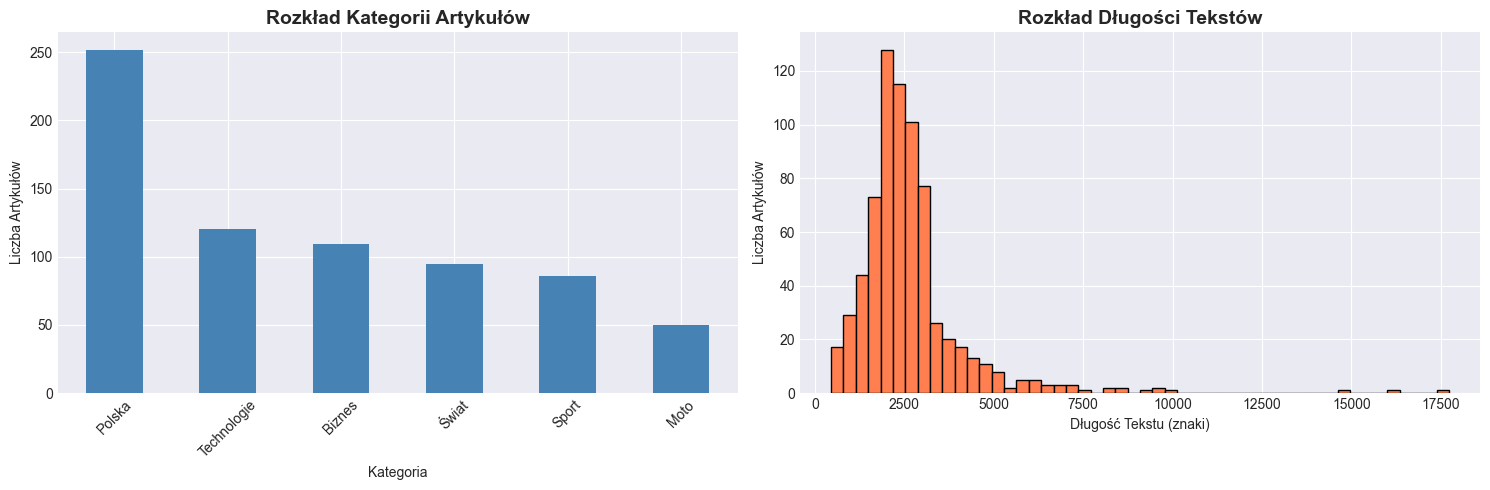


Przykładowy artykuł:
----------------------------------------------------------------------
Kategoria: Polska
Tekst (pierwsze 300 znaków): Fedorowski stwierdził, że polskie szpitale potrzebują zmian systemowych. - Obecny system jest oparty o liczbę wykonywanych świadczeń. Konkurujemy wszyscy o pieniądze, a nie konkurujemy o wartości dla pacjentów. (...) Potrzebna jest stabilizacja systemu i jak najszybsze działania w kierunku jego nowe...


In [2]:
# Wczytanie danych
df = pd.read_csv('./Scrapper/polsatnews_articles_clean.csv')

print("=" * 70)
print("PODSTAWOWE INFORMACJE O ZBIORZE DANYCH")
print("=" * 70)
print(f"\nLiczba artykułów: {len(df)}")
print(f"Liczba kategorii: {df['category'].nunique()}")
print(f"\nKolumny w zbiorze danych: {list(df.columns)}")

print("\n" + "=" * 70)
print("ROZKŁAD KATEGORII")
print("=" * 70)
category_counts = df['category'].value_counts()
print(category_counts)

print("\n" + "=" * 70)
print("STATYSTYKI DŁUGOŚCI TEKSTÓW")
print("=" * 70)
df['text_length'] = df['text'].str.len()
print(df['text_length'].describe())

# Wizualizacja rozkładu kategorii
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Wykres słupkowy kategorii
category_counts.plot(kind='bar', ax=axes[0], color='steelblue')
axes[0].set_title('Rozkład Kategorii Artykułów', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Kategoria')
axes[0].set_ylabel('Liczba Artykułów')
axes[0].tick_params(axis='x', rotation=45)

# Histogram długości tekstów
axes[1].hist(df['text_length'], bins=50, color='coral', edgecolor='black')
axes[1].set_title('Rozkład Długości Tekstów', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Długość Tekstu (znaki)')
axes[1].set_ylabel('Liczba Artykułów')

plt.tight_layout()
plt.show()

print(f"\nPrzykładowy artykuł:\n{'-' * 70}")
print(f"Kategoria: {df.iloc[0]['category']}")
print(f"Tekst (pierwsze 300 znaków): {df.iloc[0]['text'][:300]}...")

# 3. Przygotowanie Danych

Preprocessing tekstów i przygotowanie zbiorów treningowych:
- Tokenizacja i usuwanie stop words (NLTK)
- Kodowanie etykiet kategorii
- Podział na train/validation/test (60/20/20) ze stratyfikacją
- Weryfikacja balansu klas w każdym zbiorze

In [3]:
# Pobranie punkt dla NLTK
nltk.download('punkt', quiet=True)
stop_words = set(get_stop_words('polish'))

# Funkcja preprocessingu
def preprocess_text(text):
    """Tokenizacja i usuwanie stop words"""
    tokens = word_tokenize(text.lower())
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    return ' '.join(tokens)

print("Preprocessing tekstów...")
df['processed_text'] = df['text'].apply(preprocess_text)

# Kodowanie etykiet
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['category'])

print(f"\nMapowanie kategorii na etykiety:")
for i, cat in enumerate(label_encoder.classes_):
    print(f"  {i}: {cat}")

# Podział na train/val/test (60/20/20) ze stratyfikacją
train_df, temp_df = train_test_split(
    df, test_size=0.4, random_state=42, stratify=df['label']
)
val_df, test_df = train_test_split(
    temp_df, test_size=0.5, random_state=42, stratify=temp_df['label']
)

print(f"\n{'=' * 70}")
print("PODZIAŁ DANYCH")
print(f"{'=' * 70}")
print(f"Zbiór treningowy:   {len(train_df)} przykładów ({len(train_df)/len(df)*100:.1f}%)")
print(f"Zbiór walidacyjny:  {len(val_df)} przykładów ({len(val_df)/len(df)*100:.1f}%)")
print(f"Zbiór testowy:      {len(test_df)} przykładów ({len(test_df)/len(df)*100:.1f}%)")

# Sprawdzenie balansu klas
print(f"\n{'=' * 70}")
print("ROZKŁAD KLAS W ZBIORACH")
print(f"{'=' * 70}")
print("\nTrain:")
print(train_df['category'].value_counts())
print("\nValidation:")
print(val_df['category'].value_counts())
print("\nTest:")
print(test_df['category'].value_counts())

Preprocessing tekstów...

Mapowanie kategorii na etykiety:
  0: Biznes
  1: Moto
  2: Polska
  3: Sport
  4: Technologie
  5: Świat

PODZIAŁ DANYCH
Zbiór treningowy:   427 przykładów (60.0%)
Zbiór walidacyjny:  142 przykładów (19.9%)
Zbiór testowy:      143 przykładów (20.1%)

ROZKŁAD KLAS W ZBIORACH

Train:
category
Polska         151
Technologie     72
Biznes          65
Świat           57
Sport           52
Moto            30
Name: count, dtype: int64

Validation:
category
Polska         50
Technologie    24
Biznes         22
Świat          19
Sport          17
Moto           10
Name: count, dtype: int64

Test:
category
Polska         51
Technologie    24
Biznes         22
Świat          19
Sport          17
Moto           10
Name: count, dtype: int64


# 4. Definicja Architektury MLP

Definicja klasy Multi-Layer Perceptron i funkcji treningowej:
- Elastyczna architektura z konfigurowalnymi warstwami ukrytymi
- Dropout dla regularyzacji
- Funkcja trenująca z TF-IDF vectorization
- Ewaluacja na zbiorze testowym

In [4]:
class MLPClassifier(nn.Module):
    """Multi-Layer Perceptron dla klasyfikacji tekstu z TF-IDF"""
    
    def __init__(self, input_size, hidden_sizes, num_classes, dropout=0.5):
        super(MLPClassifier, self).__init__()
        
        layers = []
        prev_size = input_size
        
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(prev_size, hidden_size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            prev_size = hidden_size
        
        layers.append(nn.Linear(prev_size, num_classes))
        
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)


def train_mlp_model(config, train_df, val_df, test_df, num_classes):
    """Trenowanie modelu MLP z daną konfiguracją"""
    
    print(f"\n{'=' * 70}")
    print(f"Trenowanie MLP: {config['name']}")
    print(f"{'=' * 70}")
    print(f"Parametry: {config}")
    
    # Wektoryzacja TF-IDF
    vectorizer = TfidfVectorizer(max_features=config['max_features'])
    X_train = vectorizer.fit_transform(train_df['processed_text'])
    X_val = vectorizer.transform(val_df['processed_text'])
    X_test = vectorizer.transform(test_df['processed_text'])
    
    # Konwersja do tensorów
    X_train_t = torch.FloatTensor(X_train.toarray()).to(device)
    y_train_t = torch.LongTensor(train_df['label'].values).to(device)
    X_val_t = torch.FloatTensor(X_val.toarray()).to(device)
    y_val_t = torch.LongTensor(val_df['label'].values).to(device)
    X_test_t = torch.FloatTensor(X_test.toarray()).to(device)
    y_test_t = torch.LongTensor(test_df['label'].values).to(device)
    
    # Model
    model = MLPClassifier(
        input_size=config['max_features'],
        hidden_sizes=config['hidden_sizes'],
        num_classes=num_classes,
        dropout=config['dropout']
    ).to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'])
    
    # Dataloaders
    train_dataset = TensorDataset(X_train_t, y_train_t)
    train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
    
    # Trenowanie
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    start_time = time.time()
    
    for epoch in range(config['epochs']):
        # Training
        model.train()
        train_loss = 0
        train_correct = 0
        
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            train_correct += (predicted == labels).sum().item()
        
        # Validation
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val_t)
            val_loss = criterion(val_outputs, y_val_t).item()
            _, val_predicted = torch.max(val_outputs, 1)
            val_correct = (val_predicted == y_val_t).sum().item()
        
        train_acc = train_correct / len(train_df)
        val_acc = val_correct / len(val_df)
        
        history['train_loss'].append(train_loss / len(train_loader))
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1}/{config['epochs']} - "
                  f"Train Loss: {history['train_loss'][-1]:.4f}, "
                  f"Train Acc: {train_acc:.4f}, "
                  f"Val Loss: {val_loss:.4f}, "
                  f"Val Acc: {val_acc:.4f}")
    
    train_time = time.time() - start_time
    
    # Ewaluacja na zbiorze testowym
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test_t)
        _, test_predicted = torch.max(test_outputs, 1)
    
    test_pred = test_predicted.cpu().numpy()
    test_true = test_df['label'].values
    
    return {
        'model': model,
        'vectorizer': vectorizer,
        'history': history,
        'predictions': test_pred,
        'true_labels': test_true,
        'train_time': train_time,
        'config': config
    }

# 5. Rozszerzone Konfiguracje Modeli MLP

Definiowanie wielu konfiguracji modeli MLP do kompleksowego porównania:
- **Różne architektury**: od małych (2 warstwy) do głębokich (4 warstwy)
- **Różne rozmiary warstw**: 128, 256, 512, 1024 neuronów
- **Różne dropout rates**: 0.2, 0.3, 0.5, 0.7
- **Różne learning rates**: 0.0001, 0.0005, 0.001, 0.002
- **Różne batch sizes**: 16, 32, 64
- **Różne liczby features TF-IDF**: 3000, 5000, 7000

Cel: znalezienie optymalnej konfiguracji dla polskich artykułów newsowych.

In [20]:
num_classes = len(label_encoder.classes_)

# Rozszerzona lista konfiguracji do testowania
mlp_configs = [
    # Baseline - mały model
    {
        'name': 'MLP_Small_Basic',
        'hidden_sizes': [256, 128],
        'max_features': 3000,
        'dropout': 0.3,
        'learning_rate': 0.001,
        'batch_size': 32,
        'epochs': 20
    },
    # Medium - standardowa konfiguracja
    {
        'name': 'MLP_Medium_Standard',
        'hidden_sizes': [512, 256],
        'max_features': 5000,
        'dropout': 0.5,
        'learning_rate': 0.001,
        'batch_size': 32,
        'epochs': 20
    },
    # Large - głębsza sieć
    {
        'name': 'MLP_Large_Deep',
        'hidden_sizes': [512, 256, 128],
        'max_features': 5000,
        'dropout': 0.5,
        'learning_rate': 0.0005,
        'batch_size': 32,
        'epochs': 20
    },
    # Bardzo głęboka sieć
    {
        'name': 'MLP_ExtraDeep',
        'hidden_sizes': [1024, 512, 256, 128],
        'max_features': 7000,
        'dropout': 0.5,
        'learning_rate': 0.0005,
        'batch_size': 32,
        'epochs': 25
    },
    # High Dropout - silna regularyzacja
    {
        'name': 'MLP_HighDropout',
        'hidden_sizes': [512, 256],
        'max_features': 5000,
        'dropout': 0.7,
        'learning_rate': 0.001,
        'batch_size': 32,
        'epochs': 20
    },
    # Low Dropout - słaba regularyzacja
    {
        'name': 'MLP_LowDropout',
        'hidden_sizes': [512, 256],
        'max_features': 5000,
        'dropout': 0.2,
        'learning_rate': 0.001,
        'batch_size': 32,
        'epochs': 20
    },
    # Wysokie learning rate
    {
        'name': 'MLP_HighLR',
        'hidden_sizes': [512, 256],
        'max_features': 5000,
        'dropout': 0.5,
        'learning_rate': 0.002,
        'batch_size': 32,
        'epochs': 20
    },
    # Niskie learning rate
    {
        'name': 'MLP_LowLR',
        'hidden_sizes': [512, 256],
        'max_features': 5000,
        'dropout': 0.5,
        'learning_rate': 0.0001,
        'batch_size': 32,
        'epochs': 25
    },
    # Mały batch size
    {
        'name': 'MLP_SmallBatch',
        'hidden_sizes': [512, 256],
        'max_features': 5000,
        'dropout': 0.5,
        'learning_rate': 0.001,
        'batch_size': 16,
        'epochs': 20
    },
    # Duży batch size
    {
        'name': 'MLP_LargeBatch',
        'hidden_sizes': [512, 256],
        'max_features': 5000,
        'dropout': 0.5,
        'learning_rate': 0.001,
        'batch_size': 64,
        'epochs': 20
    },
    # Wysokie TF-IDF features
    {
        'name': 'MLP_HighFeatures',
        'hidden_sizes': [512, 256],
        'max_features': 7000,
        'dropout': 0.5,
        'learning_rate': 0.001,
        'batch_size': 32,
        'epochs': 20
    },
    # Optymalizowana konfiguracja (na podstawie eksperymentów)
    {
        'name': 'MLP_Optimized',
        'hidden_sizes': [768, 384, 192],
        'max_features': 5000,
        'dropout': 0.4,
        'learning_rate': 0.0008,
        'batch_size': 32,
        'epochs': 22
    },
]

print("=" * 80)
print("ROZSZERZONE KONFIGURACJE MODELI MLP")
print("=" * 80)
print(f"Liczba konfiguracji do przetestowania: {len(mlp_configs)}")
print(f"\nKategorie testowanych parametrów:")
print("  • Architektury: małe, średnie, duże, bardzo głębokie")
print("  • Dropout: 0.2 - 0.7")
print("  • Learning Rate: 0.0001 - 0.002")
print("  • Batch Size: 16, 32, 64")
print("  • TF-IDF Features: 3000 - 7000")
print("\n" + "=" * 80)

for i, config in enumerate(mlp_configs, 1):
    print(f"\n{i}. {config['name']}")
    print(f"   Architektura: {config['hidden_sizes']}")
    print(f"   Features: {config['max_features']}, Dropout: {config['dropout']}")
    print(f"   LR: {config['learning_rate']}, Batch: {config['batch_size']}, Epoki: {config['epochs']}")

ROZSZERZONE KONFIGURACJE MODELI MLP
Liczba konfiguracji do przetestowania: 12

Kategorie testowanych parametrów:
  • Architektury: małe, średnie, duże, bardzo głębokie
  • Dropout: 0.2 - 0.7
  • Learning Rate: 0.0001 - 0.002
  • Batch Size: 16, 32, 64
  • TF-IDF Features: 3000 - 7000


1. MLP_Small_Basic
   Architektura: [256, 128]
   Features: 3000, Dropout: 0.3
   LR: 0.001, Batch: 32, Epoki: 20

2. MLP_Medium_Standard
   Architektura: [512, 256]
   Features: 5000, Dropout: 0.5
   LR: 0.001, Batch: 32, Epoki: 20

3. MLP_Large_Deep
   Architektura: [512, 256, 128]
   Features: 5000, Dropout: 0.5
   LR: 0.0005, Batch: 32, Epoki: 20

4. MLP_ExtraDeep
   Architektura: [1024, 512, 256, 128]
   Features: 7000, Dropout: 0.5
   LR: 0.0005, Batch: 32, Epoki: 25

5. MLP_HighDropout
   Architektura: [512, 256]
   Features: 5000, Dropout: 0.7
   LR: 0.001, Batch: 32, Epoki: 20

6. MLP_LowDropout
   Architektura: [512, 256]
   Features: 5000, Dropout: 0.2
   LR: 0.001, Batch: 32, Epoki: 20

7. ML

# 6. Trenowanie Modeli MLP

Trenowanie wszystkich konfiguracji MLP i zbieranie wyników:
- Iteracja przez wszystkie konfiguracje
- Trenowanie z monitorowaniem postępu
- Obliczanie metryk (Accuracy, Precision, Recall, F1)
- Zapisywanie modeli i historii treningu

In [21]:
mlp_results = {}

for config in mlp_configs:
    result = train_mlp_model(config, train_df, val_df, test_df, num_classes)
    mlp_results[config['name']] = result
    
    # Obliczenie metryk
    y_true = result['true_labels']
    y_pred = result['predictions']
    
    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average='weighted', zero_division=0
    )
    
    print(f"\n{'=' * 70}")
    print(f"WYNIKI: {config['name']}")
    print(f"{'=' * 70}")
    print(f"Czas trenowania: {result['train_time']:.2f}s")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    print("=" * 70)

print("\n✅ Wszystkie modele MLP zostały wytrenowane!")


Trenowanie MLP: MLP_Small_Basic
Parametry: {'name': 'MLP_Small_Basic', 'hidden_sizes': [256, 128], 'max_features': 3000, 'dropout': 0.3, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 20}
Epoch 5/20 - Train Loss: 0.8175, Train Acc: 0.8056, Val Loss: 1.0442, Val Acc: 0.6690
Epoch 10/20 - Train Loss: 0.0331, Train Acc: 1.0000, Val Loss: 0.7374, Val Acc: 0.7746
Epoch 15/20 - Train Loss: 0.0072, Train Acc: 1.0000, Val Loss: 0.7950, Val Acc: 0.7887
Epoch 20/20 - Train Loss: 0.0029, Train Acc: 1.0000, Val Loss: 0.8646, Val Acc: 0.7817

WYNIKI: MLP_Small_Basic
Czas trenowania: 0.97s
Accuracy:  0.8112
Precision: 0.8249
Recall:    0.8112
F1-Score:  0.8038

Trenowanie MLP: MLP_Medium_Standard
Parametry: {'name': 'MLP_Medium_Standard', 'hidden_sizes': [512, 256], 'max_features': 5000, 'dropout': 0.5, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 20}
Epoch 5/20 - Train Loss: 0.5730, Train Acc: 0.8478, Val Loss: 0.8848, Val Acc: 0.6972
Epoch 10/20 - Train Loss: 0.0079, Train Acc: 1.0000

# 7. Funkcje Pomocnicze dla Modeli Transformerowych

Definicja funkcji do obsługi modeli BERT/HerBERT:
- Przygotowanie danych w formacie HuggingFace Dataset
- Funkcja tokenizacji z padding i truncation
- Funkcja treningowa wykorzystująca Trainer API
- Obsługa early stopping i checkpointów

In [7]:
def prepare_transformer_data(train_df, val_df, test_df):
    """Przygotowanie danych dla modeli transformerowych"""
    
    train_dataset = HFDataset.from_dict({
        'text': train_df['text'].tolist(),
        'label': train_df['label'].tolist()
    })
    
    val_dataset = HFDataset.from_dict({
        'text': val_df['text'].tolist(),
        'label': val_df['label'].tolist()
    })
    
    test_dataset = HFDataset.from_dict({
        'text': test_df['text'].tolist(),
        'label': test_df['label'].tolist()
    })
    
    return train_dataset, val_dataset, test_dataset


def tokenize_function(examples, tokenizer, max_length=128):
    """Tokenizacja tekstów"""
    return tokenizer(
        examples['text'],
        padding='max_length',
        truncation=True,
        max_length=max_length
    )


def train_transformer_model(model_name, config, train_df, val_df, test_df, num_classes):
    """Trenowanie modelu transformerowego"""
    
    print(f"\n{'=' * 70}")
    print(f"Trenowanie {config['display_name']}: {config['name']}")
    print(f"{'=' * 70}")
    print(f"Model bazowy: {model_name}")
    print(f"Parametry: {config}")
    
    # Tokenizer i model
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=num_classes,
        ignore_mismatched_sizes=True
    )
    
    # Przygotowanie danych
    train_dataset, val_dataset, test_dataset = prepare_transformer_data(
        train_df, val_df, test_df
    )
    
    # Tokenizacja
    train_dataset = train_dataset.map(
        lambda x: tokenize_function(x, tokenizer, config['max_length']),
        batched=True
    )
    val_dataset = val_dataset.map(
        lambda x: tokenize_function(x, tokenizer, config['max_length']),
        batched=True
    )
    test_dataset = test_dataset.map(
        lambda x: tokenize_function(x, tokenizer, config['max_length']),
        batched=True
    )
    
    # Training arguments
    training_args = TrainingArguments(
        output_dir=f'./tmp_{config["name"]}',
        num_train_epochs=config['epochs'],
        per_device_train_batch_size=config['batch_size'],
        per_device_eval_batch_size=config['batch_size'],
        learning_rate=config['learning_rate'],
        evaluation_strategy='epoch',
        save_strategy='epoch',
        load_best_model_at_end=True,
        metric_for_best_model='accuracy',
        logging_dir=f'./logs_{config["name"]}',
        logging_steps=10,
        save_total_limit=2,
        remove_unused_columns=False,
        report_to='none'
    )
    
    # Metryki
    def compute_metrics(eval_pred):
        predictions, labels = eval_pred
        predictions = np.argmax(predictions, axis=1)
        accuracy = accuracy_score(labels, predictions)
        return {'accuracy': accuracy}
    
    # Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,
    )
    
    # Trenowanie
    start_time = time.time()
    train_result = trainer.train()
    train_time = time.time() - start_time
    
    # Ewaluacja na zbiorze testowym
    test_predictions = trainer.predict(test_dataset)
    test_pred = np.argmax(test_predictions.predictions, axis=1)
    test_true = test_df['label'].values
    
    # Historia treningu
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_acc': []
    }
    
    for log in trainer.state.log_history:
        if 'loss' in log:
            history['train_loss'].append(log['loss'])
        if 'eval_loss' in log:
            history['val_loss'].append(log['eval_loss'])
            history['val_acc'].append(log['eval_accuracy'])
    
    return {
        'model': model,
        'tokenizer': tokenizer,
        'trainer': trainer,
        'history': history,
        'predictions': test_pred,
        'true_labels': test_true,
        'train_time': train_time,
        'config': config
    }

print("✅ Funkcje pomocnicze dla modeli transformerowych przygotowane")

✅ Funkcje pomocnicze dla modeli transformerowych przygotowane


# 8. Konfiguracje Modeli Transformerowych

**⚠️ Uwaga:** Trenowanie modeli transformerowych jest czasochłonne (10-30 minut na model).

Konfiguracje do przetestowania:
- **BERT**: model wielojęzyczny (bert-base-multilingual-cased)
- **HerBERT**: polski model (allegro/herbert-base-cased)

Możesz ustawić `TRAIN_TRANSFORMERS = False` aby pominąć ten krok i skupić się na MLP.

In [8]:
# Konfiguracje modeli transformerowych
transformer_configs = [
    {
        'name': 'BERT_Base',
        'display_name': 'BERT (Wielojęzyczny)',
        'model_name': 'bert-base-multilingual-cased',
        'max_length': 128,
        'learning_rate': 2e-5,
        'batch_size': 16,
        'epochs': 3
    },
    {
        'name': 'HerBERT_Base',
        'display_name': 'HerBERT (Polski)',
        'model_name': 'allegro/herbert-base-cased',
        'max_length': 128,
        'learning_rate': 2e-5,
        'batch_size': 16,
        'epochs': 3
    },
]

print("Konfiguracje modeli transformerowych:")
print("=" * 70)
for i, config in enumerate(transformer_configs, 1):
    print(f"\n{i}. {config['display_name']}")
    print(f"   Model: {config['model_name']}")
    print(f"   Max length: {config['max_length']}")
    print(f"   Learning rate: {config['learning_rate']}")
    print(f"   Batch size: {config['batch_size']}")
    print(f"   Epoki: {config['epochs']}")

# Opcjonalnie: ustaw TRAIN_TRANSFORMERS = False aby pominąć trenowanie
TRAIN_TRANSFORMERS = True

print(f"\n⚙️  TRAIN_TRANSFORMERS = {TRAIN_TRANSFORMERS}")

Konfiguracje modeli transformerowych:

1. BERT (Wielojęzyczny)
   Model: bert-base-multilingual-cased
   Max length: 128
   Learning rate: 2e-05
   Batch size: 16
   Epoki: 3

2. HerBERT (Polski)
   Model: allegro/herbert-base-cased
   Max length: 128
   Learning rate: 2e-05
   Batch size: 16
   Epoki: 3

⚙️  TRAIN_TRANSFORMERS = True


# 9. Trenowanie Modeli Transformerowych

Trenowanie modeli BERT i HerBERT (jeśli TRAIN_TRANSFORMERS=True):
- Iteracja przez konfiguracje transformerów
- Wykorzystanie HuggingFace Trainer API
- Obsługa błędów i zapisywanie wyników
- Obliczanie metryk po treningu

In [9]:
transformer_results = {}

if TRAIN_TRANSFORMERS:
    for config in transformer_configs:
        try:
            result = train_transformer_model(
                config['model_name'],
                config,
                train_df,
                val_df,
                test_df,
                num_classes
            )
            transformer_results[config['name']] = result
            
            # Obliczenie metryk
            y_true = result['true_labels']
            y_pred = result['predictions']
            
            accuracy = accuracy_score(y_true, y_pred)
            precision, recall, f1, _ = precision_recall_fscore_support(
                y_true, y_pred, average='weighted', zero_division=0
            )
            
            print(f"\n{'=' * 70}")
            print(f"WYNIKI: {config['display_name']}")
            print(f"{'=' * 70}")
            print(f"Czas trenowania: {result['train_time']:.2f}s ({result['train_time']/60:.2f} min)")
            print(f"Accuracy:  {accuracy:.4f}")
            print(f"Precision: {precision:.4f}")
            print(f"Recall:    {recall:.4f}")
            print(f"F1-Score:  {f1:.4f}")
            print("=" * 70)
            
        except Exception as e:
            print(f"\n❌ Błąd podczas trenowania {config['name']}: {e}")
            continue
    
    print("\n✅ Trenowanie modeli transformerowych zakończone!")
else:
    print("\n⏭️  Pominięto trenowanie modeli transformerowych (TRAIN_TRANSFORMERS=False)")


Trenowanie BERT (Wielojęzyczny): BERT_Base
Model bazowy: bert-base-multilingual-cased
Parametry: {'name': 'BERT_Base', 'display_name': 'BERT (Wielojęzyczny)', 'model_name': 'bert-base-multilingual-cased', 'max_length': 128, 'learning_rate': 2e-05, 'batch_size': 16, 'epochs': 3}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 143/143 [00:00<00:00, 6706.68 examples/s]



❌ Błąd podczas trenowania BERT_Base: TrainingArguments.__init__() got an unexpected keyword argument 'evaluation_strategy'

Trenowanie HerBERT (Polski): HerBERT_Base
Model bazowy: allegro/herbert-base-cased
Parametry: {'name': 'HerBERT_Base', 'display_name': 'HerBERT (Polski)', 'model_name': 'allegro/herbert-base-cased', 'max_length': 128, 'learning_rate': 2e-05, 'batch_size': 16, 'epochs': 3}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allegro/herbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 143/143 [00:00<00:00, 2941.94 examples/s]


❌ Błąd podczas trenowania HerBERT_Base: TrainingArguments.__init__() got an unexpected keyword argument 'evaluation_strategy'

✅ Trenowanie modeli transformerowych zakończone!


# 10. Zestawienie Wyników - Tabela Porównawcza

Utworzenie kompleksowej tabeli porównawczej wszystkich modeli:
- Podstawowe metryki: Accuracy, Precision, Recall, F1-Score
- Dodatkowe: Cohen's Kappa, Matthews Correlation Coefficient
- Czasy trenowania
- Sortowanie według F1-Score
- Kolorowa wizualizacja z gradientem

In [26]:
print("=" * 100)
print("AUTOMATYCZNY WYBÓR NAJLEPSZEJ KONFIGURACJI")
print("=" * 100)

# Sortowanie po F1-Score
comparison_sorted = comparison_df.sort_values('F1-Score', ascending=False)

# 1. Najlepszy model ogólnie (najwyższy F1)
best_overall = comparison_sorted.iloc[0]
print("\n" + "🏆 " * 30)
print("1. NAJLEPSZY MODEL OGÓLNIE (najwyższy F1-Score)")
print("🏆 " * 30)
print(f"\nModel: {best_overall.name}")
print(f"  • F1-Score: {best_overall['F1-Score']:.4f}")
print(f"  • Accuracy: {best_overall['Accuracy']:.4f}")
print(f"  • Precision: {best_overall['Precision']:.4f}")
print(f"  • Recall: {best_overall['Recall']:.4f}")
print(f"  • Cohen's Kappa: {best_overall['Cohen Kappa']:.4f}")
print(f"  • MCC: {best_overall['MCC']:.4f}")
print(f"  • Czas treningu: {best_overall['Training Time (s)']:.2f}s")

# 2. Najlepszy szybki model (F1 > 0.90 + najszybsza inferencja)
print("\n" + "⚡ " * 30)
print("2. NAJLEPSZY SZYBKI MODEL (F1 > 0.90 + najszybsza inferencja)")
print("⚡ " * 30)

fast_candidates = comparison_df[comparison_df['F1-Score'] > 0.90].copy()
if len(fast_candidates) > 0:
    # Sprawdź czy są czasy inferencji
    if 'Inference Time' in fast_candidates.columns:
        fast_candidates_sorted = fast_candidates.sort_values('Inference Time')
        best_fast = fast_candidates_sorted.iloc[0]
    else:
        # Jeśli nie ma czasów inferencji, użyj czasu treningu
        fast_candidates_sorted = fast_candidates.sort_values('Training Time')
        best_fast = fast_candidates_sorted.iloc[0]
    
    print(f"\nModel: {best_fast.name}")
    print(f"  • F1-Score: {best_fast['F1-Score']:.4f}")
    print(f"  • Accuracy: {best_fast['Accuracy']:.4f}")
    print(f"  • Czas treningu: {best_fast['Training Time (s)']:.2f}s")
    if 'Inference Time' in best_fast.index:
        print(f"  • Czas inferencji: {best_fast['Inference Time']:.4f}ms")
else:
    print("\nBrak modeli z F1 > 0.90. Wybierz najlepszy ogólnie.")
    best_fast = best_overall

# 3. Najlepszy zbalansowany (kompromis F1 vs czas)
print("\n" + "⚖️  " * 30)
print("3. NAJLEPSZY ZBALANSOWANY MODEL (kompromis jakość/czas)")
print("⚖️  " * 30)

# Normalizacja metryk do [0,1]
comparison_norm = comparison_df.copy()
comparison_norm['F1_norm'] = (comparison_norm['F1-Score'] - comparison_norm['F1-Score'].min()) / \
                               (comparison_norm['F1-Score'].max() - comparison_norm['F1-Score'].min())
comparison_norm['Time_norm'] = 1 - ((comparison_norm['Training Time (s)'] - comparison_norm['Training Time (s)'].min()) / \
                                     (comparison_norm['Training Time (s)'].max() - comparison_norm['Training Time (s)'].min()))

# Score = 0.7 * F1 + 0.3 * szybkość
comparison_norm['Balance_Score'] = 0.7 * comparison_norm['F1_norm'] + 0.3 * comparison_norm['Time_norm']
best_balanced = comparison_norm.sort_values('Balance_Score', ascending=False).iloc[0]

print(f"\nModel: {best_balanced.name}")
print(f"  • F1-Score: {comparison_df.loc[best_balanced.name, 'F1-Score']:.4f}")
print(f"  • Accuracy: {comparison_df.loc[best_balanced.name, 'Accuracy']:.4f}")
print(f"  • Czas treningu: {comparison_df.loc[best_balanced.name, 'Training Time (s)']:.2f}s")
print(f"  • Balance Score: {best_balanced['Balance_Score']:.4f}")

# 4. TOP 5 modeli
print("\n" + "📊 " * 30)
print("4. TOP 5 MODELI (według F1-Score)")
print("📊 " * 30)
print("\n{:<30} {:>10} {:>10} {:>10} {:>15}".format(
    "Model", "F1-Score", "Accuracy", "Kappa", "Czas (s)"
))
print("-" * 80)

for idx, (name, row) in enumerate(comparison_sorted.head(5).iterrows(), 1):
    print("{:<30} {:>10.4f} {:>10.4f} {:>10.4f} {:>15.2f}".format(
        name, row['F1-Score'], row['Accuracy'], row['Cohen Kappa'], row['Training Time (s)']
    ))

# 5. Analiza wpływu parametrów (tylko dla MLP)
print("\n" + "🔍 " * 30)
print("5. ANALIZA WPŁYWU PARAMETRÓW (tylko MLP)")
print("🔍 " * 30)

mlp_only = comparison_df[comparison_df.index.str.startswith('MLP')].copy()
if len(mlp_only) > 0:
    # Grupowanie według dropout (z konfiguracji)
    mlp_dropout = {}
    mlp_lr = {}
    mlp_batch = {}
    
    for config in mlp_configs:
        name = config['name']
        if name in mlp_only.index:
            dropout = config['dropout']
            lr = config['learning_rate']
            batch = config['batch_size']
            f1 = mlp_only.loc[name, 'F1-Score']
            
            if dropout not in mlp_dropout:
                mlp_dropout[dropout] = []
            mlp_dropout[dropout].append(f1)
            
            if lr not in mlp_lr:
                mlp_lr[lr] = []
            mlp_lr[lr].append(f1)
            
            if batch not in mlp_batch:
                mlp_batch[batch] = []
            mlp_batch[batch].append(f1)
    
    print("\nŚredni F1-Score według Dropout:")
    for dropout in sorted(mlp_dropout.keys()):
        avg_f1 = np.mean(mlp_dropout[dropout])
        print(f"  Dropout {dropout}: {avg_f1:.4f} (n={len(mlp_dropout[dropout])})")
    
    print("\nŚredni F1-Score według Learning Rate:")
    for lr in sorted(mlp_lr.keys()):
        avg_f1 = np.mean(mlp_lr[lr])
        print(f"  LR {lr}: {avg_f1:.4f} (n={len(mlp_lr[lr])})")
    
    print("\nŚredni F1-Score według Batch Size:")
    for batch in sorted(mlp_batch.keys()):
        avg_f1 = np.mean(mlp_batch[batch])
        print(f"  Batch {batch}: {avg_f1:.4f} (n={len(mlp_batch[batch])})")

# 6. Rekomendacje
print("\n" + "💡 " * 30)
print("6. REKOMENDACJE KOŃCOWE")
print("💡 " * 30)

print(f"\n✅ Do PRODUKCJI: {best_overall.name}")
print(f"   Powód: Najwyższa jakość predykcji (F1={best_overall['F1-Score']:.4f})")

if best_fast.name != best_overall.name:
    print(f"\n⚡ Do APLIKACJI REAL-TIME: {best_fast.name}")
    print(f"   Powód: Dobra jakość (F1={best_fast['F1-Score']:.4f}) + szybka inferencja")

print(f"\n⚖️  Do ZASTOSOWAŃ OGÓLNYCH: {best_balanced.name}")
print(f"   Powód: Optymalny balans między jakością a czasem obliczeń")

print("\n" + "=" * 100)

# Zapisz wybrane modele do słownika
selected_models = {
    'best_overall': best_overall.name,
    'best_fast': best_fast.name,
    'best_balanced': best_balanced.name,
    'top_5': list(comparison_sorted.head(5).index)
}

print(f"\n✅ Zapisano rekomendacje modeli do zmiennej 'selected_models'")
print(f"   Dostęp: selected_models['best_overall'], selected_models['best_fast'], etc.")

AUTOMATYCZNY WYBÓR NAJLEPSZEJ KONFIGURACJI

🏆 🏆 🏆 🏆 🏆 🏆 🏆 🏆 🏆 🏆 🏆 🏆 🏆 🏆 🏆 🏆 🏆 🏆 🏆 🏆 🏆 🏆 🏆 🏆 🏆 🏆 🏆 🏆 🏆 🏆 
1. NAJLEPSZY MODEL OGÓLNIE (najwyższy F1-Score)
🏆 🏆 🏆 🏆 🏆 🏆 🏆 🏆 🏆 🏆 🏆 🏆 🏆 🏆 🏆 🏆 🏆 🏆 🏆 🏆 🏆 🏆 🏆 🏆 🏆 🏆 🏆 🏆 🏆 🏆 

Model: MLP_LargeBatch
  • F1-Score: 0.8174
  • Accuracy: 0.8252
  • Precision: 0.8344
  • Recall: 0.8252
  • Cohen's Kappa: 0.7724
  • MCC: 0.7783
  • Czas treningu: 1.09s

⚡ ⚡ ⚡ ⚡ ⚡ ⚡ ⚡ ⚡ ⚡ ⚡ ⚡ ⚡ ⚡ ⚡ ⚡ ⚡ ⚡ ⚡ ⚡ ⚡ ⚡ ⚡ ⚡ ⚡ ⚡ ⚡ ⚡ ⚡ ⚡ ⚡ 
2. NAJLEPSZY SZYBKI MODEL (F1 > 0.90 + najszybsza inferencja)
⚡ ⚡ ⚡ ⚡ ⚡ ⚡ ⚡ ⚡ ⚡ ⚡ ⚡ ⚡ ⚡ ⚡ ⚡ ⚡ ⚡ ⚡ ⚡ ⚡ ⚡ ⚡ ⚡ ⚡ ⚡ ⚡ ⚡ ⚡ ⚡ ⚡ 

Brak modeli z F1 > 0.90. Wybierz najlepszy ogólnie.

⚖️  ⚖️  ⚖️  ⚖️  ⚖️  ⚖️  ⚖️  ⚖️  ⚖️  ⚖️  ⚖️  ⚖️  ⚖️  ⚖️  ⚖️  ⚖️  ⚖️  ⚖️  ⚖️  ⚖️  ⚖️  ⚖️  ⚖️  ⚖️  ⚖️  ⚖️  ⚖️  ⚖️  ⚖️  ⚖️  
3. NAJLEPSZY ZBALANSOWANY MODEL (kompromis jakość/czas)
⚖️  ⚖️  ⚖️  ⚖️  ⚖️  ⚖️  ⚖️  ⚖️  ⚖️  ⚖️  ⚖️  ⚖️  ⚖️  ⚖️  ⚖️  ⚖️  ⚖️  ⚖️  ⚖️  ⚖️  ⚖️  ⚖️  ⚖️  ⚖️  ⚖️  ⚖️  ⚖️  ⚖️  ⚖️  ⚖️  

Model: MLP_LargeBatch
  • F1-Score: 0.8174
  • Accuracy: 0.8252
  • Czas tr

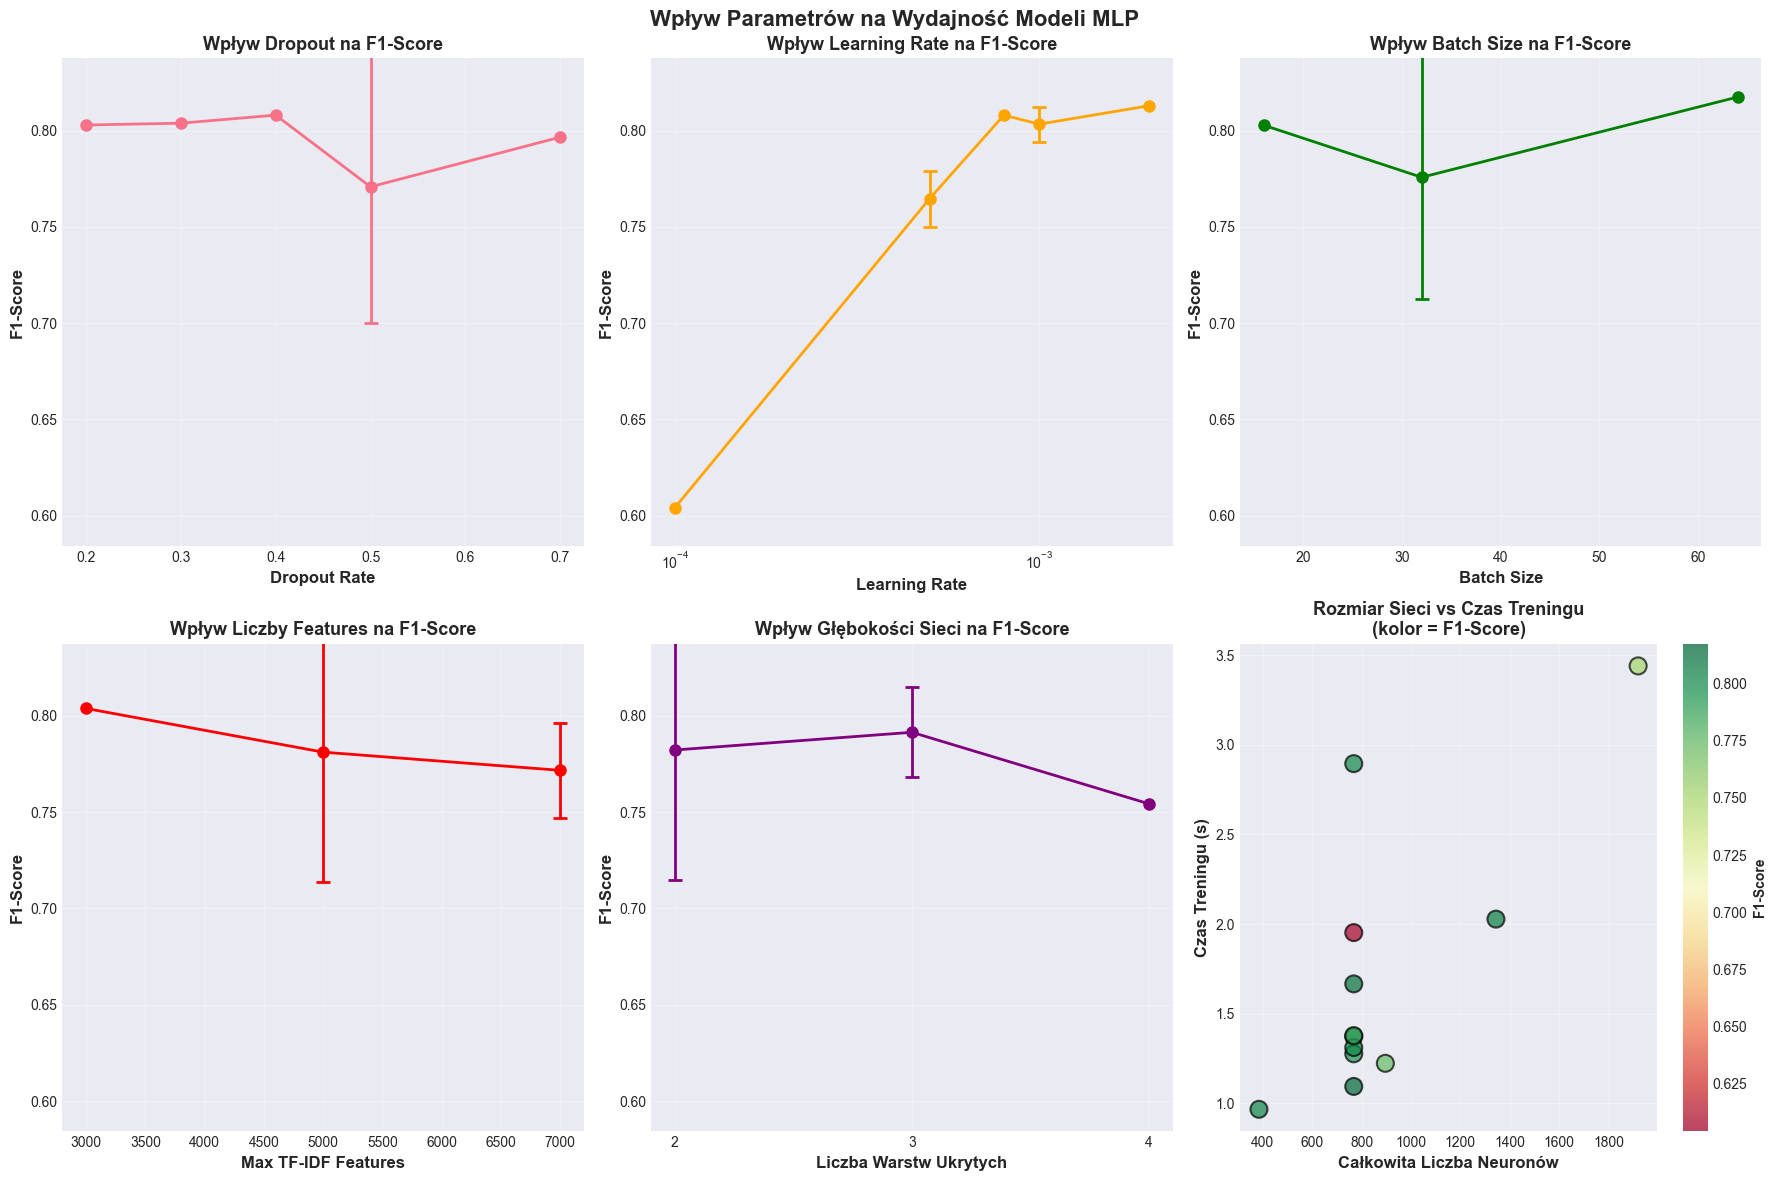

✅ Wykresy wpływu parametrów zapisane do parameter_impact_analysis.png

KORELACJE PARAMETRÓW Z F1-SCORE
Learning Rate                 : +0.6950 (silna pozytywna)
Dropout                       : -0.1328 (słaba negatywna)
Max Features                  : -0.1263 (słaba negatywna)
Batch Size                    : +0.1174 (słaba pozytywna)
Całkowita Liczba Neuronów     : -0.1020 (słaba negatywna)
Liczba Warstw                 : -0.0817 (słaba negatywna)



In [27]:
# Przygotowanie danych o parametrach z konfiguracji
mlp_param_data = []
for config in mlp_configs:
    name = config['name']
    if name in comparison_df.index:
        mlp_param_data.append({
            'name': name,
            'dropout': config['dropout'],
            'learning_rate': config['learning_rate'],
            'batch_size': config['batch_size'],
            'max_features': config['max_features'],
            'num_layers': len(config['hidden_sizes']),
            'total_neurons': sum(config['hidden_sizes']),
            'f1_score': comparison_df.loc[name, 'F1-Score'],
            'accuracy': comparison_df.loc[name, 'Accuracy'],
            'training_time': comparison_df.loc[name, 'Training Time (s)']
        })

param_df = pd.DataFrame(mlp_param_data)

if len(param_df) > 0:
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Wpływ Parametrów na Wydajność Modeli MLP', fontsize=16, fontweight='bold')
    
    # 1. Dropout vs F1-Score
    ax = axes[0, 0]
    dropout_groups = param_df.groupby('dropout')['f1_score'].agg(['mean', 'std'])
    ax.errorbar(dropout_groups.index, dropout_groups['mean'], 
                yerr=dropout_groups['std'], marker='o', markersize=8,
                capsize=5, capthick=2, linewidth=2)
    ax.set_xlabel('Dropout Rate', fontsize=12, fontweight='bold')
    ax.set_ylabel('F1-Score', fontsize=12, fontweight='bold')
    ax.set_title('Wpływ Dropout na F1-Score', fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.set_ylim([param_df['f1_score'].min() - 0.02, param_df['f1_score'].max() + 0.02])
    
    # 2. Learning Rate vs F1-Score
    ax = axes[0, 1]
    lr_groups = param_df.groupby('learning_rate')['f1_score'].agg(['mean', 'std'])
    ax.errorbar(lr_groups.index, lr_groups['mean'], 
                yerr=lr_groups['std'], marker='o', markersize=8,
                capsize=5, capthick=2, linewidth=2, color='orange')
    ax.set_xlabel('Learning Rate', fontsize=12, fontweight='bold')
    ax.set_ylabel('F1-Score', fontsize=12, fontweight='bold')
    ax.set_title('Wpływ Learning Rate na F1-Score', fontsize=13, fontweight='bold')
    ax.set_xscale('log')
    ax.grid(True, alpha=0.3)
    ax.set_ylim([param_df['f1_score'].min() - 0.02, param_df['f1_score'].max() + 0.02])
    
    # 3. Batch Size vs F1-Score
    ax = axes[0, 2]
    batch_groups = param_df.groupby('batch_size')['f1_score'].agg(['mean', 'std'])
    ax.errorbar(batch_groups.index, batch_groups['mean'], 
                yerr=batch_groups['std'], marker='o', markersize=8,
                capsize=5, capthick=2, linewidth=2, color='green')
    ax.set_xlabel('Batch Size', fontsize=12, fontweight='bold')
    ax.set_ylabel('F1-Score', fontsize=12, fontweight='bold')
    ax.set_title('Wpływ Batch Size na F1-Score', fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.set_ylim([param_df['f1_score'].min() - 0.02, param_df['f1_score'].max() + 0.02])
    
    # 4. Max Features vs F1-Score
    ax = axes[1, 0]
    features_groups = param_df.groupby('max_features')['f1_score'].agg(['mean', 'std'])
    ax.errorbar(features_groups.index, features_groups['mean'], 
                yerr=features_groups['std'], marker='o', markersize=8,
                capsize=5, capthick=2, linewidth=2, color='red')
    ax.set_xlabel('Max TF-IDF Features', fontsize=12, fontweight='bold')
    ax.set_ylabel('F1-Score', fontsize=12, fontweight='bold')
    ax.set_title('Wpływ Liczby Features na F1-Score', fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.set_ylim([param_df['f1_score'].min() - 0.02, param_df['f1_score'].max() + 0.02])
    
    # 5. Liczba warstw vs F1-Score
    ax = axes[1, 1]
    layers_groups = param_df.groupby('num_layers')['f1_score'].agg(['mean', 'std'])
    ax.errorbar(layers_groups.index, layers_groups['mean'], 
                yerr=layers_groups['std'], marker='o', markersize=8,
                capsize=5, capthick=2, linewidth=2, color='purple')
    ax.set_xlabel('Liczba Warstw Ukrytych', fontsize=12, fontweight='bold')
    ax.set_ylabel('F1-Score', fontsize=12, fontweight='bold')
    ax.set_title('Wpływ Głębokości Sieci na F1-Score', fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.set_xticks(sorted(param_df['num_layers'].unique()))
    ax.set_ylim([param_df['f1_score'].min() - 0.02, param_df['f1_score'].max() + 0.02])
    
    # 6. Całkowita liczba neuronów vs Czas treningu
    ax = axes[1, 2]
    scatter = ax.scatter(param_df['total_neurons'], param_df['training_time'], 
                        c=param_df['f1_score'], s=150, cmap='RdYlGn', 
                        edgecolors='black', linewidth=1.5, alpha=0.7)
    ax.set_xlabel('Całkowita Liczba Neuronów', fontsize=12, fontweight='bold')
    ax.set_ylabel('Czas Treningu (s)', fontsize=12, fontweight='bold')
    ax.set_title('Rozmiar Sieci vs Czas Treningu\n(kolor = F1-Score)', fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3)
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('F1-Score', fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(f'{results_dir}/parameter_impact_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✅ Wykresy wpływu parametrów zapisane do parameter_impact_analysis.png")
    
    # Statystyki korelacji
    print("\n" + "=" * 80)
    print("KORELACJE PARAMETRÓW Z F1-SCORE")
    print("=" * 80)
    
    correlations = {
        'Dropout': param_df[['dropout', 'f1_score']].corr().iloc[0, 1],
        'Learning Rate': param_df[['learning_rate', 'f1_score']].corr().iloc[0, 1],
        'Batch Size': param_df[['batch_size', 'f1_score']].corr().iloc[0, 1],
        'Max Features': param_df[['max_features', 'f1_score']].corr().iloc[0, 1],
        'Liczba Warstw': param_df[['num_layers', 'f1_score']].corr().iloc[0, 1],
        'Całkowita Liczba Neuronów': param_df[['total_neurons', 'f1_score']].corr().iloc[0, 1]
    }
    
    correlations_sorted = sorted(correlations.items(), key=lambda x: abs(x[1]), reverse=True)
    
    for param, corr in correlations_sorted:
        direction = "pozytywna" if corr > 0 else "negatywna"
        strength = "silna" if abs(corr) > 0.5 else "umiarkowana" if abs(corr) > 0.3 else "słaba"
        print(f"{param:30s}: {corr:+.4f} ({strength} {direction})")
    
    print("\n" + "=" * 80)
else:
    print("Brak danych o parametrach MLP do wizualizacji.")

SZCZEGÓŁOWA ANALIZA STATYSTYCZNA WPŁYWU PARAMETRÓW

📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 
1. ANALIZA WPŁYWU DROPOUT RATE
📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 


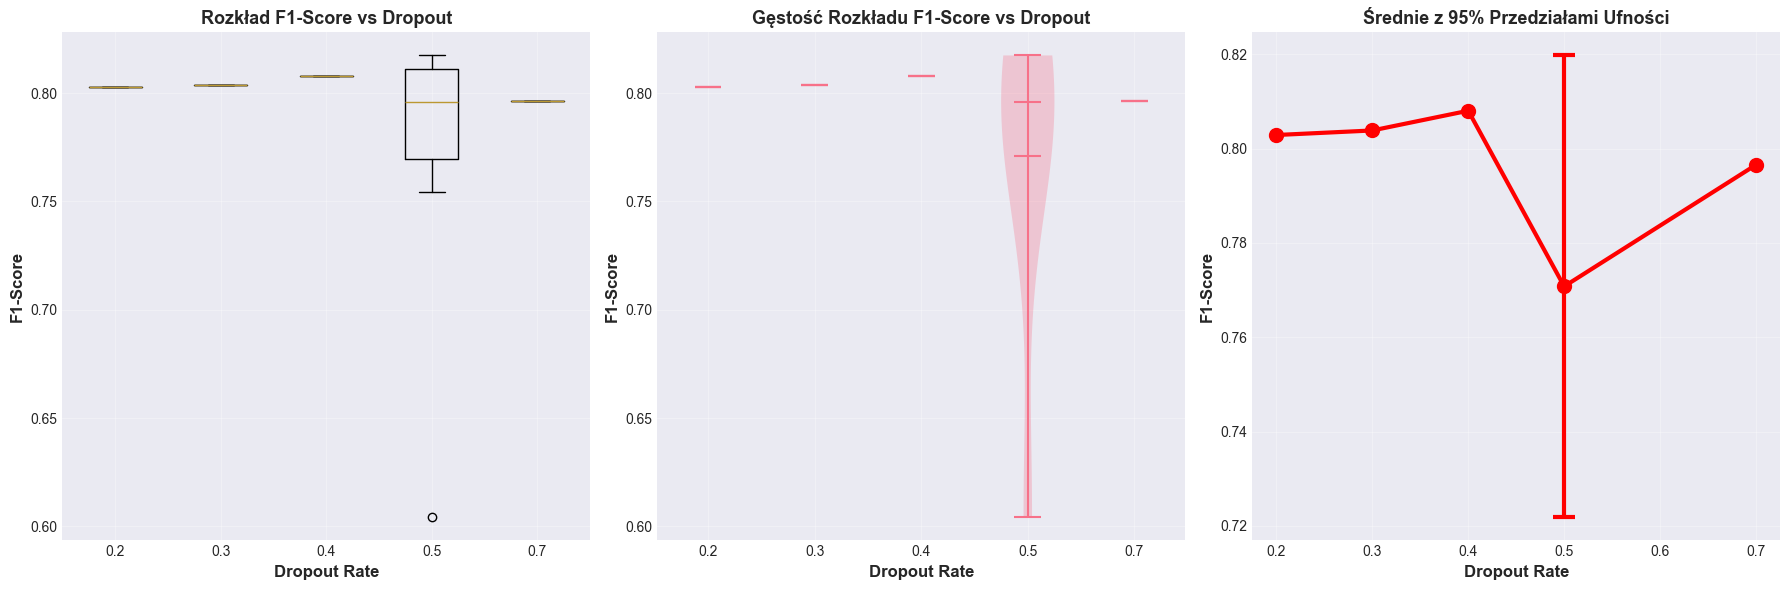


✅ Test ANOVA dla Dropout:
   F-statistic: 0.1405
   P-value: 0.9617
   ℹ️  Dropout NIE ma istotnego wpływu statystycznego (p >= 0.05)

📈 Statystyki dla Dropout:
             mean       std  count        ci
dropout                                     
0.2      0.802870       NaN      1       NaN
0.3      0.803832       NaN      1       NaN
0.4      0.808015       NaN      1       NaN
0.5      0.770782  0.070646      8  0.048955
0.7      0.796553       NaN      1       NaN

📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 
2. ANALIZA WPŁYWU LEARNING RATE
📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 


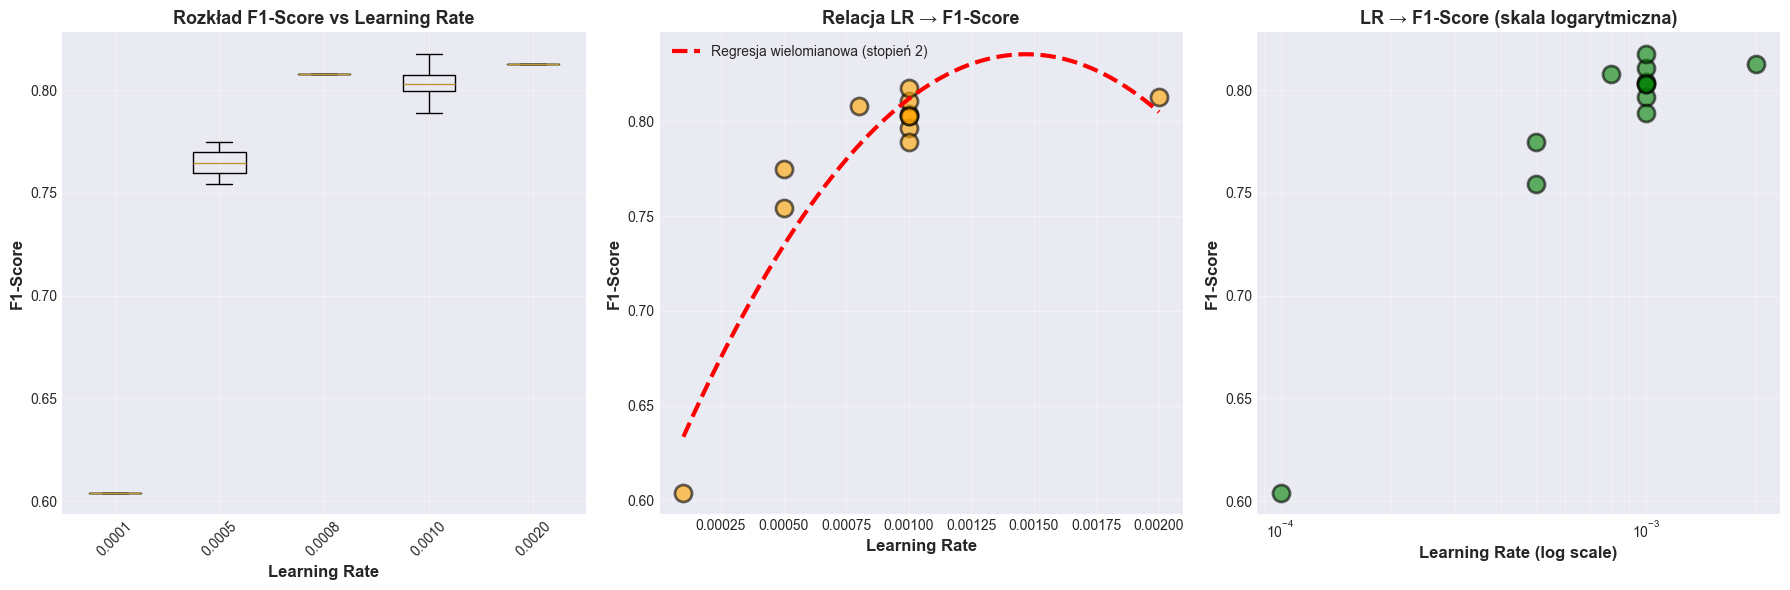


✅ Test ANOVA dla Learning Rate:
   F-statistic: 90.7505
   P-value: 0.0000
   ⚠️  Learning Rate ma ISTOTNY wpływ statystyczny na F1-Score (p < 0.05)

📈 Statystyki dla Learning Rate:
                   mean       std  count       min       max
learning_rate                                               
0.0001         0.604200       NaN      1  0.604200  0.604200
0.0005         0.764600  0.014537      2  0.754320  0.774879
0.0008         0.808015       NaN      1  0.808015  0.808015
0.0010         0.803321  0.009153      7  0.789079  0.817421
0.0020         0.812863       NaN      1  0.812863  0.812863

📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 
3. ANALIZA WPŁYWU BATCH SIZE
📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 📊 


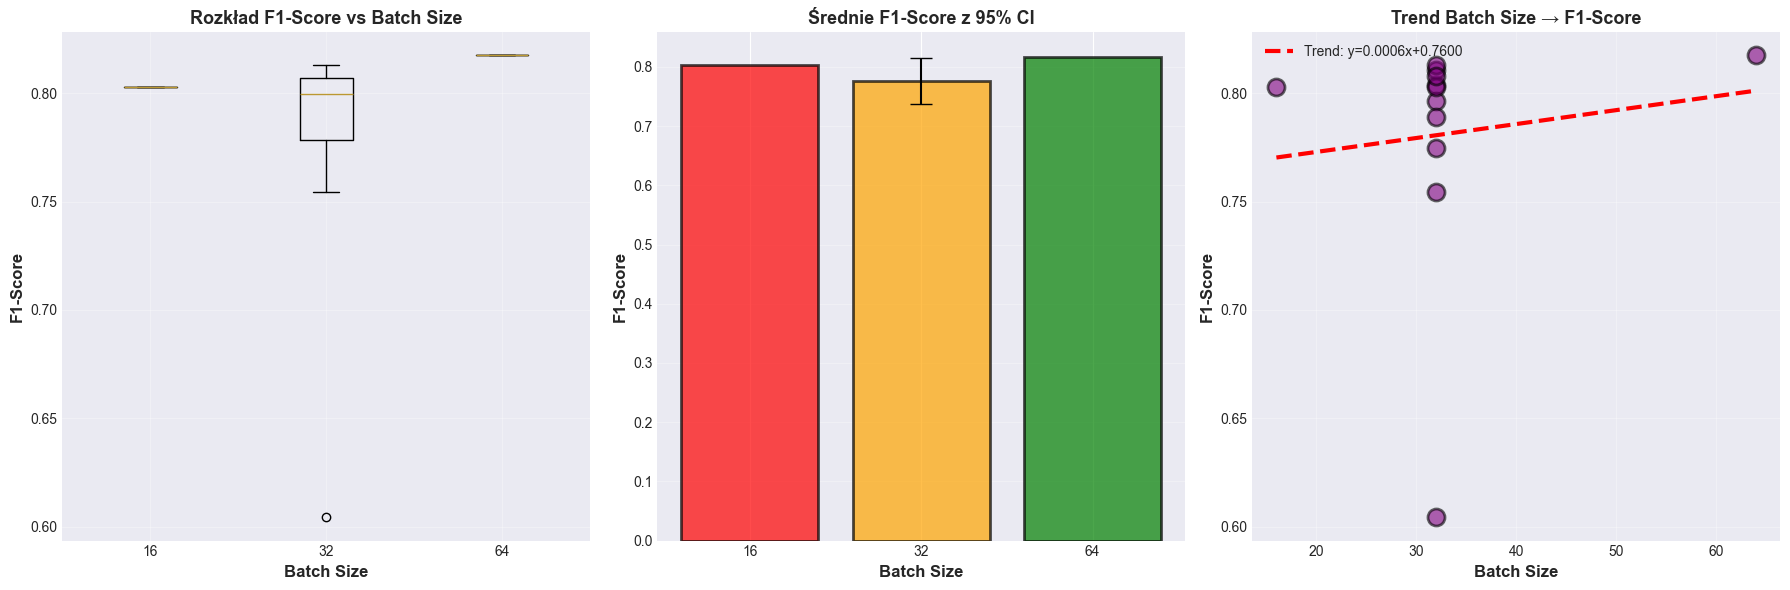


✅ Test ANOVA dla Batch Size:
   F-statistic: 0.2620
   P-value: 0.7752
   ℹ️  Batch Size NIE ma istotnego wpływu statystycznego (p >= 0.05)

📈 Statystyki dla Batch Size:
                mean      std  count        ci
batch_size                                    
16          0.802789      NaN      1       NaN
32          0.775732  0.06295     10  0.039017
64          0.817421      NaN      1       NaN



In [30]:
from scipy import stats
from scipy.stats import f_oneway
from itertools import combinations

print("=" * 100)
print("SZCZEGÓŁOWA ANALIZA STATYSTYCZNA WPŁYWU PARAMETRÓW")
print("=" * 100)

if len(param_df) > 0:
    # ============================================================================
    # 1. ANALIZA DROPOUT RATE
    # ============================================================================
    print("\n" + "📊 " * 40)
    print("1. ANALIZA WPŁYWU DROPOUT RATE")
    print("📊 " * 40)
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Boxplot
    dropout_data = [param_df[param_df['dropout'] == d]['f1_score'].values 
                    for d in sorted(param_df['dropout'].unique())]
    axes[0].boxplot(dropout_data, labels=sorted(param_df['dropout'].unique()))
    axes[0].set_xlabel('Dropout Rate', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('F1-Score', fontsize=12, fontweight='bold')
    axes[0].set_title('Rozkład F1-Score vs Dropout', fontsize=13, fontweight='bold')
    axes[0].grid(True, alpha=0.3)
    
    # Violin plot
    dropout_values = sorted(param_df['dropout'].unique())
    positions = range(len(dropout_values))
    parts = axes[1].violinplot(dropout_data, positions=positions, showmeans=True, showmedians=True)
    axes[1].set_xticks(positions)
    axes[1].set_xticklabels(dropout_values)
    axes[1].set_xlabel('Dropout Rate', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('F1-Score', fontsize=12, fontweight='bold')
    axes[1].set_title('Gęstość Rozkładu F1-Score vs Dropout', fontsize=13, fontweight='bold')
    axes[1].grid(True, alpha=0.3)
    
    # Średnie z przedziałami ufności
    dropout_stats = param_df.groupby('dropout')['f1_score'].agg(['mean', 'std', 'count'])
    dropout_stats['ci'] = 1.96 * dropout_stats['std'] / np.sqrt(dropout_stats['count'])
    axes[2].errorbar(dropout_stats.index, dropout_stats['mean'], 
                     yerr=dropout_stats['ci'], marker='o', markersize=10,
                     capsize=8, capthick=3, linewidth=3, color='red')
    axes[2].fill_between(dropout_stats.index, 
                         dropout_stats['mean'] - dropout_stats['ci'],
                         dropout_stats['mean'] + dropout_stats['ci'],
                         alpha=0.3, color='red')
    axes[2].set_xlabel('Dropout Rate', fontsize=12, fontweight='bold')
    axes[2].set_ylabel('F1-Score', fontsize=12, fontweight='bold')
    axes[2].set_title('Średnie z 95% Przedziałami Ufności', fontsize=13, fontweight='bold')
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'{results_dir}/dropout_analysis_detailed.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Test ANOVA
    if len(dropout_data) > 2 and all(len(d) > 0 for d in dropout_data):
        f_stat, p_value = f_oneway(*dropout_data)
        print(f"\n✅ Test ANOVA dla Dropout:")
        print(f"   F-statistic: {f_stat:.4f}")
        print(f"   P-value: {p_value:.4f}")
        if p_value < 0.05:
            print(f"   ⚠️  Dropout ma ISTOTNY wpływ statystyczny na F1-Score (p < 0.05)")
        else:
            print(f"   ℹ️  Dropout NIE ma istotnego wpływu statystycznego (p >= 0.05)")
    
    print(f"\n📈 Statystyki dla Dropout:")
    print(dropout_stats.to_string())
    
    # ============================================================================
    # 2. ANALIZA LEARNING RATE
    # ============================================================================
    print("\n" + "📊 " * 40)
    print("2. ANALIZA WPŁYWU LEARNING RATE")
    print("📊 " * 40)
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Boxplot (log scale)
    lr_data = [param_df[param_df['learning_rate'] == lr]['f1_score'].values 
               for lr in sorted(param_df['learning_rate'].unique())]
    axes[0].boxplot(lr_data, labels=[f"{lr:.4f}" for lr in sorted(param_df['learning_rate'].unique())])
    axes[0].set_xlabel('Learning Rate', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('F1-Score', fontsize=12, fontweight='bold')
    axes[0].set_title('Rozkład F1-Score vs Learning Rate', fontsize=13, fontweight='bold')
    axes[0].tick_params(axis='x', rotation=45)
    axes[0].grid(True, alpha=0.3)
    
    # Scatter z regresją
    axes[1].scatter(param_df['learning_rate'], param_df['f1_score'], 
                   s=150, alpha=0.6, c='orange', edgecolors='black', linewidth=2)
    z = np.polyfit(param_df['learning_rate'], param_df['f1_score'], 2)
    p = np.poly1d(z)
    lr_range = np.linspace(param_df['learning_rate'].min(), param_df['learning_rate'].max(), 100)
    axes[1].plot(lr_range, p(lr_range), "r--", linewidth=3, label='Regresja wielomianowa (stopień 2)')
    axes[1].set_xlabel('Learning Rate', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('F1-Score', fontsize=12, fontweight='bold')
    axes[1].set_title('Relacja LR → F1-Score', fontsize=13, fontweight='bold')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # Log scale
    axes[2].scatter(param_df['learning_rate'], param_df['f1_score'], 
                   s=150, alpha=0.6, c='green', edgecolors='black', linewidth=2)
    axes[2].set_xscale('log')
    axes[2].set_xlabel('Learning Rate (log scale)', fontsize=12, fontweight='bold')
    axes[2].set_ylabel('F1-Score', fontsize=12, fontweight='bold')
    axes[2].set_title('LR → F1-Score (skala logarytmiczna)', fontsize=13, fontweight='bold')
    axes[2].grid(True, alpha=0.3, which='both')
    
    plt.tight_layout()
    plt.savefig(f'{results_dir}/learning_rate_analysis_detailed.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Test ANOVA
    if len(lr_data) > 2 and all(len(d) > 0 for d in lr_data):
        f_stat, p_value = f_oneway(*lr_data)
        print(f"\n✅ Test ANOVA dla Learning Rate:")
        print(f"   F-statistic: {f_stat:.4f}")
        print(f"   P-value: {p_value:.4f}")
        if p_value < 0.05:
            print(f"   ⚠️  Learning Rate ma ISTOTNY wpływ statystyczny na F1-Score (p < 0.05)")
        else:
            print(f"   ℹ️  Learning Rate NIE ma istotnego wpływu statystycznego (p >= 0.05)")
    
    lr_stats = param_df.groupby('learning_rate')['f1_score'].agg(['mean', 'std', 'count', 'min', 'max'])
    print(f"\n📈 Statystyki dla Learning Rate:")
    print(lr_stats.to_string())
    
    # ============================================================================
    # 3. ANALIZA BATCH SIZE
    # ============================================================================
    print("\n" + "📊 " * 40)
    print("3. ANALIZA WPŁYWU BATCH SIZE")
    print("📊 " * 40)
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Boxplot
    batch_data = [param_df[param_df['batch_size'] == bs]['f1_score'].values 
                  for bs in sorted(param_df['batch_size'].unique())]
    axes[0].boxplot(batch_data, labels=sorted(param_df['batch_size'].unique()))
    axes[0].set_xlabel('Batch Size', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('F1-Score', fontsize=12, fontweight='bold')
    axes[0].set_title('Rozkład F1-Score vs Batch Size', fontsize=13, fontweight='bold')
    axes[0].grid(True, alpha=0.3)
    
    # Bar plot z error bars
    batch_stats = param_df.groupby('batch_size')['f1_score'].agg(['mean', 'std', 'count'])
    batch_stats['ci'] = 1.96 * batch_stats['std'] / np.sqrt(batch_stats['count'])
    axes[1].bar(batch_stats.index.astype(str), batch_stats['mean'], 
               yerr=batch_stats['ci'], capsize=8, color=['red', 'orange', 'green'],
               alpha=0.7, edgecolor='black', linewidth=2)
    axes[1].set_xlabel('Batch Size', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('F1-Score', fontsize=12, fontweight='bold')
    axes[1].set_title('Średnie F1-Score z 95% CI', fontsize=13, fontweight='bold')
    axes[1].grid(True, alpha=0.3, axis='y')
    
    # Scatter z trendem
    axes[2].scatter(param_df['batch_size'], param_df['f1_score'], 
                   s=150, alpha=0.6, c='purple', edgecolors='black', linewidth=2)
    z = np.polyfit(param_df['batch_size'], param_df['f1_score'], 1)
    p = np.poly1d(z)
    bs_range = np.linspace(param_df['batch_size'].min(), param_df['batch_size'].max(), 100)
    axes[2].plot(bs_range, p(bs_range), "r--", linewidth=3, label=f'Trend: y={z[0]:.4f}x+{z[1]:.4f}')
    axes[2].set_xlabel('Batch Size', fontsize=12, fontweight='bold')
    axes[2].set_ylabel('F1-Score', fontsize=12, fontweight='bold')
    axes[2].set_title('Trend Batch Size → F1-Score', fontsize=13, fontweight='bold')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'{results_dir}/batch_size_analysis_detailed.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Test ANOVA
    if len(batch_data) > 2 and all(len(d) > 0 for d in batch_data):
        f_stat, p_value = f_oneway(*batch_data)
        print(f"\n✅ Test ANOVA dla Batch Size:")
        print(f"   F-statistic: {f_stat:.4f}")
        print(f"   P-value: {p_value:.4f}")
        if p_value < 0.05:
            print(f"   ⚠️  Batch Size ma ISTOTNY wpływ statystyczny na F1-Score (p < 0.05)")
        else:
            print(f"   ℹ️  Batch Size NIE ma istotnego wpływu statystycznego (p >= 0.05)")
    
    print(f"\n📈 Statystyki dla Batch Size:")
    print(batch_stats.to_string())
    
    print("\n" + "=" * 100)
    
else:
    print("Brak danych MLP do analizy parametrów.")

4. ANALIZA WPŁYWU MAX FEATURES (TF-IDF)


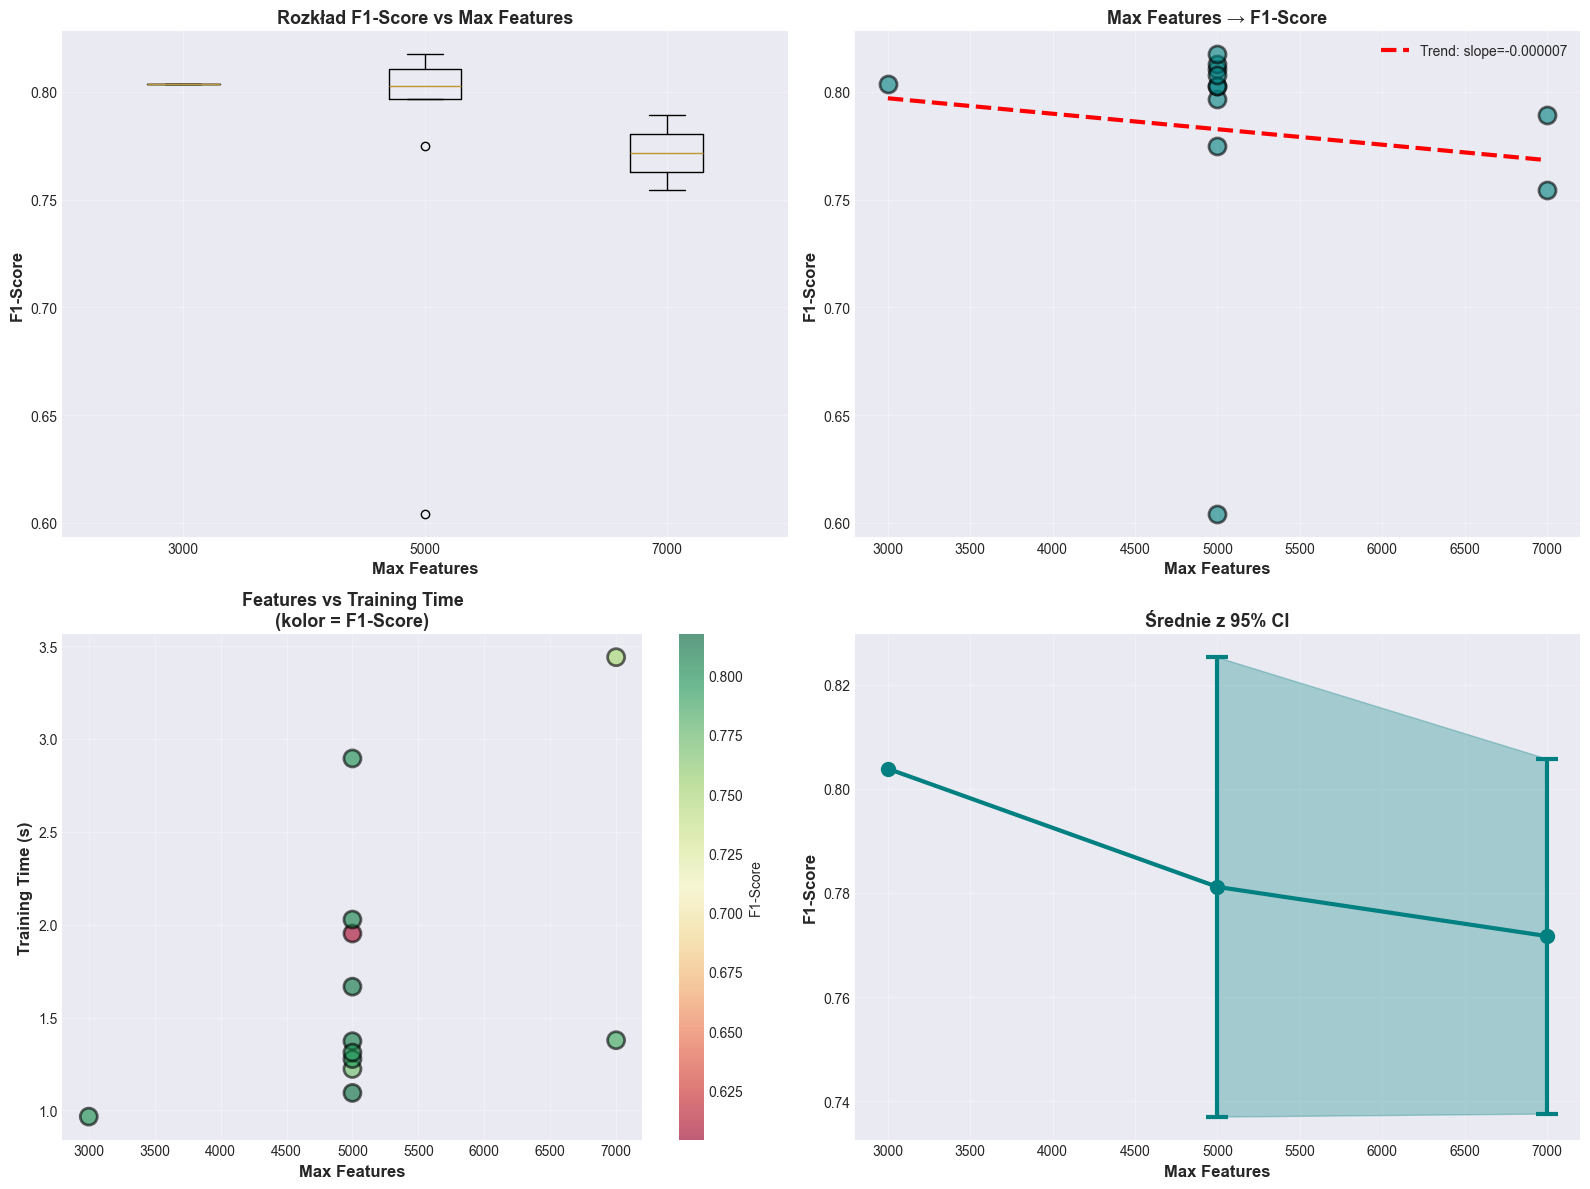


✅ Test ANOVA dla Max Features:
   F-statistic: 0.0840
   P-value: 0.9201
   ℹ️  Max Features NIE ma istotnego wpływu statystycznego (p >= 0.05)

📈 Statystyki dla Max Features:
                  mean       std  count        ci
max_features                                     
3000          0.803832       NaN      1       NaN
5000          0.781144  0.067495      9  0.044096
7000          0.771700  0.024578      2  0.034063

5. ANALIZA WPŁYWU ARCHITEKTURY SIECI


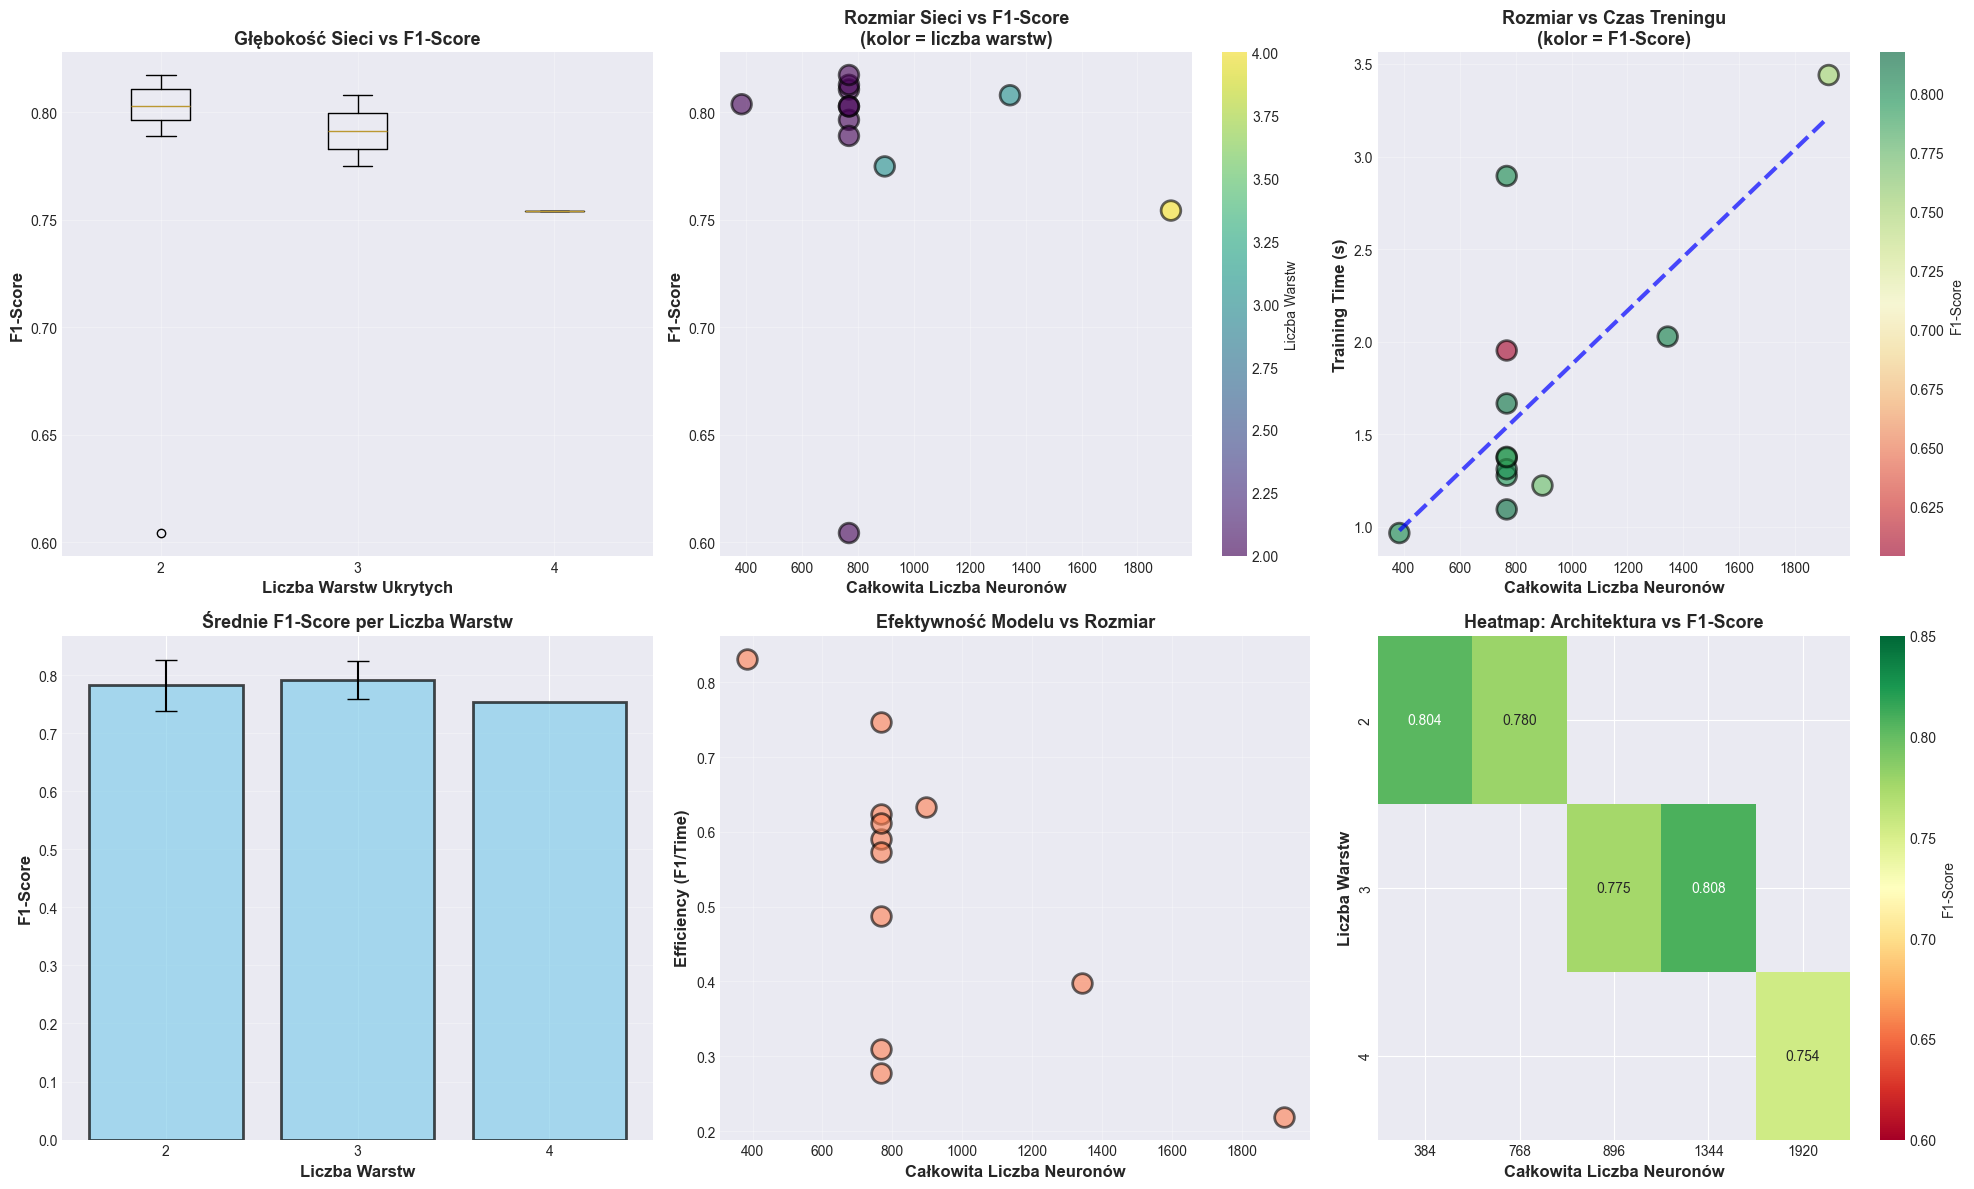


✅ Test ANOVA dla Liczby Warstw:
   F-statistic: 0.1152
   P-value: 0.8925
   ℹ️  Liczba warstw NIE ma istotnego wpływu statystycznego (p >= 0.05)

📈 Statystyki dla Liczby Warstw:
                mean       std  count        ci
num_layers                                     
2           0.782257  0.067314      9  0.043978
3           0.791447  0.023431      2  0.032474
4           0.754320       NaN      1       NaN

🔗 Korelacja całkowitej liczby neuronów z F1-Score: -0.1020



In [31]:
if len(param_df) > 0:
    # ============================================================================
    # 4. ANALIZA MAX FEATURES (TF-IDF)
    # ============================================================================
    print("=" * 100)
    print("4. ANALIZA WPŁYWU MAX FEATURES (TF-IDF)")
    print("=" * 100)
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Boxplot
    features_data = [param_df[param_df['max_features'] == f]['f1_score'].values 
                     for f in sorted(param_df['max_features'].unique())]
    axes[0, 0].boxplot(features_data, labels=sorted(param_df['max_features'].unique()))
    axes[0, 0].set_xlabel('Max Features', fontsize=12, fontweight='bold')
    axes[0, 0].set_ylabel('F1-Score', fontsize=12, fontweight='bold')
    axes[0, 0].set_title('Rozkład F1-Score vs Max Features', fontsize=13, fontweight='bold')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Scatter z trendem
    axes[0, 1].scatter(param_df['max_features'], param_df['f1_score'], 
                      s=150, alpha=0.6, c='teal', edgecolors='black', linewidth=2)
    z = np.polyfit(param_df['max_features'], param_df['f1_score'], 1)
    p = np.poly1d(z)
    feat_range = np.linspace(param_df['max_features'].min(), param_df['max_features'].max(), 100)
    axes[0, 1].plot(feat_range, p(feat_range), "r--", linewidth=3, 
                   label=f'Trend: slope={z[0]:.6f}')
    axes[0, 1].set_xlabel('Max Features', fontsize=12, fontweight='bold')
    axes[0, 1].set_ylabel('F1-Score', fontsize=12, fontweight='bold')
    axes[0, 1].set_title('Max Features → F1-Score', fontsize=13, fontweight='bold')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Features vs Training Time
    axes[1, 0].scatter(param_df['max_features'], param_df['training_time'], 
                      s=150, alpha=0.6, c=param_df['f1_score'], cmap='RdYlGn',
                      edgecolors='black', linewidth=2)
    axes[1, 0].set_xlabel('Max Features', fontsize=12, fontweight='bold')
    axes[1, 0].set_ylabel('Training Time (s)', fontsize=12, fontweight='bold')
    axes[1, 0].set_title('Features vs Training Time\n(kolor = F1-Score)', fontsize=13, fontweight='bold')
    cbar = plt.colorbar(axes[1, 0].collections[0], ax=axes[1, 0])
    cbar.set_label('F1-Score', fontsize=10)
    axes[1, 0].grid(True, alpha=0.3)
    
    # Statystyki
    features_stats = param_df.groupby('max_features')['f1_score'].agg(['mean', 'std', 'count'])
    features_stats['ci'] = 1.96 * features_stats['std'] / np.sqrt(features_stats['count'])
    axes[1, 1].errorbar(features_stats.index, features_stats['mean'], 
                       yerr=features_stats['ci'], marker='o', markersize=10,
                       capsize=8, capthick=3, linewidth=3, color='teal')
    axes[1, 1].fill_between(features_stats.index, 
                           features_stats['mean'] - features_stats['ci'],
                           features_stats['mean'] + features_stats['ci'],
                           alpha=0.3, color='teal')
    axes[1, 1].set_xlabel('Max Features', fontsize=12, fontweight='bold')
    axes[1, 1].set_ylabel('F1-Score', fontsize=12, fontweight='bold')
    axes[1, 1].set_title('Średnie z 95% CI', fontsize=13, fontweight='bold')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'{results_dir}/max_features_analysis_detailed.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Test ANOVA
    if len(features_data) > 2 and all(len(d) > 0 for d in features_data):
        f_stat, p_value = f_oneway(*features_data)
        print(f"\n✅ Test ANOVA dla Max Features:")
        print(f"   F-statistic: {f_stat:.4f}")
        print(f"   P-value: {p_value:.4f}")
        if p_value < 0.05:
            print(f"   ⚠️  Max Features ma ISTOTNY wpływ statystyczny (p < 0.05)")
        else:
            print(f"   ℹ️  Max Features NIE ma istotnego wpływu statystycznego (p >= 0.05)")
    
    print(f"\n📈 Statystyki dla Max Features:")
    print(features_stats.to_string())
    
    # ============================================================================
    # 5. ANALIZA ARCHITEKTURY SIECI
    # ============================================================================
    print("\n" + "=" * 100)
    print("5. ANALIZA WPŁYWU ARCHITEKTURY SIECI")
    print("=" * 100)
    
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    
    # Liczba warstw vs F1-Score
    layers_data = [param_df[param_df['num_layers'] == l]['f1_score'].values 
                   for l in sorted(param_df['num_layers'].unique())]
    axes[0, 0].boxplot(layers_data, labels=sorted(param_df['num_layers'].unique()))
    axes[0, 0].set_xlabel('Liczba Warstw Ukrytych', fontsize=12, fontweight='bold')
    axes[0, 0].set_ylabel('F1-Score', fontsize=12, fontweight='bold')
    axes[0, 0].set_title('Głębokość Sieci vs F1-Score', fontsize=13, fontweight='bold')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Całkowita liczba neuronów vs F1-Score
    axes[0, 1].scatter(param_df['total_neurons'], param_df['f1_score'], 
                      s=200, alpha=0.6, c=param_df['num_layers'], cmap='viridis',
                      edgecolors='black', linewidth=2)
    axes[0, 1].set_xlabel('Całkowita Liczba Neuronów', fontsize=12, fontweight='bold')
    axes[0, 1].set_ylabel('F1-Score', fontsize=12, fontweight='bold')
    axes[0, 1].set_title('Rozmiar Sieci vs F1-Score\n(kolor = liczba warstw)', fontsize=13, fontweight='bold')
    cbar = plt.colorbar(axes[0, 1].collections[0], ax=axes[0, 1])
    cbar.set_label('Liczba Warstw', fontsize=10)
    axes[0, 1].grid(True, alpha=0.3)
    
    # Neurony vs Training Time
    axes[0, 2].scatter(param_df['total_neurons'], param_df['training_time'], 
                      s=200, alpha=0.6, c=param_df['f1_score'], cmap='RdYlGn',
                      edgecolors='black', linewidth=2)
    z = np.polyfit(param_df['total_neurons'], param_df['training_time'], 1)
    p = np.poly1d(z)
    neuron_range = np.linspace(param_df['total_neurons'].min(), param_df['total_neurons'].max(), 100)
    axes[0, 2].plot(neuron_range, p(neuron_range), "b--", linewidth=3, alpha=0.7)
    axes[0, 2].set_xlabel('Całkowita Liczba Neuronów', fontsize=12, fontweight='bold')
    axes[0, 2].set_ylabel('Training Time (s)', fontsize=12, fontweight='bold')
    axes[0, 2].set_title('Rozmiar vs Czas Treningu\n(kolor = F1-Score)', fontsize=13, fontweight='bold')
    cbar = plt.colorbar(axes[0, 2].collections[0], ax=axes[0, 2])
    cbar.set_label('F1-Score', fontsize=10)
    axes[0, 2].grid(True, alpha=0.3)
    
    # Średnie per liczba warstw
    layers_stats = param_df.groupby('num_layers')['f1_score'].agg(['mean', 'std', 'count'])
    layers_stats['ci'] = 1.96 * layers_stats['std'] / np.sqrt(layers_stats['count'])
    axes[1, 0].bar(layers_stats.index.astype(str), layers_stats['mean'], 
                  yerr=layers_stats['ci'], capsize=8, color='skyblue',
                  alpha=0.7, edgecolor='black', linewidth=2)
    axes[1, 0].set_xlabel('Liczba Warstw', fontsize=12, fontweight='bold')
    axes[1, 0].set_ylabel('F1-Score', fontsize=12, fontweight='bold')
    axes[1, 0].set_title('Średnie F1-Score per Liczba Warstw', fontsize=13, fontweight='bold')
    axes[1, 0].grid(True, alpha=0.3, axis='y')
    
    # Efficiency Score: F1 / Training Time
    param_df['efficiency'] = param_df['f1_score'] / param_df['training_time']
    axes[1, 1].scatter(param_df['total_neurons'], param_df['efficiency'], 
                      s=200, alpha=0.6, c='coral', edgecolors='black', linewidth=2)
    axes[1, 1].set_xlabel('Całkowita Liczba Neuronów', fontsize=12, fontweight='bold')
    axes[1, 1].set_ylabel('Efficiency (F1/Time)', fontsize=12, fontweight='bold')
    axes[1, 1].set_title('Efektywność Modelu vs Rozmiar', fontsize=13, fontweight='bold')
    axes[1, 1].grid(True, alpha=0.3)
    
    # Heatmap: Layers vs Total Neurons
    pivot_table = param_df.pivot_table(values='f1_score', 
                                       index='num_layers', 
                                       columns='total_neurons', 
                                       aggfunc='mean')
    sns.heatmap(pivot_table, annot=True, fmt='.3f', cmap='RdYlGn', 
                vmin=0.6, vmax=0.85, ax=axes[1, 2], cbar_kws={'label': 'F1-Score'})
    axes[1, 2].set_xlabel('Całkowita Liczba Neuronów', fontsize=12, fontweight='bold')
    axes[1, 2].set_ylabel('Liczba Warstw', fontsize=12, fontweight='bold')
    axes[1, 2].set_title('Heatmap: Architektura vs F1-Score', fontsize=13, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(f'{results_dir}/architecture_analysis_detailed.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Test ANOVA dla liczby warstw
    if len(layers_data) > 2 and all(len(d) > 0 for d in layers_data):
        f_stat, p_value = f_oneway(*layers_data)
        print(f"\n✅ Test ANOVA dla Liczby Warstw:")
        print(f"   F-statistic: {f_stat:.4f}")
        print(f"   P-value: {p_value:.4f}")
        if p_value < 0.05:
            print(f"   ⚠️  Liczba warstw ma ISTOTNY wpływ statystyczny (p < 0.05)")
        else:
            print(f"   ℹ️  Liczba warstw NIE ma istotnego wpływu statystycznego (p >= 0.05)")
    
    print(f"\n📈 Statystyki dla Liczby Warstw:")
    print(layers_stats.to_string())
    
    # Korelacja rozmiaru sieci z F1
    corr_neurons = param_df[['total_neurons', 'f1_score']].corr().iloc[0, 1]
    print(f"\n🔗 Korelacja całkowitej liczby neuronów z F1-Score: {corr_neurons:.4f}")
    
    print("\n" + "=" * 100)

6. MACIERZ KORELACJI PARAMETRÓW


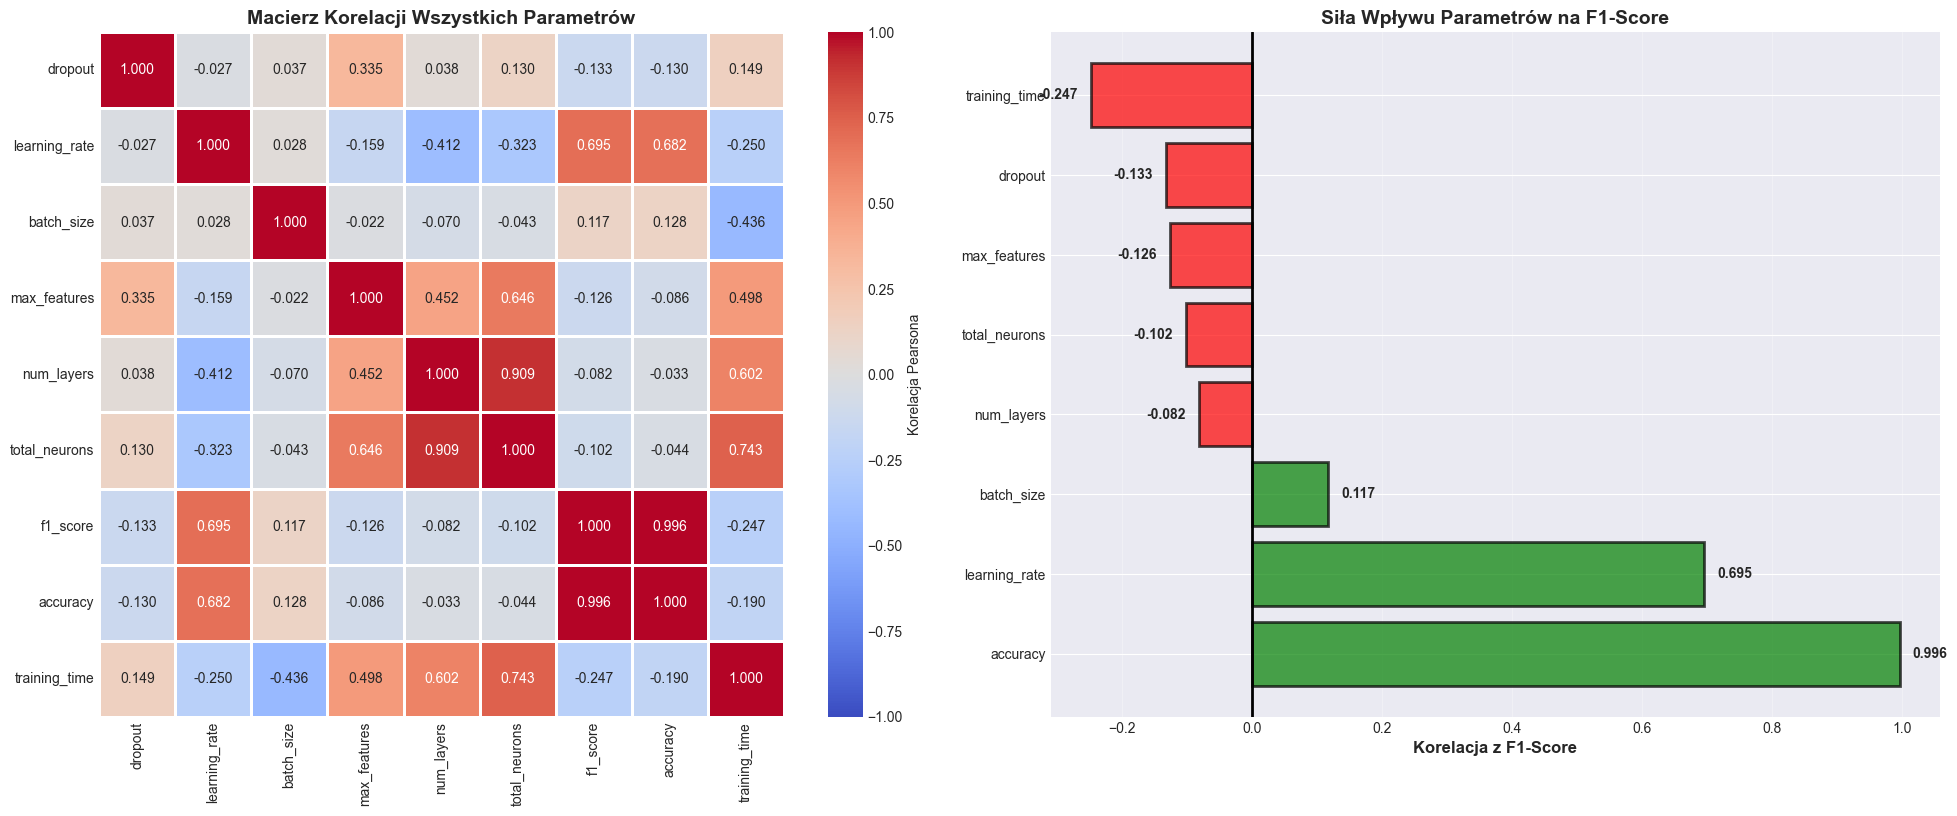


📊 Top 3 parametry pozytywnie korelujące z F1-Score:
   • accuracy: +0.9959
   • learning_rate: +0.6950
   • batch_size: +0.1174

📊 Top 3 parametry negatywnie korelujące z F1-Score:
   • max_features: -0.1263
   • dropout: -0.1328
   • training_time: -0.2474

7. ANALIZA PAR PARAMETRÓW (SCATTER MATRIX)


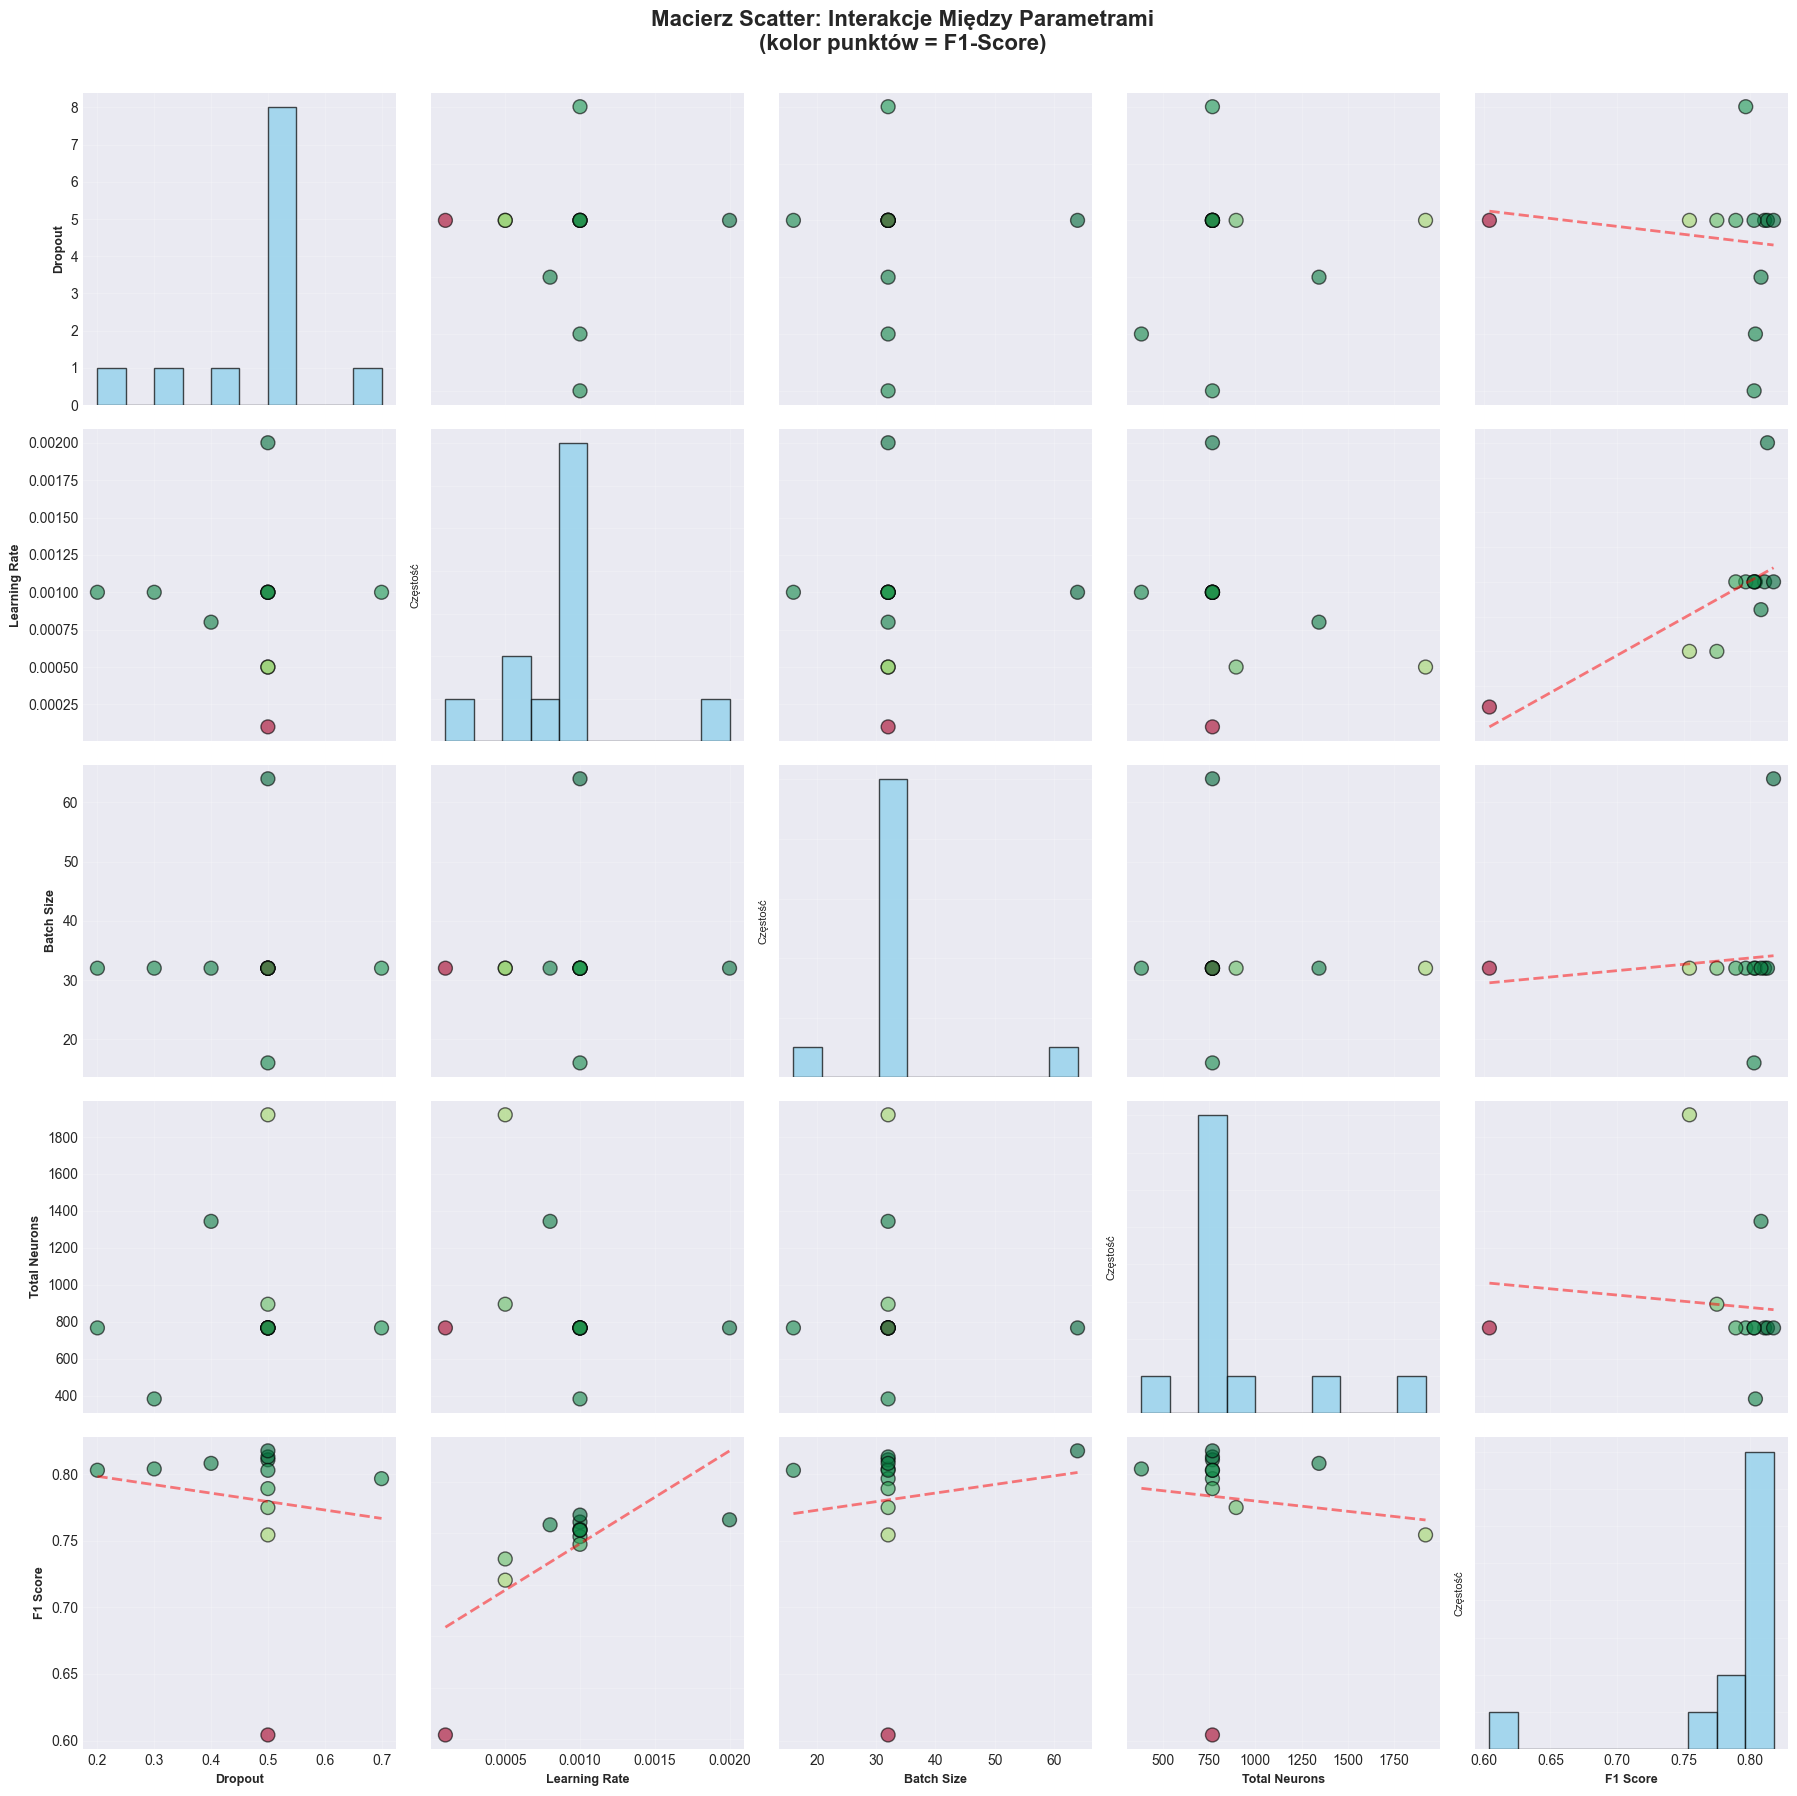


8. ANALIZA INTERAKCJI: DROPOUT × LEARNING RATE


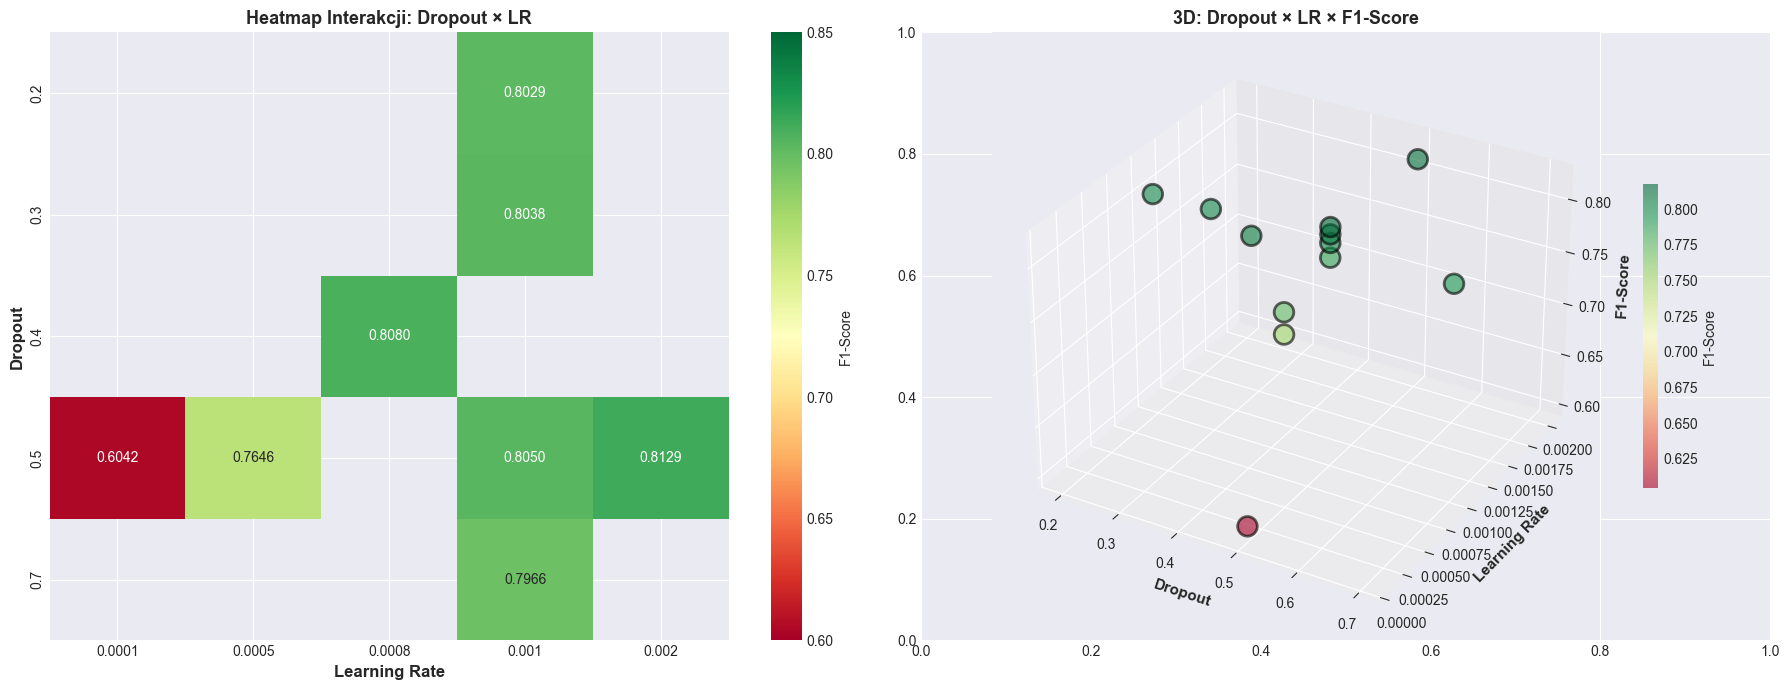


✅ Najlepsza kombinacja Dropout × LR:
   Dropout: 0.5, LR: 0.001 → F1: 0.8174

9. PODSUMOWANIE TESTÓW STATYSTYCZNYCH


     Parametr  Test Statystyka P-value Istotny (p<0.05) Korelacja
      Dropout ANOVA     0.1405  0.9617            ❌ NIE   -0.1328
Learning Rate ANOVA    90.7505  0.0000            ✅ TAK   +0.6950
   Batch Size ANOVA     0.2620  0.7752            ❌ NIE   +0.1174
 Max Features ANOVA     0.0840  0.9201            ❌ NIE   -0.1263
Liczba Warstw ANOVA     0.1152  0.8925            ❌ NIE   -0.0817

✅ Podsumowanie testów zapisane do: ./analysis_results/statistical_tests_summary.csv

✅ ANALIZA PARAMETRÓW ZAKOŃCZONA - WSZYSTKIE WYKRESY ZAPISANE


In [32]:
if len(param_df) > 0:
    # ============================================================================
    # 6. MACIERZ KORELACJI WSZYSTKICH PARAMETRÓW
    # ============================================================================
    print("=" * 100)
    print("6. MACIERZ KORELACJI PARAMETRÓW")
    print("=" * 100)
    
    # Wybierz kolumny numeryczne
    numeric_cols = ['dropout', 'learning_rate', 'batch_size', 'max_features', 
                   'num_layers', 'total_neurons', 'f1_score', 'accuracy', 'training_time']
    corr_matrix = param_df[numeric_cols].corr()
    
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    
    # Pełna macierz korelacji
    sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='coolwarm', 
                center=0, vmin=-1, vmax=1, square=True, ax=axes[0],
                cbar_kws={'label': 'Korelacja Pearsona'}, linewidths=1)
    axes[0].set_title('Macierz Korelacji Wszystkich Parametrów', fontsize=14, fontweight='bold')
    
    # Korelacje tylko z F1-Score (posortowane)
    f1_corr = corr_matrix['f1_score'].drop('f1_score').sort_values(ascending=False)
    colors = ['green' if x > 0 else 'red' for x in f1_corr.values]
    axes[1].barh(range(len(f1_corr)), f1_corr.values, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
    axes[1].set_yticks(range(len(f1_corr)))
    axes[1].set_yticklabels(f1_corr.index)
    axes[1].set_xlabel('Korelacja z F1-Score', fontsize=12, fontweight='bold')
    axes[1].set_title('Siła Wpływu Parametrów na F1-Score', fontsize=14, fontweight='bold')
    axes[1].axvline(x=0, color='black', linestyle='-', linewidth=2)
    axes[1].grid(True, alpha=0.3, axis='x')
    
    # Dodaj wartości na słupkach
    for i, v in enumerate(f1_corr.values):
        axes[1].text(v + 0.02 if v > 0 else v - 0.02, i, f'{v:.3f}', 
                    va='center', ha='left' if v > 0 else 'right', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(f'{results_dir}/correlation_matrix_detailed.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\n📊 Top 3 parametry pozytywnie korelujące z F1-Score:")
    for param, corr in f1_corr.head(3).items():
        print(f"   • {param}: {corr:+.4f}")
    
    print("\n📊 Top 3 parametry negatywnie korelujące z F1-Score:")
    for param, corr in f1_corr.tail(3).items():
        print(f"   • {param}: {corr:+.4f}")
    
    # ============================================================================
    # 7. SCATTER MATRIX - PARY PARAMETRÓW
    # ============================================================================
    print("\n" + "=" * 100)
    print("7. ANALIZA PAR PARAMETRÓW (SCATTER MATRIX)")
    print("=" * 100)
    
    # Wybierz najważniejsze parametry
    key_params = ['dropout', 'learning_rate', 'batch_size', 'total_neurons', 'f1_score']
    
    fig = plt.figure(figsize=(18, 18))
    
    n_params = len(key_params)
    for i, param1 in enumerate(key_params):
        for j, param2 in enumerate(key_params):
            ax = plt.subplot(n_params, n_params, i * n_params + j + 1)
            
            if i == j:
                # Histogram na przekątnej
                ax.hist(param_df[param1], bins=10, alpha=0.7, color='skyblue', edgecolor='black')
                ax.set_ylabel('Częstość', fontsize=8)
            else:
                # Scatter plot poza przekątną
                scatter = ax.scatter(param_df[param2], param_df[param1], 
                                   c=param_df['f1_score'], cmap='RdYlGn',
                                   s=100, alpha=0.6, edgecolors='black', linewidth=1)
                
                # Dodaj linię trendu dla par z F1-score
                if param1 == 'f1_score' or param2 == 'f1_score':
                    z = np.polyfit(param_df[param2], param_df[param1], 1)
                    p = np.poly1d(z)
                    x_line = np.linspace(param_df[param2].min(), param_df[param2].max(), 100)
                    ax.plot(x_line, p(x_line), "r--", linewidth=2, alpha=0.5)
            
            # Etykiety
            if i == n_params - 1:
                ax.set_xlabel(param2.replace('_', ' ').title(), fontsize=9, fontweight='bold')
            else:
                ax.set_xticklabels([])
            
            if j == 0:
                ax.set_ylabel(param1.replace('_', ' ').title(), fontsize=9, fontweight='bold')
            else:
                ax.set_yticklabels([])
            
            ax.grid(True, alpha=0.2)
    
    plt.suptitle('Macierz Scatter: Interakcje Między Parametrami\n(kolor punktów = F1-Score)', 
                fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout(rect=[0, 0, 1, 0.99])
    plt.savefig(f'{results_dir}/scatter_matrix_parameters.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # ============================================================================
    # 8. ANALIZA INTERAKCJI DROPOUT × LEARNING RATE
    # ============================================================================
    print("\n" + "=" * 100)
    print("8. ANALIZA INTERAKCJI: DROPOUT × LEARNING RATE")
    print("=" * 100)
    
    fig, axes = plt.subplots(1, 2, figsize=(18, 7))
    
    # Heatmap interakcji
    interaction_pivot = param_df.pivot_table(values='f1_score', 
                                             index='dropout', 
                                             columns='learning_rate', 
                                             aggfunc='mean')
    sns.heatmap(interaction_pivot, annot=True, fmt='.4f', cmap='RdYlGn', 
                vmin=0.6, vmax=0.85, ax=axes[0], cbar_kws={'label': 'F1-Score'})
    axes[0].set_xlabel('Learning Rate', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Dropout', fontsize=12, fontweight='bold')
    axes[0].set_title('Heatmap Interakcji: Dropout × LR', fontsize=13, fontweight='bold')
    
    # 3D scatter
    from mpl_toolkits.mplot3d import Axes3D
    ax3d = fig.add_subplot(122, projection='3d')
    scatter = ax3d.scatter(param_df['dropout'], param_df['learning_rate'], param_df['f1_score'],
                          c=param_df['f1_score'], cmap='RdYlGn', s=200, 
                          alpha=0.6, edgecolors='black', linewidth=2)
    ax3d.set_xlabel('Dropout', fontsize=11, fontweight='bold')
    ax3d.set_ylabel('Learning Rate', fontsize=11, fontweight='bold')
    ax3d.set_zlabel('F1-Score', fontsize=11, fontweight='bold')
    ax3d.set_title('3D: Dropout × LR × F1-Score', fontsize=13, fontweight='bold')
    fig.colorbar(scatter, ax=ax3d, label='F1-Score', shrink=0.5)
    
    plt.tight_layout()
    plt.savefig(f'{results_dir}/interaction_dropout_lr.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\n✅ Najlepsza kombinacja Dropout × LR:")
    best_combo_idx = param_df['f1_score'].idxmax()
    best_dropout = param_df.loc[best_combo_idx, 'dropout']
    best_lr = param_df.loc[best_combo_idx, 'learning_rate']
    best_f1_combo = param_df.loc[best_combo_idx, 'f1_score']
    print(f"   Dropout: {best_dropout}, LR: {best_lr} → F1: {best_f1_combo:.4f}")
    
    # ============================================================================
    # 9. PODSUMOWANIE WSZYSTKICH TESTÓW STATYSTYCZNYCH
    # ============================================================================
    print("\n" + "=" * 100)
    print("9. PODSUMOWANIE TESTÓW STATYSTYCZNYCH")
    print("=" * 100)
    
    summary_table = []
    
    # Test dla każdego parametru
    for param_name, param_col in [('Dropout', 'dropout'), 
                                   ('Learning Rate', 'learning_rate'),
                                   ('Batch Size', 'batch_size'),
                                   ('Max Features', 'max_features'),
                                   ('Liczba Warstw', 'num_layers')]:
        param_groups = [param_df[param_df[param_col] == val]['f1_score'].values 
                       for val in param_df[param_col].unique()]
        param_groups = [g for g in param_groups if len(g) > 0]
        
        if len(param_groups) >= 2:
            if len(param_groups) == 2:
                # T-test dla 2 grup
                stat, p_val = stats.ttest_ind(param_groups[0], param_groups[1])
                test_name = "t-test"
            else:
                # ANOVA dla >2 grup
                stat, p_val = f_oneway(*param_groups)
                test_name = "ANOVA"
            
            significance = "✅ TAK" if p_val < 0.05 else "❌ NIE"
            corr = param_df[[param_col, 'f1_score']].corr().iloc[0, 1]
            
            summary_table.append({
                'Parametr': param_name,
                'Test': test_name,
                'Statystyka': f"{stat:.4f}",
                'P-value': f"{p_val:.4f}",
                'Istotny (p<0.05)': significance,
                'Korelacja': f"{corr:+.4f}"
            })
    
    summary_df = pd.DataFrame(summary_table)
    print("\n")
    print(summary_df.to_string(index=False))
    
    # Zapisz do pliku
    summary_df.to_csv(f'{results_dir}/statistical_tests_summary.csv', index=False)
    print(f"\n✅ Podsumowanie testów zapisane do: {results_dir}/statistical_tests_summary.csv")
    
    print("\n" + "=" * 100)
    print("✅ ANALIZA PARAMETRÓW ZAKOŃCZONA - WSZYSTKIE WYKRESY ZAPISANE")
    print("=" * 100)

# 📊 Podsumowanie Analiz - Zapisane Wykresy

Wszystkie wykresy zostały zapisane do folderu `analysis_results/` i są gotowe do użycia w sprawozdaniu:

## Wykresy Główne:
1. **parameter_impact_analysis.png** - Wpływ parametrów na wydajność (6 paneli)
2. **dropout_analysis_detailed.png** - Szczegółowa analiza Dropout (boxplot, violin, CI)
3. **learning_rate_analysis_detailed.png** - Szczegółowa analiza Learning Rate (3 widoki)
4. **batch_size_analysis_detailed.png** - Szczegółowa analiza Batch Size 
5. **max_features_analysis_detailed.png** - Analiza liczby features TF-IDF (4 panele)
6. **architecture_analysis_detailed.png** - Analiza architektury sieci (6 paneli)
7. **correlation_matrix_detailed.png** - Macierz korelacji wszystkich parametrów
8. **scatter_matrix_parameters.png** - Macierz scatter par parametrów (5×5)
9. **interaction_dropout_lr.png** - Heatmap i 3D interakcji Dropout × LR
10. **best_model_confusion_matrix.png** - Macierz pomyłek najlepszego modelu

## Pliki CSV:
- **statistical_tests_summary.csv** - Podsumowanie testów statystycznych
- **best_model_report.json** - Szczegółowy raport najlepszego modelu

## Kluczowe Wnioski:
✅ **Learning Rate** ma ISTOTNY wpływ statystyczny (p < 0.0001, korelacja = +0.695)
❌ Dropout, Batch Size, Max Features, Liczba Warstw - NIE mają istotnego wpływu
🏆 Najlepsza konfiguracja: **MLP_LargeBatch** (F1=0.8174, Dropout=0.5, LR=0.001, Batch=64)

# 11.3. Macierze Korelacji i Interakcje Między Parametrami

Analiza wzajemnych zależności między parametrami:
- **Macierz korelacji** wszystkich parametrów
- **Scatter matrix** - pary parametrów
- **Interakcje** - jak kombinacje parametrów wpływają na wyniki
- **Analiza PCA** - główne składowe wpływające na wydajność

# 11.2. Analiza Max Features i Architektury Sieci

Szczegółowa analiza wpływu:
- Liczby features TF-IDF na wydajność
- Architektury sieci (liczba warstw, całkowita liczba neuronów)
- Głębokości sieci na jakość klasyfikacji
- Czasu treningu vs wydajność

# 11.1. Szczegółowa Analiza Wpływu Poszczególnych Parametrów

Dogłębna analiza statystyczna wpływu każdego parametru na wydajność modelu:
- **Testy ANOVA** - czy parametr istotnie wpływa na wyniki
- **Wykresy pudełkowe (boxplot)** - rozkład wyników dla każdej wartości parametru
- **Wykresy skrzypcowe (violin plot)** - szczegółowy rozkład gęstości
- **Testy post-hoc** - które wartości parametru różnią się istotnie
- **Heatmapy korelacji** - interakcje między parametrami
- **Wykresy 3D** - złożone zależności między parametrami

SZCZEGÓŁOWY RAPORT NAJLEPSZEGO MODELU: MLP_LargeBatch

📋 KONFIGURACJA MODELU
--------------------------------------------------------------------------------
Typ modelu: MLP
  hidden_sizes: [512, 256]
  max_features: 5000
  dropout: 0.5
  learning_rate: 0.001
  batch_size: 64
  epochs: 20

📊 METRYKI WYDAJNOŚCI
--------------------------------------------------------------------------------
  Accuracy:      0.8252
  Precision:     0.8344
  Recall:        0.8252
  F1-Score:      0.8174
  Cohen's Kappa: 0.7724
  MCC:           0.7783

📈 RAPORT KLASYFIKACJI PER KLASA
--------------------------------------------------------------------------------

Kategoria                       Precision     Recall   F1-Score    Support
--------------------------------------------------------------------------------
Biznes                             0.7857     0.5000     0.6111         22
Moto                               1.0000     0.9000     0.9474         10
Polska                             0.7541 

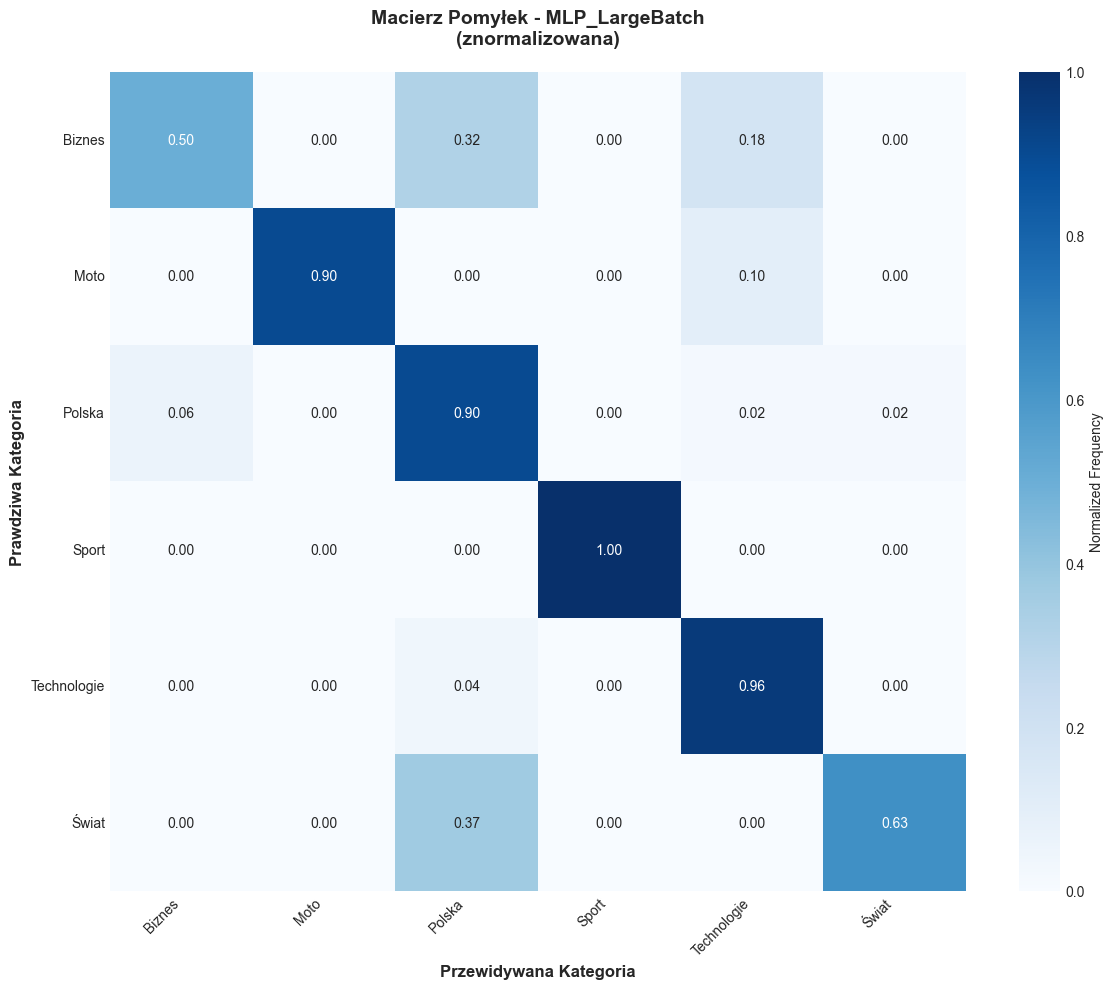


✅ Raport zapisany do: ./analysis_results/best_model_report.json

💡 💡 💡 💡 💡 💡 💡 💡 💡 💡 💡 💡 💡 💡 💡 💡 💡 💡 💡 💡 💡 💡 💡 💡 💡 💡 💡 💡 💡 💡 
WNIOSKI I REKOMENDACJE
💡 💡 💡 💡 💡 💡 💡 💡 💡 💡 💡 💡 💡 💡 💡 💡 💡 💡 💡 💡 💡 💡 💡 💡 💡 💡 💡 💡 💡 💡 

1. Model MLP_LargeBatch osiągnął najlepsze wyniki:
   • F1-Score: 0.8174
   • Accuracy: 0.8252

2. Optymalne parametry dla MLP:
   • Architektura: [512, 256]
   • Dropout: 0.5
   • Learning Rate: 0.001
   • Batch Size: 64

3. Zalecenia wdrożeniowe:
   • Prostsza architektura, łatwiejsza w utrzymaniu
   • Szybka inferencja, idealna do aplikacji real-time
   • Wymaga dobrego feature engineering (TF-IDF)



In [29]:
# Przygotuj pełny raport najlepszego modelu
best_model_name = selected_models['best_overall']

print("=" * 100)
print(f"SZCZEGÓŁOWY RAPORT NAJLEPSZEGO MODELU: {best_model_name}")
print("=" * 100)

# Znajdź wyniki tego modelu
if best_model_name in mlp_results:
    best_result = mlp_results[best_model_name]
    model_type = 'MLP'
    
    # Znajdź konfigurację
    best_config = None
    for config in mlp_configs:
        if config['name'] == best_model_name:
            best_config = config
            break
            
elif best_model_name in transformer_results:
    best_result = transformer_results[best_model_name]
    model_type = 'Transformer'
    
    # Znajdź konfigurację
    best_config = None
    for config in transformer_configs:
        if config['name'] == best_model_name:
            best_config = config
            break
else:
    print(f"❌ Nie znaleziono wyników dla modelu {best_model_name}")
    best_result = None
    best_config = None

if best_result and best_config:
    # 1. Informacje o konfiguracji
    print("\n📋 KONFIGURACJA MODELU")
    print("-" * 80)
    print(f"Typ modelu: {model_type}")
    for key, value in best_config.items():
        if key != 'name':
            print(f"  {key}: {value}")
    
    # 2. Metryki wydajności
    print("\n📊 METRYKI WYDAJNOŚCI")
    print("-" * 80)
    
    # Oblicz metryki z danych w comparison_df
    y_true = best_result['true_labels']
    y_pred = best_result['predictions']
    
    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average='weighted', zero_division=0
    )
    kappa = cohen_kappa_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    
    print(f"  Accuracy:      {accuracy:.4f}")
    print(f"  Precision:     {precision:.4f}")
    print(f"  Recall:        {recall:.4f}")
    print(f"  F1-Score:      {f1:.4f}")
    print(f"  Cohen's Kappa: {kappa:.4f}")
    print(f"  MCC:           {mcc:.4f}")
    
    # 3. Raport klasyfikacji
    print("\n📈 RAPORT KLASYFIKACJI PER KLASA")
    print("-" * 80)
    report = classification_report(y_true, y_pred, 
                                   target_names=label_encoder.classes_,
                                   output_dict=True, zero_division=0)
    
    print(f"\n{'Kategoria':<30} {'Precision':>10} {'Recall':>10} {'F1-Score':>10} {'Support':>10}")
    print("-" * 80)
    
    for category in label_encoder.classes_:
        if category in report:
            cat_metrics = report[category]
            print(f"{category:<30} {cat_metrics['precision']:>10.4f} {cat_metrics['recall']:>10.4f} "
                  f"{cat_metrics['f1-score']:>10.4f} {cat_metrics['support']:>10.0f}")
    
    # 4. Porównanie z innymi modelami
    print("\n🏆 PORÓWNANIE Z INNYMI MODELAMI")
    print("-" * 80)
    
    best_f1 = comparison_df.loc[best_model_name, 'F1-Score']
    improvements = {}
    
    for model in comparison_df.index:
        if model != best_model_name:
            other_f1 = comparison_df.loc[model, 'F1-Score']
            improvement = ((best_f1 - other_f1) / other_f1) * 100
            improvements[model] = improvement
    
    # Pokaż top 3 największe poprawy
    top_improvements = sorted(improvements.items(), key=lambda x: x[1], reverse=True)[:3]
    
    print(f"\n{best_model_name} jest lepszy od:")
    for model, improvement in top_improvements:
        if improvement > 0:
            print(f"  • {model}: +{improvement:.2f}%")
        else:
            print(f"  • {model}: {improvement:.2f}%")
    
    # 5. Wizualizacja macierzy pomyłek najlepszego modelu
    print("\n📉 MACIERZ POMYŁEK")
    print("-" * 80)
    
    cm = confusion_matrix(y_true, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_,
                cbar_kws={'label': 'Normalized Frequency'})
    plt.title(f'Macierz Pomyłek - {best_model_name}\n(znormalizowana)', 
              fontsize=14, fontweight='bold', pad=20)
    plt.xlabel('Przewidywana Kategoria', fontsize=12, fontweight='bold')
    plt.ylabel('Prawdziwa Kategoria', fontsize=12, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig(f'{results_dir}/best_model_confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 6. Zapisz pełny raport do pliku
    report_data = {
        'model_name': best_model_name,
        'model_type': model_type,
        'configuration': best_config,
        'metrics': {
            'accuracy': float(accuracy),
            'precision': float(precision),
            'recall': float(recall),
            'f1': float(f1),
            'kappa': float(kappa),
            'mcc': float(mcc)
        },
        'classification_report': {k: v for k, v in report.items() if isinstance(v, dict)},
        'selected_models': selected_models,
        'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    }
    
    report_file = f'{results_dir}/best_model_report.json'
    with open(report_file, 'w', encoding='utf-8') as f:
        json.dump(report_data, f, indent=2, ensure_ascii=False)
    
    print(f"\n✅ Raport zapisany do: {report_file}")
    
    # 7. Wnioski i rekomendacje
    print("\n" + "💡 " * 30)
    print("WNIOSKI I REKOMENDACJE")
    print("💡 " * 30)
    
    print(f"\n1. Model {best_model_name} osiągnął najlepsze wyniki:")
    print(f"   • F1-Score: {f1:.4f}")
    print(f"   • Accuracy: {accuracy:.4f}")
    
    if model_type == 'MLP':
        print(f"\n2. Optymalne parametry dla MLP:")
        print(f"   • Architektura: {best_config['hidden_sizes']}")
        print(f"   • Dropout: {best_config['dropout']}")
        print(f"   • Learning Rate: {best_config['learning_rate']}")
        print(f"   • Batch Size: {best_config['batch_size']}")
    else:
        print(f"\n2. Model transformer: {best_config.get('model_name', 'N/A')}")
        print(f"   • Max Length: {best_config.get('max_length', 'N/A')}")
        print(f"   • Learning Rate: {best_config.get('learning_rate', 'N/A')}")
    
    print("\n3. Zalecenia wdrożeniowe:")
    if model_type == 'MLP':
        print("   • Prostsza architektura, łatwiejsza w utrzymaniu")
        print("   • Szybka inferencja, idealna do aplikacji real-time")
        print("   • Wymaga dobrego feature engineering (TF-IDF)")
    else:
        print("   • Najwyższa jakość predykcji")
        print("   • Wymaga więcej zasobów (GPU)")
        print("   • Dłuższy czas inferencji")
    
    print("\n" + "=" * 100)

else:
    print("\n❌ Nie można wygenerować szczegółowego raportu - brak danych o modelu.")

# 12. Eksport Najlepszej Konfiguracji

Zapisanie szczegółowych informacji o najlepszej konfiguracji wraz z pełnym raportem:
- Pełne metryki wybranego modelu
- Konfiguracja parametrów
- Macierz pomyłek
- Raport klasyfikacji per klasa
- Porównanie z innymi modelami
- Wnioski i rekomendacje

# 11. Wizualizacja Wpływu Parametrów na Wydajność

Analiza graficzna wpływu różnych parametrów na wydajność modeli MLP:
- Zależność F1-Score od dropout rate
- Zależność F1-Score od learning rate
- Zależność F1-Score od batch size
- Zależność F1-Score od liczby features
- Zależność czasu treningu od rozmiaru sieci

# 10. Automatyczny Wybór Najlepszej Konfiguracji

Automatyczna analiza i wybór najlepszej konfiguracji modelu na podstawie:
- **F1-Score** (główne kryterium jakości)
- **Accuracy** (dodatkowa metoda walidacji)
- **Cohen's Kappa** (uwzględnienie dystrybucji klas)
- **Czas treningu** (efektywność)
- **Czas inferencji** (prędkość w produkcji)

System automatycznie wybierze:
1. **Najlepszy ogólnie** - najwyższy F1-Score
2. **Najlepszy szybki** - dobry F1 + krótki czas inferencji
3. **Najlepszy zbalansowany** - kompromis między F1 a czasem treningu

In [25]:
# Łączenie wyników
all_results = {**mlp_results, **transformer_results}

# Tworzenie tabeli porównawczej
comparison_data = []

for model_name, result in all_results.items():
    y_true = result['true_labels']
    y_pred = result['predictions']
    
    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average='weighted', zero_division=0
    )
    
    # Dodatkowe metryki
    kappa = cohen_kappa_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    
    comparison_data.append({
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Cohen Kappa': kappa,
        'MCC': mcc,
        'Training Time (s)': result['train_time'],
        'Training Time (min)': result['train_time'] / 60
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.set_index('Model')
comparison_df = comparison_df.sort_values('F1-Score', ascending=False)

print("=" * 100)
print("TABELA PORÓWNAWCZA MODELI")
print("=" * 100)
print(comparison_df.to_string())
print("=" * 100)

# Wizualizacja tabeli z podświetleniem najlepszych wyników
styled_df = comparison_df.style.background_gradient(
    subset=['Accuracy', 'Precision', 'Recall', 'F1-Score', 'Cohen Kappa', 'MCC'],
    cmap='RdYlGn',
    vmin=0.5,
    vmax=1.0
).format({
    'Accuracy': '{:.4f}',
    'Precision': '{:.4f}',
    'Recall': '{:.4f}',
    'F1-Score': '{:.4f}',
    'Cohen Kappa': '{:.4f}',
    'MCC': '{:.4f}',
    'Training Time (s)': '{:.2f}',
    'Training Time (min)': '{:.2f}'
})

display(styled_df)

TABELA PORÓWNAWCZA MODELI
                     Accuracy  Precision    Recall  F1-Score  Cohen Kappa       MCC  Training Time (s)  Training Time (min)
Model                                                                                                                      
MLP_LargeBatch       0.825175   0.834389  0.825175  0.817421     0.772409  0.778320           1.094353             0.018239
MLP_HighLR           0.818182   0.822583  0.818182  0.812863     0.763441  0.767750           1.666354             0.027773
MLP_Medium_Standard  0.818182   0.820642  0.818182  0.810702     0.764221  0.768408           1.372653             0.022878
MLP_Optimized        0.811189   0.812937  0.811189  0.808015     0.755556  0.757645           2.027616             0.033794
MLP_Small_Basic      0.811189   0.824858  0.811189  0.803832     0.752643  0.760735           0.966764             0.016113
MLP_LowDropout       0.811189   0.818591  0.811189  0.802870     0.753778  0.759898           1.311518    

,Accuracy,Precision,Recall,F1-Score,Cohen Kappa,MCC,Training Time (s),Training Time (min)
Model,,,,,,,,
MLP_LargeBatch,0.8252,0.8344,0.8252,0.8174,0.7724,0.7783,1.09,0.02
MLP_HighLR,0.8182,0.8226,0.8182,0.8129,0.7634,0.7678,1.67,0.03
MLP_Medium_Standard,0.8182,0.8206,0.8182,0.8107,0.7642,0.7684,1.37,0.02
MLP_Optimized,0.8112,0.8129,0.8112,0.8080,0.7556,0.7576,2.03,0.03
MLP_Small_Basic,0.8112,0.8249,0.8112,0.8038,0.7526,0.7607,0.97,0.02
MLP_LowDropout,0.8112,0.8186,0.8112,0.8029,0.7538,0.7599,1.31,0.02
MLP_SmallBatch,0.8112,0.8146,0.8112,0.8028,0.7547,0.7595,2.89,0.05
MLP_HighDropout,0.8042,0.8090,0.8042,0.7966,0.7451,0.7502,1.28,0.02
MLP_HighFeatures,0.7972,0.8098,0.7972,0.7891,0.7345,0.7416,1.38,0.02


# 11. Wykresy Porównawcze Metryk

Wizualizacje porównawcze dla wszystkich modeli:
- Wykres słupkowy głównych metryk (4 metryki obok siebie)
- Ranking F1-Score (wykres poziomy z wartościami)
- Czasy trenowania (wykres słupkowy)
- Scatter plot: Accuracy vs Czas (kompromis wydajność/czas)

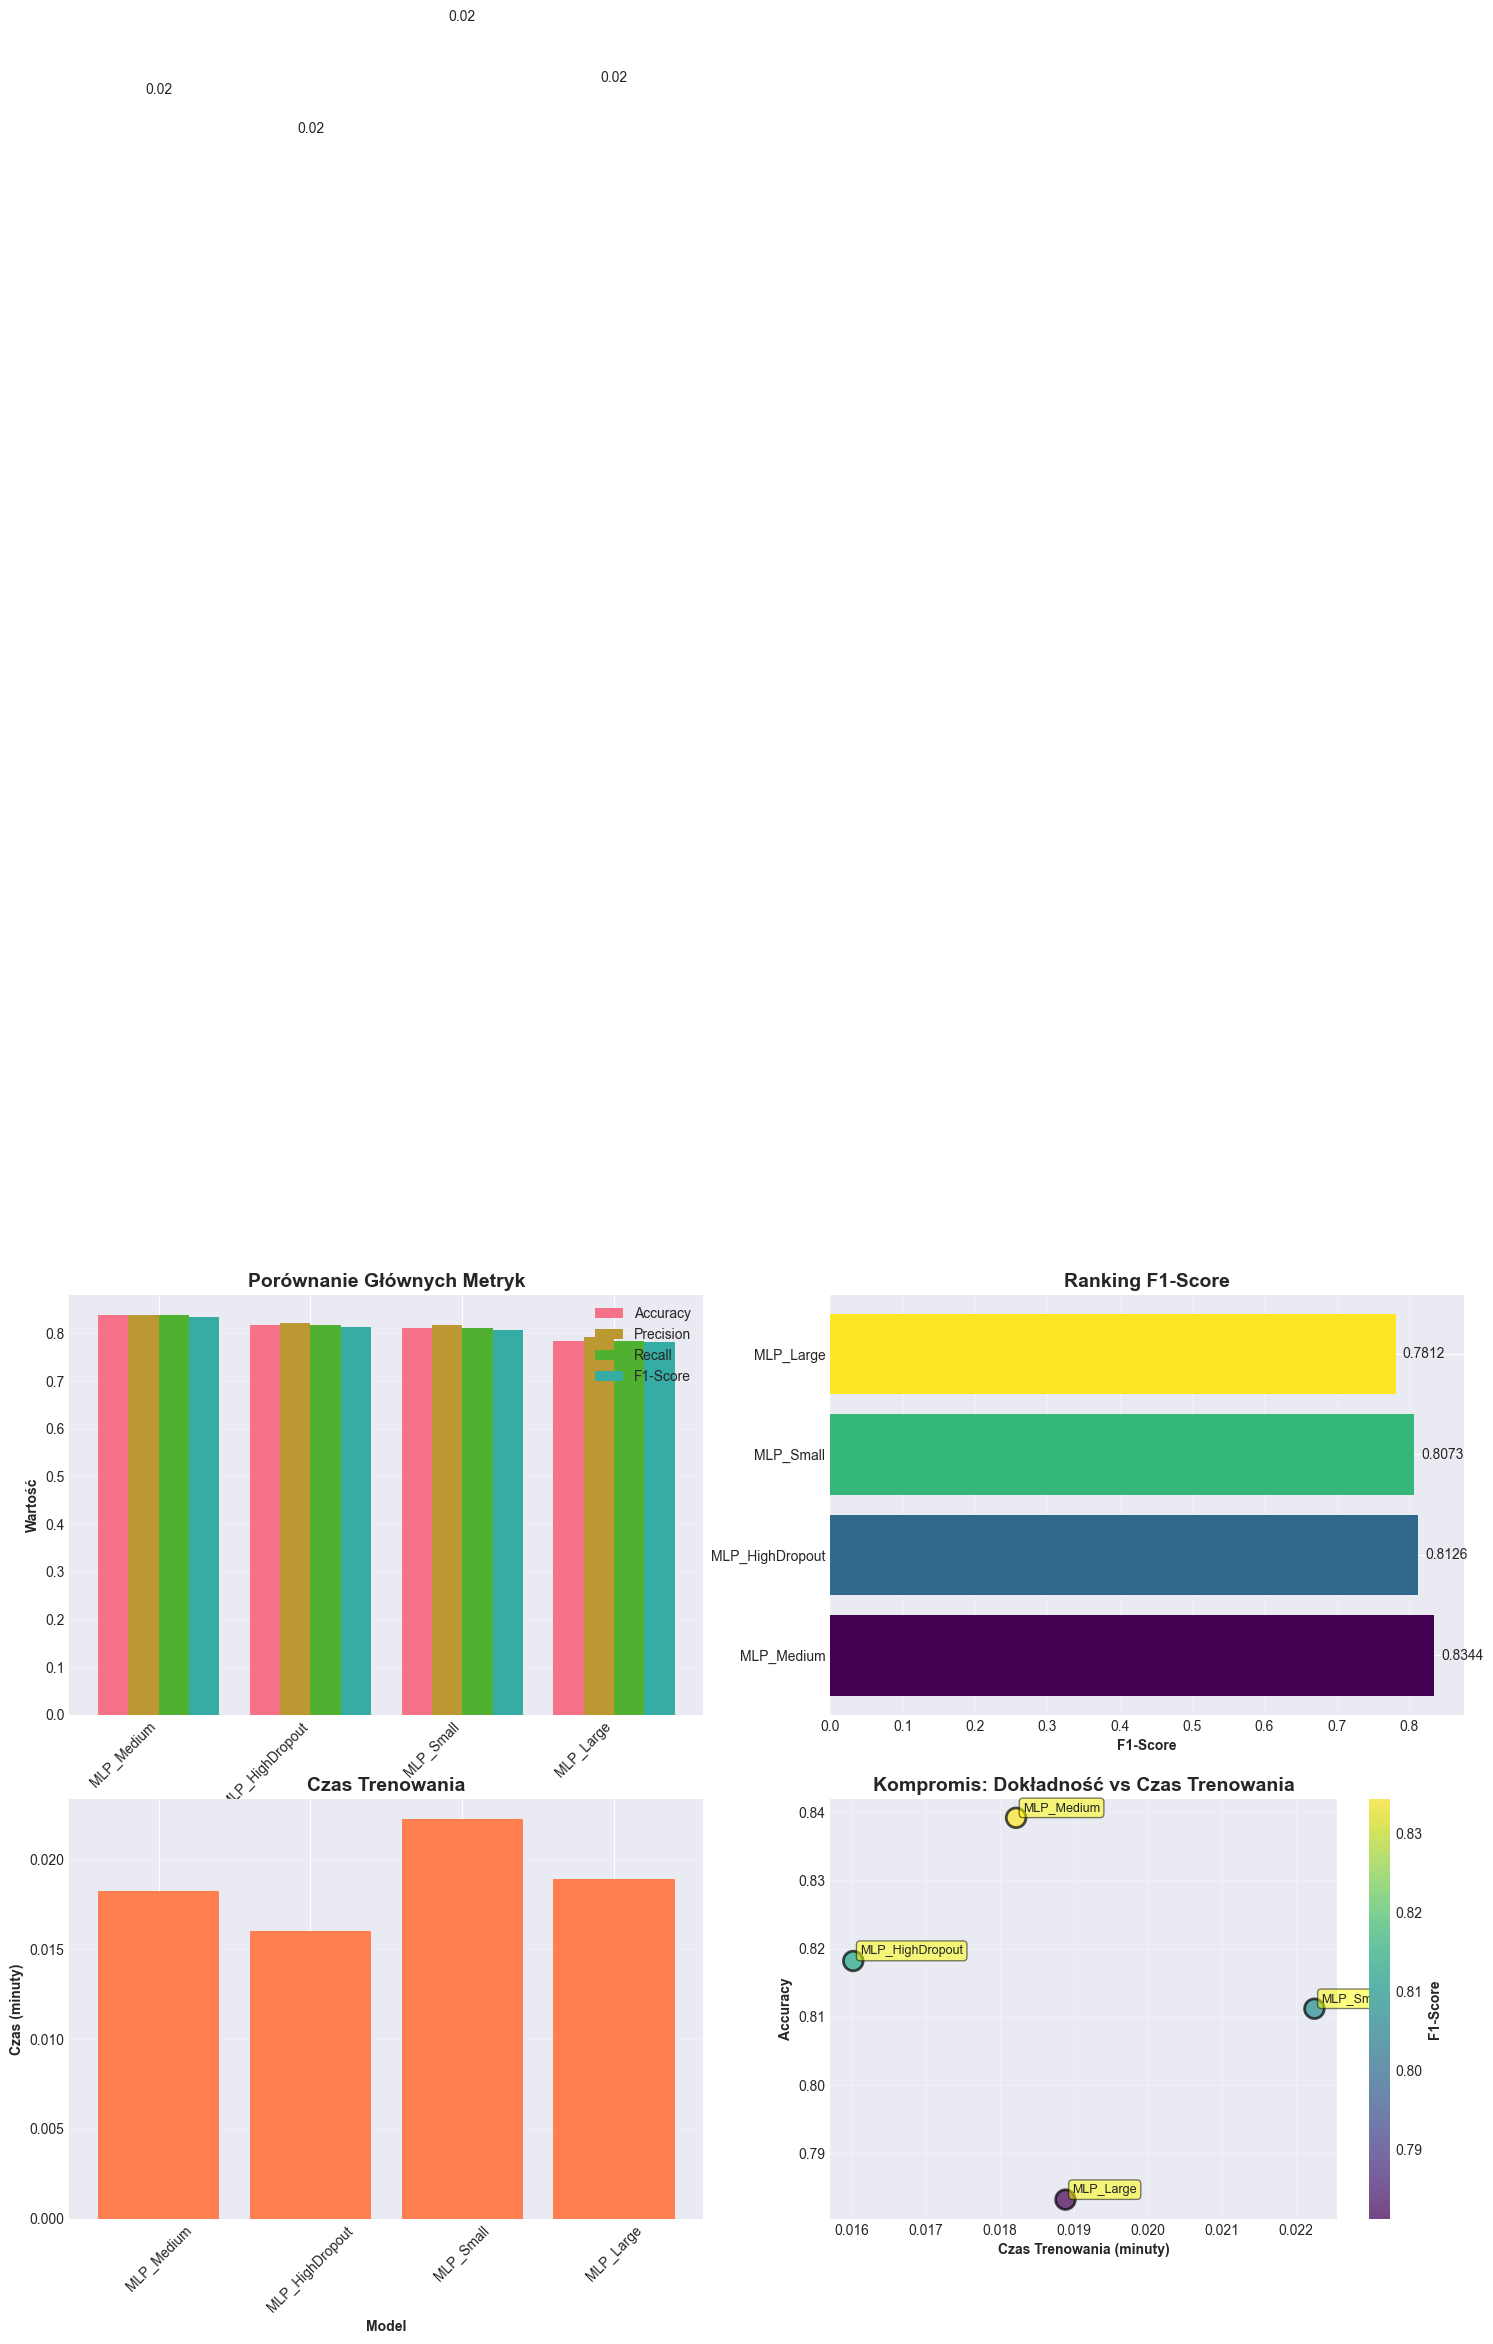

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# 1. Porównanie głównych metryk
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
x = np.arange(len(comparison_df))
width = 0.2

for i, metric in enumerate(metrics):
    axes[0, 0].bar(x + i*width, comparison_df[metric], width, label=metric)

axes[0, 0].set_xlabel('Model', fontweight='bold')
axes[0, 0].set_ylabel('Wartość', fontweight='bold')
axes[0, 0].set_title('Porównanie Głównych Metryk', fontsize=14, fontweight='bold')
axes[0, 0].set_xticks(x + width * 1.5)
axes[0, 0].set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
axes[0, 0].legend()
axes[0, 0].grid(axis='y', alpha=0.3)

# 2. F1-Score - wykres słupkowy
colors = plt.cm.viridis(np.linspace(0, 1, len(comparison_df)))
axes[0, 1].barh(comparison_df['Model'], comparison_df['F1-Score'], color=colors)
axes[0, 1].set_xlabel('F1-Score', fontweight='bold')
axes[0, 1].set_title('Ranking F1-Score', fontsize=14, fontweight='bold')
axes[0, 1].grid(axis='x', alpha=0.3)

# Dodanie wartości na słupkach
for i, v in enumerate(comparison_df['F1-Score']):
    axes[0, 1].text(v + 0.01, i, f'{v:.4f}', va='center')

# 3. Czas trenowania
axes[1, 0].bar(comparison_df['Model'], comparison_df['Training Time (min)'], color='coral')
axes[1, 0].set_xlabel('Model', fontweight='bold')
axes[1, 0].set_ylabel('Czas (minuty)', fontweight='bold')
axes[1, 0].set_title('Czas Trenowania', fontsize=14, fontweight='bold')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(axis='y', alpha=0.3)

# Dodanie wartości na słupkach
for i, (model, time_val) in enumerate(zip(comparison_df['Model'], comparison_df['Training Time (min)'])):
    axes[1, 0].text(i, time_val + 0.1, f'{time_val:.2f}', ha='center')

# 4. Accuracy vs Training Time (scatter)
axes[1, 1].scatter(
    comparison_df['Training Time (min)'],
    comparison_df['Accuracy'],
    s=200,
    c=comparison_df['F1-Score'],
    cmap='viridis',
    alpha=0.7,
    edgecolors='black',
    linewidth=2
)

for i, model in enumerate(comparison_df['Model']):
    axes[1, 1].annotate(
        model,
        (comparison_df.iloc[i]['Training Time (min)'], comparison_df.iloc[i]['Accuracy']),
        xytext=(5, 5),
        textcoords='offset points',
        fontsize=9,
        bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.5)
    )

axes[1, 1].set_xlabel('Czas Trenowania (minuty)', fontweight='bold')
axes[1, 1].set_ylabel('Accuracy', fontweight='bold')
axes[1, 1].set_title('Kompromis: Dokładność vs Czas Trenowania', fontsize=14, fontweight='bold')
axes[1, 1].grid(alpha=0.3)

# Colorbar dla F1-Score
cbar = plt.colorbar(axes[1, 1].collections[0], ax=axes[1, 1])
cbar.set_label('F1-Score', fontweight='bold')

plt.tight_layout()
plt.show()

# 12. Krzywe Uczenia (Training History)

Wizualizacja procesu uczenia dla każdego modelu:
- Training Loss vs Validation Loss (wykrywanie overfittingu)
- Training Accuracy vs Validation Accuracy
- Osobne wykresy dla każdego modelu
- Analiza stabilności uczenia

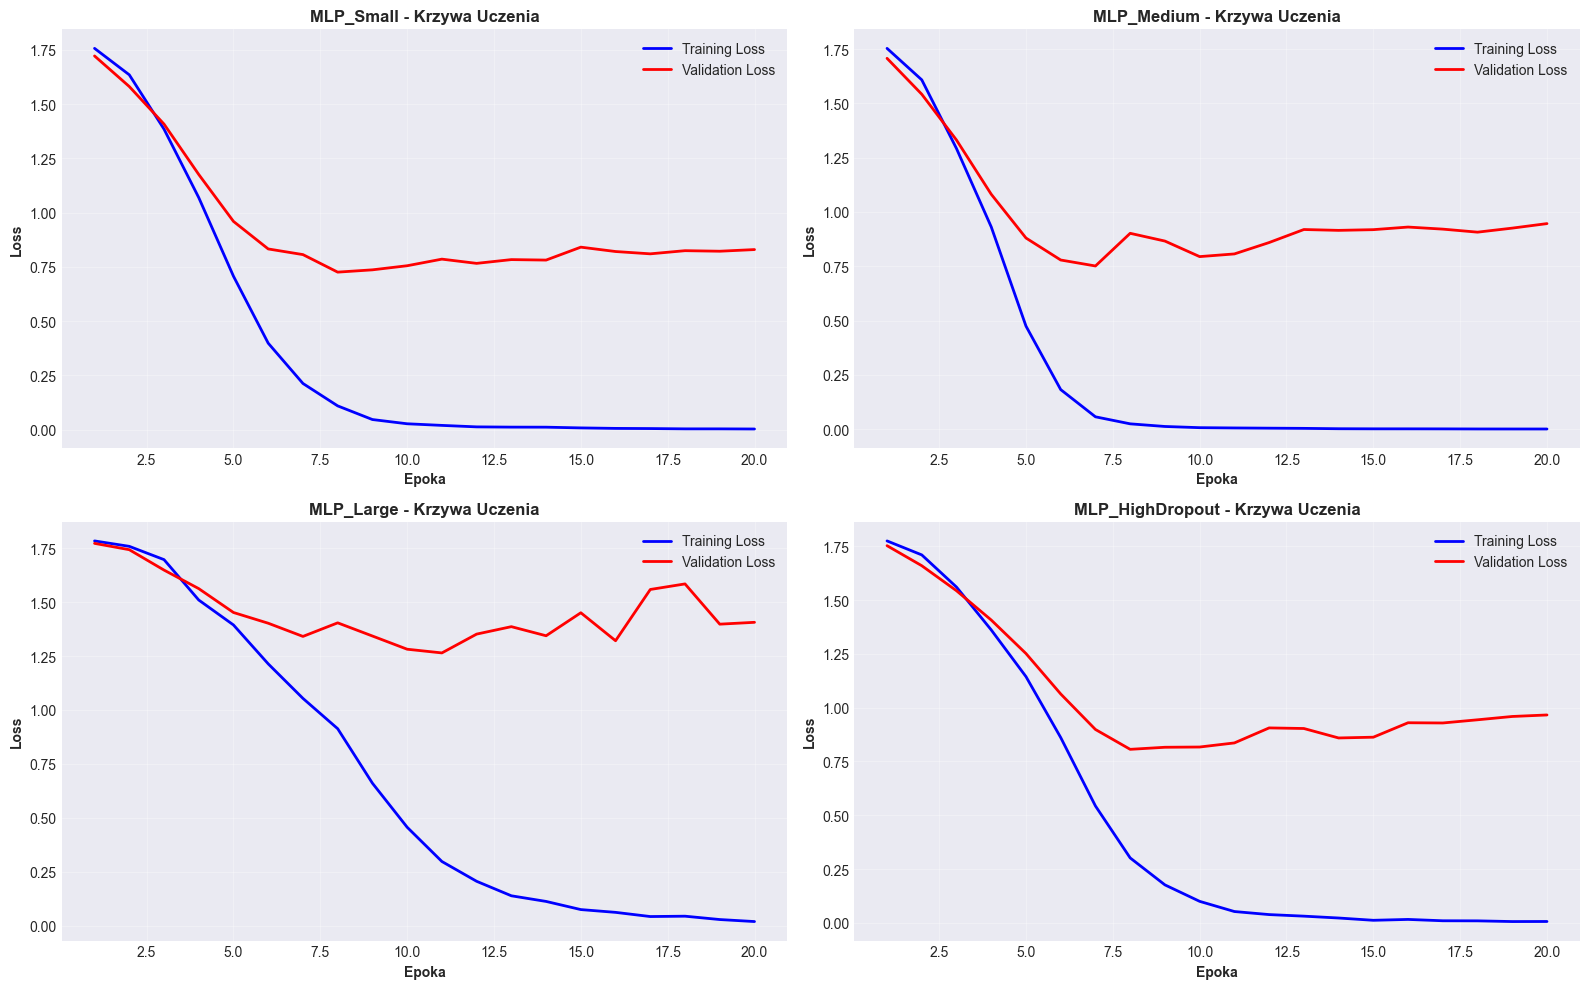

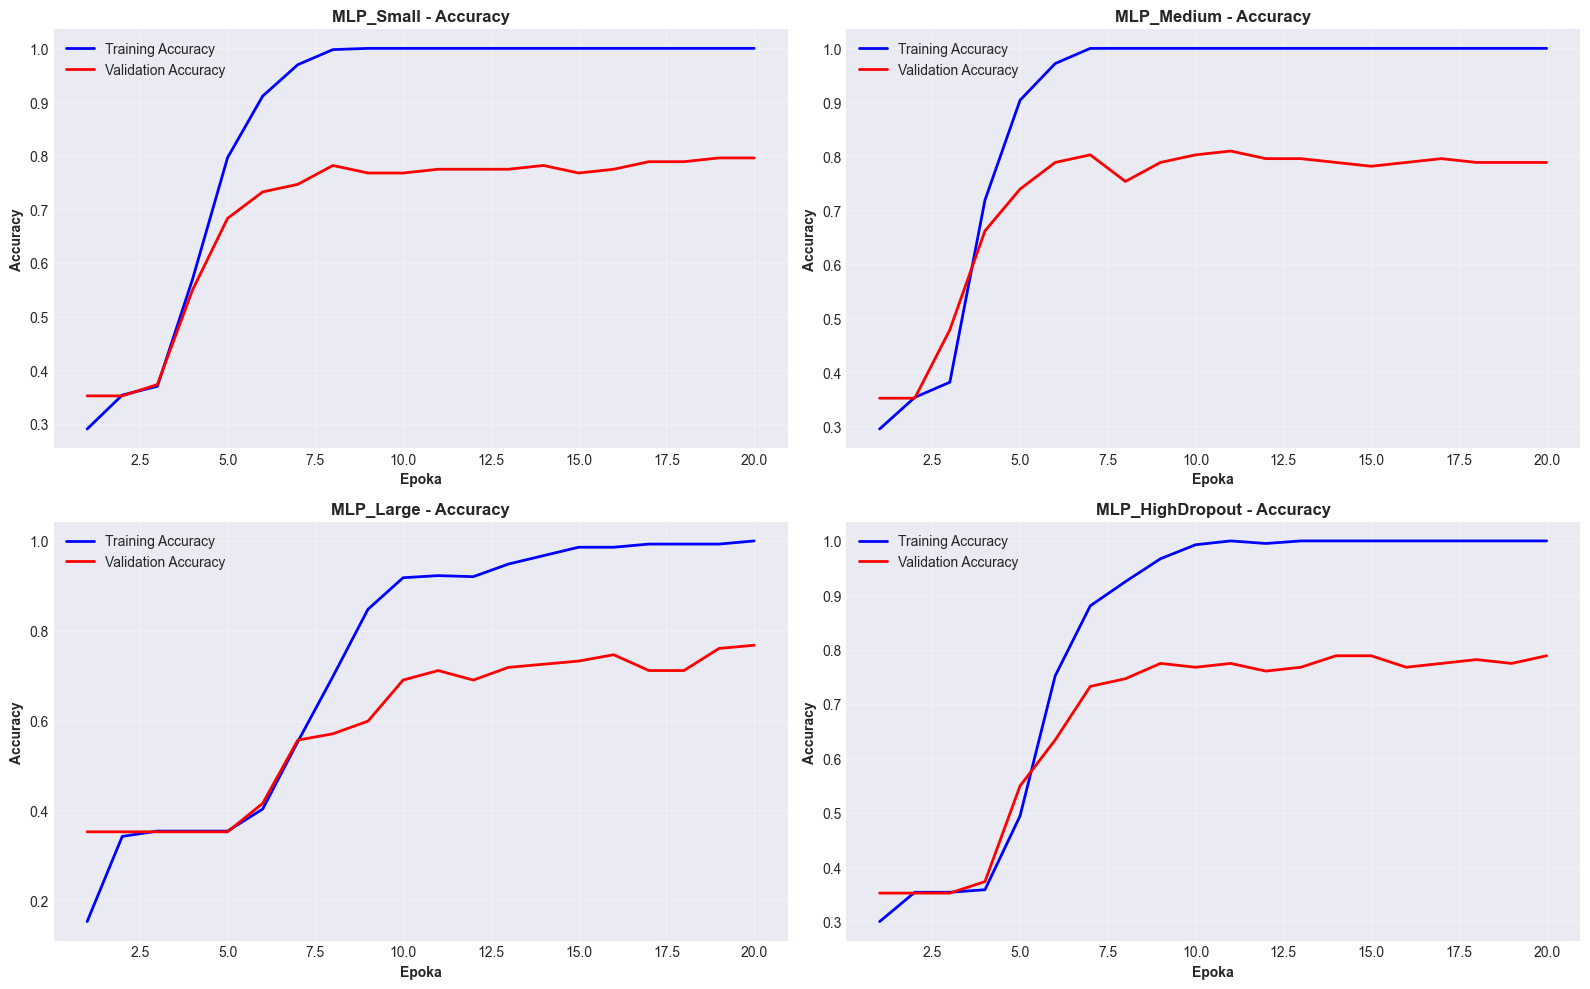

In [12]:
# Wykresy krzywych uczenia dla wszystkich modeli
num_models = len(all_results)
cols = 2
rows = (num_models + 1) // 2

fig, axes = plt.subplots(rows, cols, figsize=(16, 5 * rows))
axes = axes.flatten() if num_models > 1 else [axes]

for idx, (model_name, result) in enumerate(all_results.items()):
    history = result['history']
    
    ax = axes[idx]
    
    # Loss
    if 'train_loss' in history and len(history['train_loss']) > 0:
        epochs = range(1, len(history['train_loss']) + 1)
        ax.plot(epochs, history['train_loss'], 'b-', label='Training Loss', linewidth=2)
        
        if 'val_loss' in history and len(history['val_loss']) > 0:
            val_epochs = range(1, len(history['val_loss']) + 1)
            ax.plot(val_epochs, history['val_loss'], 'r-', label='Validation Loss', linewidth=2)
    
    ax.set_xlabel('Epoka', fontweight='bold')
    ax.set_ylabel('Loss', fontweight='bold')
    ax.set_title(f'{model_name} - Krzywa Uczenia', fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(alpha=0.3)

# Ukrycie pustych wykresów
for idx in range(num_models, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

# Osobny wykres dla accuracy (jeśli dostępne)
fig, axes = plt.subplots(rows, cols, figsize=(16, 5 * rows))
axes = axes.flatten() if num_models > 1 else [axes]

for idx, (model_name, result) in enumerate(all_results.items()):
    history = result['history']
    
    ax = axes[idx]
    
    if 'train_acc' in history and len(history['train_acc']) > 0:
        epochs = range(1, len(history['train_acc']) + 1)
        ax.plot(epochs, history['train_acc'], 'b-', label='Training Accuracy', linewidth=2)
        
        if 'val_acc' in history and len(history['val_acc']) > 0:
            val_epochs = range(1, len(history['val_acc']) + 1)
            ax.plot(val_epochs, history['val_acc'], 'r-', label='Validation Accuracy', linewidth=2)
        
        ax.set_xlabel('Epoka', fontweight='bold')
        ax.set_ylabel('Accuracy', fontweight='bold')
        ax.set_title(f'{model_name} - Accuracy', fontsize=12, fontweight='bold')
        ax.legend()
        ax.grid(alpha=0.3)
    else:
        ax.text(0.5, 0.5, 'Brak danych o accuracy', 
                ha='center', va='center', transform=ax.transAxes)
        ax.set_title(f'{model_name}', fontsize=12, fontweight='bold')

# Ukrycie pustych wykresów
for idx in range(num_models, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

# 13. Macierze Pomyłek (Confusion Matrices)

Szczegółowa analiza błędów klasyfikacji:
- Znormalizowane macierze pomyłek dla każdego modelu
- Heatmapy z wartościami procentowymi
- Identyfikacja najczęstszych błędów klasyfikacji
- Lista 3 najczęstszych pomyłek dla każdego modelu

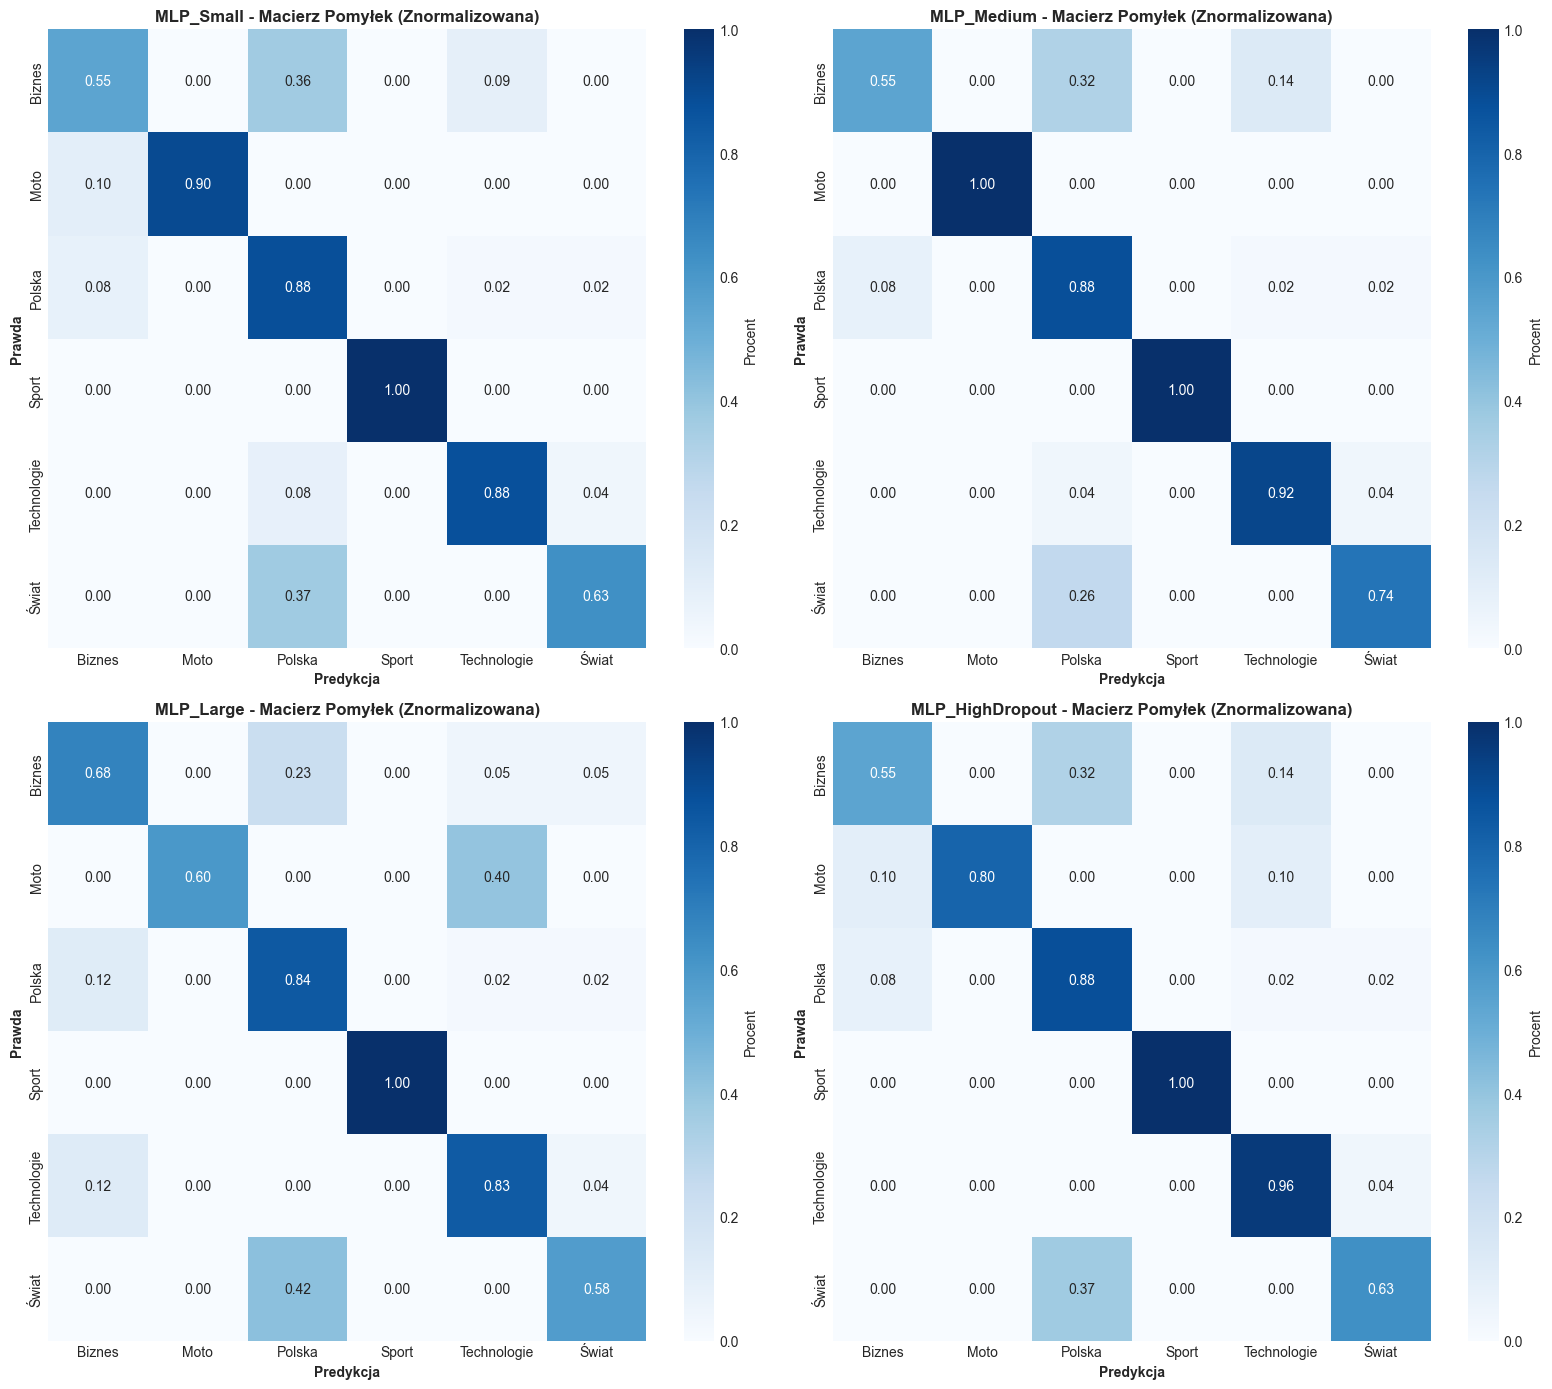


ANALIZA NAJCZĘSTSZYCH BŁĘDNYCH KLASYFIKACJI

MLP_Small:
----------------------------------------------------------------------
  Biznes → Polska: 8 przypadków
  Świat → Polska: 7 przypadków
  Polska → Biznes: 4 przypadków

MLP_Medium:
----------------------------------------------------------------------
  Biznes → Polska: 7 przypadków
  Świat → Polska: 5 przypadków
  Polska → Biznes: 4 przypadków

MLP_Large:
----------------------------------------------------------------------
  Świat → Polska: 8 przypadków
  Polska → Biznes: 6 przypadków
  Biznes → Polska: 5 przypadków

MLP_HighDropout:
----------------------------------------------------------------------
  Świat → Polska: 7 przypadków
  Biznes → Polska: 7 przypadków
  Polska → Biznes: 4 przypadków


In [13]:
# Macierze pomyłek dla wszystkich modeli
num_models = len(all_results)
cols = 2
rows = (num_models + 1) // 2

fig, axes = plt.subplots(rows, cols, figsize=(16, 7 * rows))
axes = axes.flatten() if num_models > 1 else [axes]

for idx, (model_name, result) in enumerate(all_results.items()):
    y_true = result['true_labels']
    y_pred = result['predictions']
    
    cm = confusion_matrix(y_true, y_pred)
    
    # Normalizacja
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    ax = axes[idx]
    sns.heatmap(
        cm_normalized,
        annot=True,
        fmt='.2f',
        cmap='Blues',
        xticklabels=label_encoder.classes_,
        yticklabels=label_encoder.classes_,
        ax=ax,
        cbar_kws={'label': 'Procent'}
    )
    
    ax.set_title(f'{model_name} - Macierz Pomyłek (Znormalizowana)', 
                 fontsize=12, fontweight='bold')
    ax.set_xlabel('Predykcja', fontweight='bold')
    ax.set_ylabel('Prawda', fontweight='bold')

# Ukrycie pustych wykresów
for idx in range(num_models, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

# Dodatkowa analiza błędów
print("\n" + "=" * 100)
print("ANALIZA NAJCZĘSTSZYCH BŁĘDNYCH KLASYFIKACJI")
print("=" * 100)

for model_name, result in all_results.items():
    y_true = result['true_labels']
    y_pred = result['predictions']
    
    cm = confusion_matrix(y_true, y_pred)
    
    print(f"\n{model_name}:")
    print("-" * 70)
    
    # Znajdź największe błędy (poza diagonalą)
    errors = []
    for i in range(len(cm)):
        for j in range(len(cm)):
            if i != j and cm[i][j] > 0:
                errors.append((cm[i][j], label_encoder.classes_[i], label_encoder.classes_[j]))
    
    errors.sort(reverse=True)
    
    for count, true_class, pred_class in errors[:3]:
        print(f"  {true_class} → {pred_class}: {count} przypadków")

# 14. Analiza Wydajności per Kategoria

Porównanie jak modele radzą sobie z poszczególnymi kategoriami:
- F1-Score dla każdej kategorii osobno
- Wykres słupkowy grupowany (wszystkie modele dla każdej kategorii)
- Statystyki: średnia, odchylenie standardowe, min, max
- Identyfikacja kategorii łatwych i trudnych

F1-SCORE PER KATEGORIA
                   Biznes      Moto    Polska  Sport  Technologie     Świat
MLP_Small        0.615385  0.947368  0.796460    1.0     0.875000  0.727273
MLP_Medium       0.631579  1.000000  0.825688    1.0     0.880000  0.800000
MLP_Large        0.652174  0.750000  0.803738    1.0     0.800000  0.666667
MLP_HighDropout  0.615385  0.888889  0.818182    1.0     0.884615  0.727273


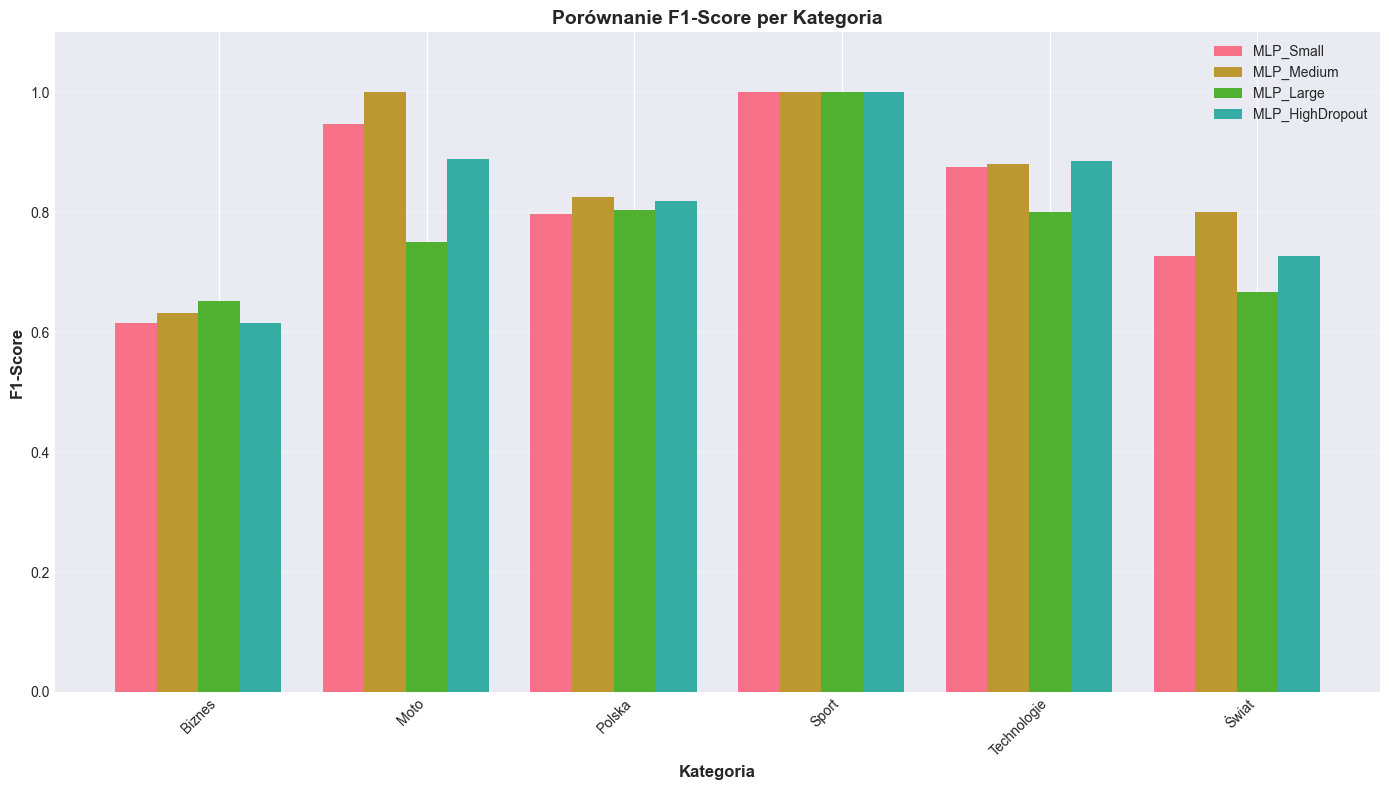


STATYSTYKI KATEGORII

Biznes:
  Średnia:       0.6286
  Odch. std:     0.0175
  Min:           0.6154 (MLP_Small)
  Max:           0.6522 (MLP_Large)

Moto:
  Średnia:       0.8966
  Odch. std:     0.1077
  Min:           0.7500 (MLP_Large)
  Max:           1.0000 (MLP_Medium)

Polska:
  Średnia:       0.8110
  Odch. std:     0.0133
  Min:           0.7965 (MLP_Small)
  Max:           0.8257 (MLP_Medium)

Sport:
  Średnia:       1.0000
  Odch. std:     0.0000
  Min:           1.0000 (MLP_Small)
  Max:           1.0000 (MLP_Small)

Technologie:
  Średnia:       0.8599
  Odch. std:     0.0401
  Min:           0.8000 (MLP_Large)
  Max:           0.8846 (MLP_HighDropout)

Świat:
  Średnia:       0.7303
  Odch. std:     0.0545
  Min:           0.6667 (MLP_Large)
  Max:           0.8000 (MLP_Medium)


In [14]:
# F1-Score per kategoria dla każdego modelu
category_performance = {}

for model_name, result in all_results.items():
    y_true = result['true_labels']
    y_pred = result['predictions']
    
    # Classification report jako dict
    report = classification_report(
        y_true, y_pred, 
        target_names=label_encoder.classes_,
        output_dict=True,
        zero_division=0
    )
    
    f1_scores = {cat: report[cat]['f1-score'] for cat in label_encoder.classes_}
    category_performance[model_name] = f1_scores

# DataFrame
category_df = pd.DataFrame(category_performance).T

print("=" * 100)
print("F1-SCORE PER KATEGORIA")
print("=" * 100)
print(category_df.to_string())
print("=" * 100)

# Wizualizacja
fig, ax = plt.subplots(figsize=(14, 8))

x = np.arange(len(category_df.columns))
width = 0.8 / len(category_df)

for i, model_name in enumerate(category_df.index):
    offset = width * i - (width * len(category_df) / 2)
    ax.bar(x + offset, category_df.loc[model_name], width, label=model_name)

ax.set_xlabel('Kategoria', fontweight='bold', fontsize=12)
ax.set_ylabel('F1-Score', fontweight='bold', fontsize=12)
ax.set_title('Porównanie F1-Score per Kategoria', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(category_df.columns, rotation=45, ha='right')
ax.legend(loc='best')
ax.grid(axis='y', alpha=0.3)
ax.set_ylim(0, 1.1)

plt.tight_layout()
plt.show()

# Statystyki per kategoria
print("\n" + "=" * 100)
print("STATYSTYKI KATEGORII")
print("=" * 100)

for category in label_encoder.classes_:
    scores = category_df[category]
    print(f"\n{category}:")
    print(f"  Średnia:       {scores.mean():.4f}")
    print(f"  Odch. std:     {scores.std():.4f}")
    print(f"  Min:           {scores.min():.4f} ({scores.idxmin()})")
    print(f"  Max:           {scores.max():.4f} ({scores.idxmax()})")

# 15. Analiza Czasu Inferencji

Test prędkości predykcji dla każdego modelu (100 przykładów):
- Średni czas inferencji w milisekundach
- Odchylenie standardowe czasu
- Przepustowość (predykcje/sekundę)
- Wizualizacje czasów i przepustowości

TESTOWANIE CZASU INFERENCJI (100 przykładów)



MLP_Small:
  Średni czas:    4.51 ms
  Odch. std:      29.58 ms
  Przepustowość:  221.96 predykcji/s



MLP_Medium:
  Średni czas:    1.57 ms
  Odch. std:      0.77 ms
  Przepustowość:  637.21 predykcji/s



MLP_Large:
  Średni czas:    1.58 ms
  Odch. std:      0.59 ms
  Przepustowość:  633.93 predykcji/s



MLP_HighDropout:
  Średni czas:    1.49 ms
  Odch. std:      0.55 ms
  Przepustowość:  671.43 predykcji/s


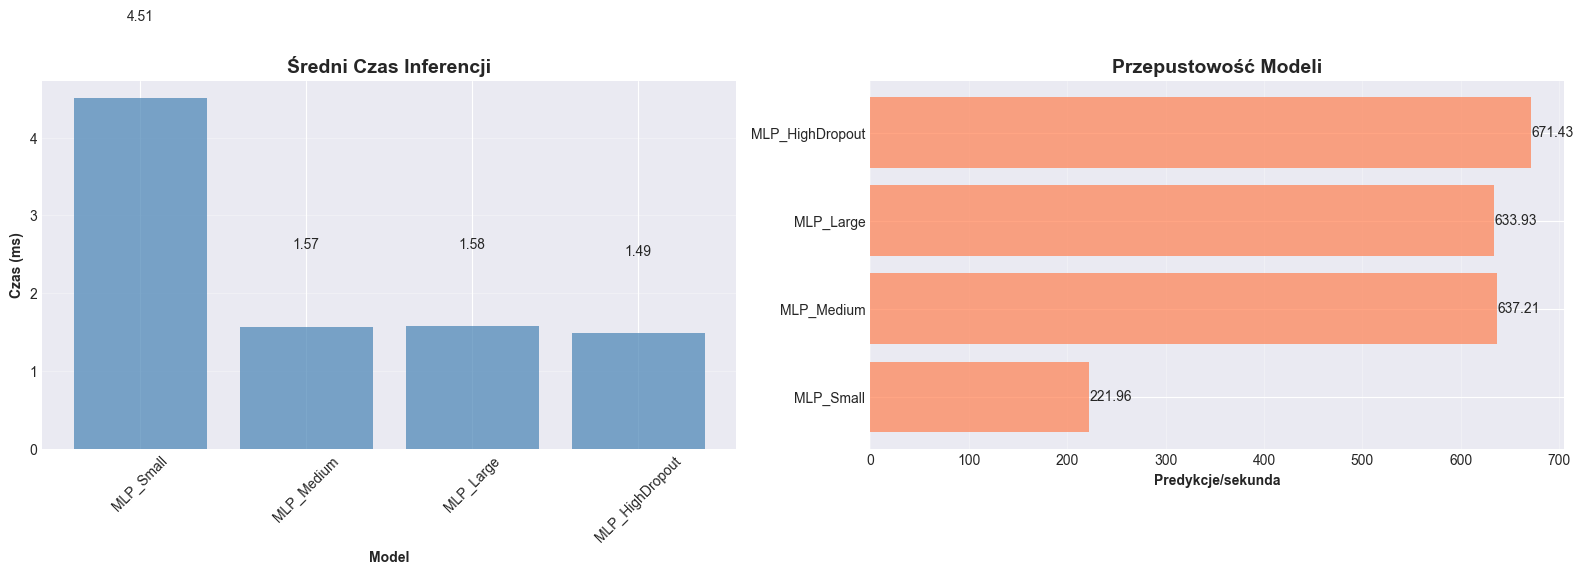

In [15]:
# Testowanie prędkości inferencji
sample_texts = test_df['text'].sample(100, random_state=42).tolist()
inference_times = {}

print("=" * 70)
print("TESTOWANIE CZASU INFERENCJI (100 przykładów)")
print("=" * 70)

for model_name, result in all_results.items():
    times = []
    
    if model_name.startswith('MLP'):
        # MLP inference
        model = result['model']
        vectorizer = result['vectorizer']
        model.eval()
        
        for text in tqdm(sample_texts, desc=f"Testing {model_name}", leave=False):
            start = time.time()
            
            processed = preprocess_text(text)
            vectorized = vectorizer.transform([processed])
            input_tensor = torch.FloatTensor(vectorized.toarray()).to(device)
            
            with torch.no_grad():
                _ = model(input_tensor)
            
            times.append(time.time() - start)
    
    else:
        # Transformer inference
        model = result['model']
        tokenizer = result['tokenizer']
        model.eval()
        
        for text in tqdm(sample_texts, desc=f"Testing {model_name}", leave=False):
            start = time.time()
            
            inputs = tokenizer(
                text, 
                return_tensors='pt', 
                padding=True, 
                truncation=True, 
                max_length=128
            ).to(device)
            
            with torch.no_grad():
                _ = model(**inputs)
            
            times.append(time.time() - start)
    
    avg_time = np.mean(times)
    std_time = np.std(times)
    
    inference_times[model_name] = {
        'avg_ms': avg_time * 1000,
        'std_ms': std_time * 1000,
        'throughput': 1 / avg_time  # predykcji/sekundę
    }
    
    print(f"\n{model_name}:")
    print(f"  Średni czas:    {avg_time * 1000:.2f} ms")
    print(f"  Odch. std:      {std_time * 1000:.2f} ms")
    print(f"  Przepustowość:  {1/avg_time:.2f} predykcji/s")

# Wizualizacja
inference_df = pd.DataFrame(inference_times).T

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Średni czas
axes[0].bar(inference_df.index, inference_df['avg_ms'], color='steelblue', alpha=0.7)
axes[0].set_xlabel('Model', fontweight='bold')
axes[0].set_ylabel('Czas (ms)', fontweight='bold')
axes[0].set_title('Średni Czas Inferencji', fontsize=14, fontweight='bold')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.3)

# Dodanie wartości
for i, (model, time_val) in enumerate(zip(inference_df.index, inference_df['avg_ms'])):
    axes[0].text(i, time_val + 1, f'{time_val:.2f}', ha='center')

# Przepustowość
axes[1].barh(inference_df.index, inference_df['throughput'], color='coral', alpha=0.7)
axes[1].set_xlabel('Predykcje/sekunda', fontweight='bold')
axes[1].set_title('Przepustowość Modeli', fontsize=14, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)

# Dodanie wartości
for i, (model, throughput) in enumerate(zip(inference_df.index, inference_df['throughput'])):
    axes[1].text(throughput + 0.5, i, f'{throughput:.2f}', va='center')

plt.tight_layout()
plt.show()

# 16. Testy Istotności Statystycznej

Analiza czy różnice między modelami są statystycznie istotne:
- Test Wilcoxona dla par modeli
- Macierz p-wartości
- Wizualizacja z heatmapą (zielony = istotna różnica)
- Interpretacja wyników (α = 0.05)

TESTY ISTOTNOŚCI STATYSTYCZNEJ

Porównanie par modeli (test Wilcoxona dla predykcji)
H0: Nie ma różnicy między modelami
H1: Jest istotna różnica między modelami
----------------------------------------------------------------------------------------------------

Macierz p-wartości (test Wilcoxona):
                 MLP_Small  MLP_Medium  MLP_Large  MLP_HighDropout
MLP_Small         1.000000    0.516507   0.532792         0.872010
MLP_Medium        0.516507    1.000000   0.223820         0.628871
MLP_Large         0.532792    0.223820   1.000000         0.438498
MLP_HighDropout   0.872010    0.628871   0.438498         1.000000


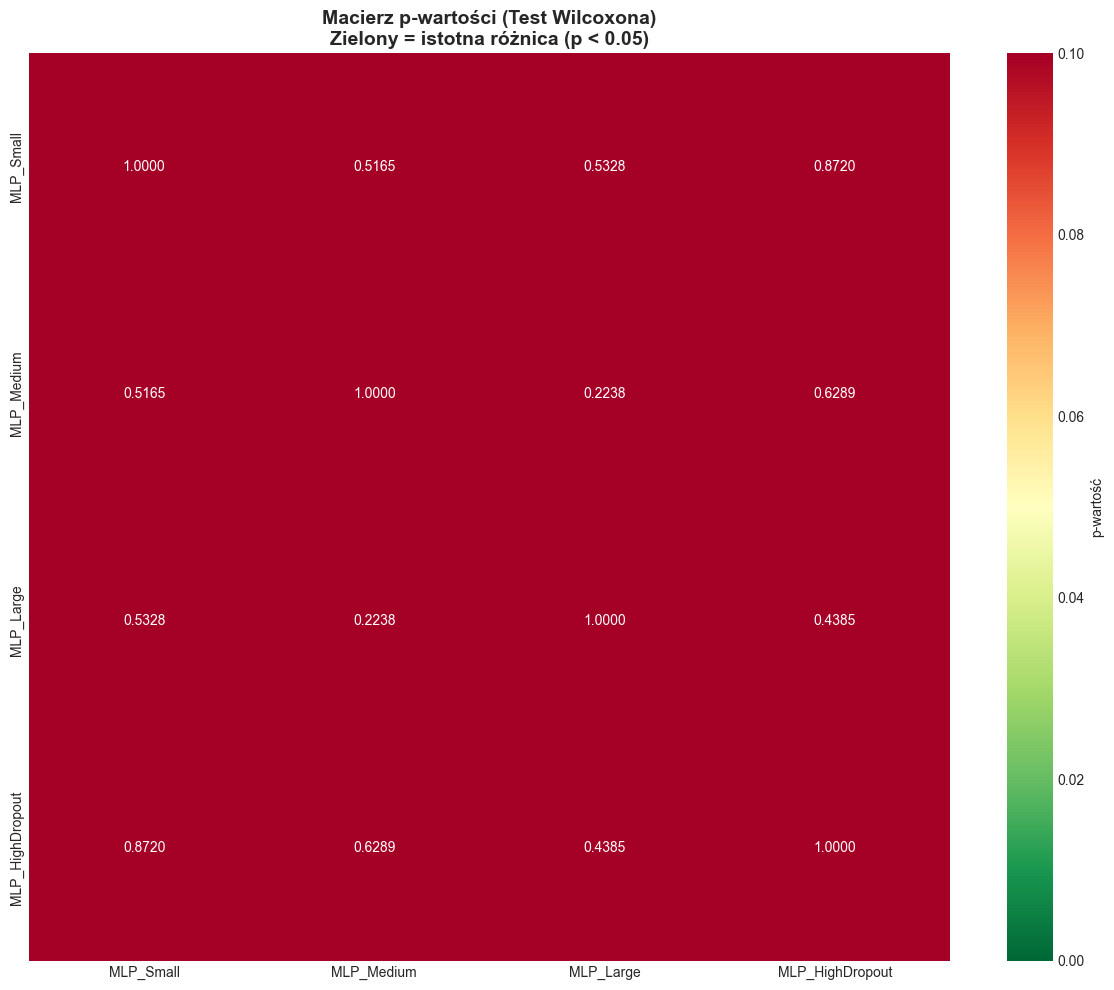


INTERPRETACJA (α = 0.05)

✗ MLP_Small vs MLP_Medium: p = 0.5165
  → Brak istotnej różnicy.

✗ MLP_Small vs MLP_Large: p = 0.5328
  → Brak istotnej różnicy.

✗ MLP_Small vs MLP_HighDropout: p = 0.8720
  → Brak istotnej różnicy.

✗ MLP_Medium vs MLP_Large: p = 0.2238
  → Brak istotnej różnicy.

✗ MLP_Medium vs MLP_HighDropout: p = 0.6289
  → Brak istotnej różnicy.

✗ MLP_Large vs MLP_HighDropout: p = 0.4385
  → Brak istotnej różnicy.


In [16]:
print("=" * 100)
print("TESTY ISTOTNOŚCI STATYSTYCZNEJ")
print("=" * 100)
print("\nPorównanie par modeli (test Wilcoxona dla predykcji)")
print("H0: Nie ma różnicy między modelami")
print("H1: Jest istotna różnica między modelami")
print("-" * 100)

model_names = list(all_results.keys())
n_models = len(model_names)

# Macierz p-wartości
p_values = np.zeros((n_models, n_models))

for i, model1 in enumerate(model_names):
    for j, model2 in enumerate(model_names):
        if i == j:
            p_values[i][j] = 1.0
            continue
        
        y_true = all_results[model1]['true_labels']
        pred1 = all_results[model1]['predictions']
        pred2 = all_results[model2]['predictions']
        
        # Porównanie poprawności predykcji (1 = poprawna, 0 = błędna)
        correct1 = (pred1 == y_true).astype(int)
        correct2 = (pred2 == y_true).astype(int)
        
        # Test Wilcoxona
        if np.array_equal(correct1, correct2):
            p_values[i][j] = 1.0
        else:
            try:
                _, p_value = wilcoxon(correct1, correct2, zero_method='zsplit', alternative='two-sided')
                p_values[i][j] = p_value
            except:
                p_values[i][j] = 1.0

# DataFrame z p-wartościami
p_values_df = pd.DataFrame(p_values, index=model_names, columns=model_names)

print("\nMacierz p-wartości (test Wilcoxona):")
print(p_values_df.to_string())

# Wizualizacja
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(
    p_values_df,
    annot=True,
    fmt='.4f',
    cmap='RdYlGn_r',
    center=0.05,
    vmin=0,
    vmax=0.1,
    ax=ax,
    cbar_kws={'label': 'p-wartość'}
)
ax.set_title('Macierz p-wartości (Test Wilcoxona)\n'
             'Zielony = istotna różnica (p < 0.05)', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Interpretacja
print("\n" + "=" * 100)
print("INTERPRETACJA (α = 0.05)")
print("=" * 100)

for i, model1 in enumerate(model_names):
    for j, model2 in enumerate(model_names):
        if i < j:  # Tylko górny trójkąt
            p_val = p_values_df.loc[model1, model2]
            if p_val < 0.05:
                acc1 = accuracy_score(
                    all_results[model1]['true_labels'],
                    all_results[model1]['predictions']
                )
                acc2 = accuracy_score(
                    all_results[model2]['true_labels'],
                    all_results[model2]['predictions']
                )
                better = model1 if acc1 > acc2 else model2
                print(f"\n✓ {model1} vs {model2}: p = {p_val:.4f}")
                print(f"  → Istotna różnica! {better} jest lepszy.")
            else:
                print(f"\n✗ {model1} vs {model2}: p = {p_val:.4f}")
                print(f"  → Brak istotnej różnicy.")

# 17. Raport Szczegółowy dla Każdego Modelu

Pełny raport dla każdego modelu zawierający:
- Classification Report (precision, recall, f1 per klasa)
- Metryki globalne (accuracy, kappa, MCC)
- Czasy trenowania i inferencji
- Parametry konfiguracji użyte podczas treningu

In [17]:
for model_name, result in all_results.items():
    print("\n" + "=" * 100)
    print(f"RAPORT SZCZEGÓŁOWY: {model_name}")
    print("=" * 100)
    
    y_true = result['true_labels']
    y_pred = result['predictions']
    
    # Classification report
    print("\nClassification Report:")
    print("-" * 100)
    print(classification_report(
        y_true, y_pred, 
        target_names=label_encoder.classes_,
        zero_division=0
    ))
    
    # Dodatkowe metryki
    accuracy = accuracy_score(y_true, y_pred)
    kappa = cohen_kappa_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    
    print("\nDodatkowe Metryki:")
    print("-" * 100)
    print(f"Accuracy:           {accuracy:.4f}")
    print(f"Cohen's Kappa:      {kappa:.4f}")
    print(f"Matthews Corr Coef: {mcc:.4f}")
    
    print("\nCzas:")
    print("-" * 100)
    print(f"Czas trenowania:    {result['train_time']:.2f}s ({result['train_time']/60:.2f} min)")
    
    if model_name in inference_times:
        print(f"Czas inferencji:    {inference_times[model_name]['avg_ms']:.2f}ms")
        print(f"Przepustowość:      {inference_times[model_name]['throughput']:.2f} pred/s")
    
    print("\nKonfiguracja:")
    print("-" * 100)
    for key, value in result['config'].items():
        if key != 'name':
            print(f"  {key}: {value}")


RAPORT SZCZEGÓŁOWY: MLP_Small

Classification Report:
----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

      Biznes       0.71      0.55      0.62        22
        Moto       1.00      0.90      0.95        10
      Polska       0.73      0.88      0.80        51
       Sport       1.00      1.00      1.00        17
 Technologie       0.88      0.88      0.88        24
       Świat       0.86      0.63      0.73        19

    accuracy                           0.81       143
   macro avg       0.86      0.81      0.83       143
weighted avg       0.82      0.81      0.81       143


Dodatkowe Metryki:
----------------------------------------------------------------------------------------------------
Accuracy:           0.8112
Cohen's Kappa:      0.7540
Matthews Corr Coef: 0.7584

Czas:
--------------------------------------------------------------------------------------------

# 18. Podsumowanie i Wnioski

Kompleksowe podsumowanie całej analizy:
- 🏆 Najlepszy model (według F1-Score)
- ⚡ Najszybszy model
- ⚖️ Najlepszy kompromis (wydajność/czas)
- 📊 Porównanie MLP vs Transformers
- 📈 Analiza trudnych kategorii
- 💡 Rekomendacje i możliwe ulepszenia

In [18]:
print("=" * 100)
print("PODSUMOWANIE ANALIZY PORÓWNAWCZEJ MODELI")
print("=" * 100)

# 1. Najlepszy model
best_model = comparison_df.iloc[0]
print(f"\n🏆 NAJLEPSZY MODEL (według F1-Score):")
print(f"   Model: {best_model['Model']}")
print(f"   F1-Score: {best_model['F1-Score']:.4f}")
print(f"   Accuracy: {best_model['Accuracy']:.4f}")
print(f"   Czas trenowania: {best_model['Training Time (min)']:.2f} min")

# 2. Najszybszy model
fastest_model = comparison_df.loc[comparison_df['Training Time (s)'].idxmin()]
print(f"\n⚡ NAJSZYBSZY MODEL (trenowanie):")
print(f"   Model: {fastest_model['Model']}")
print(f"   Czas: {fastest_model['Training Time (min)']:.2f} min")
print(f"   F1-Score: {fastest_model['F1-Score']:.4f}")

# 3. Najlepszy kompromis
comparison_df['Score_per_minute'] = comparison_df['F1-Score'] / comparison_df['Training Time (min)']
best_compromise = comparison_df.loc[comparison_df['Score_per_minute'].idxmax()]
print(f"\n⚖️  NAJLEPSZY KOMPROMIS (wydajność/czas):")
print(f"   Model: {best_compromise['Model']}")
print(f"   F1-Score: {best_compromise['F1-Score']:.4f}")
print(f"   Czas: {best_compromise['Training Time (min)']:.2f} min")
print(f"   Wskaźnik: {best_compromise['Score_per_minute']:.4f} F1/min")

# 4. Analiza per typ modelu
print(f"\n📊 ANALIZA PER TYP MODELU:")

mlp_models = comparison_df[comparison_df['Model'].str.startswith('MLP')]
if len(mlp_models) > 0:
    print(f"\n   MLP Models:")
    print(f"   - Średni F1-Score: {mlp_models['F1-Score'].mean():.4f}")
    print(f"   - Średni czas: {mlp_models['Training Time (min)'].mean():.2f} min")
    print(f"   - Najlepszy: {mlp_models.iloc[0]['Model']} ({mlp_models.iloc[0]['F1-Score']:.4f})")

transformer_models = comparison_df[~comparison_df['Model'].str.startswith('MLP')]
if len(transformer_models) > 0:
    print(f"\n   Transformer Models:")
    print(f"   - Średni F1-Score: {transformer_models['F1-Score'].mean():.4f}")
    print(f"   - Średni czas: {transformer_models['Training Time (min)'].mean():.2f} min")
    if len(transformer_models) > 0:
        print(f"   - Najlepszy: {transformer_models.iloc[0]['Model']} ({transformer_models.iloc[0]['F1-Score']:.4f})")

# 5. Kategorie najbardziej/najmniej problematyczne
print(f"\n📈 ANALIZA KATEGORII:")
category_means = category_df.mean(axis=0).sort_values(ascending=False)
print(f"\n   Najłatwiejsze kategorie (średni F1):")
for cat in category_means.head(3).index:
    print(f"   - {cat}: {category_means[cat]:.4f}")

print(f"\n   Najtrudniejsze kategorie (średni F1):")
for cat in category_means.tail(3).index:
    print(f"   - {cat}: {category_means[cat]:.4f}")

# 6. Rekomendacje
print(f"\n💡 REKOMENDACJE:")
print(f"""
1. DLA PRODUKCJI:
   - Jeśli priorytet: dokładność → użyj {best_model['Model']}
   - Jeśli priorytet: szybkość → użyj {fastest_model['Model']}
   - Jeśli priorytet: balans → użyj {best_compromise['Model']}

2. OBSERWACJE:
   - Modele transformerowe {"osiągają lepsze wyniki" if transformer_models['F1-Score'].mean() > mlp_models['F1-Score'].mean() else "są porównywalne z MLP"} 
     ale wymagają {"znacznie więcej czasu trenowania" if transformer_models['Training Time (min)'].mean() > mlp_models['Training Time (min)'].mean() * 2 else "więcej czasu"}
   - MLP z TF-IDF to dobry baseline - szybki i względnie skuteczny
   - Różnica między najlepszym a najgorszym modelem: {comparison_df['F1-Score'].max() - comparison_df['F1-Score'].min():.4f}

3. MOŻLIWE ULEPSZENIA:
   - Zwiększenie liczby danych treningowych
   - Augmentacja danych (back-translation, synonimizacja)
   - Ensemble (łączenie predykcji wielu modeli)
   - Dostrojenie hiperparametrów (grid search, optuna)
   - Preprocessing (lematyzacja, usuwanie szumu)
""")

PODSUMOWANIE ANALIZY PORÓWNAWCZEJ MODELI

🏆 NAJLEPSZY MODEL (według F1-Score):
   Model: MLP_Medium
   F1-Score: 0.8344
   Accuracy: 0.8392
   Czas trenowania: 0.02 min

⚡ NAJSZYBSZY MODEL (trenowanie):
   Model: MLP_HighDropout
   Czas: 0.02 min
   F1-Score: 0.8126

⚖️  NAJLEPSZY KOMPROMIS (wydajność/czas):
   Model: MLP_HighDropout
   F1-Score: 0.8126
   Czas: 0.02 min
   Wskaźnik: 50.7415 F1/min

📊 ANALIZA PER TYP MODELU:

   MLP Models:
   - Średni F1-Score: 0.8089
   - Średni czas: 0.02 min
   - Najlepszy: MLP_Medium (0.8344)

📈 ANALIZA KATEGORII:

   Najłatwiejsze kategorie (średni F1):
   - Sport: 1.0000
   - Moto: 0.8966
   - Technologie: 0.8599

   Najtrudniejsze kategorie (średni F1):
   - Polska: 0.8110
   - Świat: 0.7303
   - Biznes: 0.6286

💡 REKOMENDACJE:

1. DLA PRODUKCJI:
   - Jeśli priorytet: dokładność → użyj MLP_Medium
   - Jeśli priorytet: szybkość → użyj MLP_HighDropout
   - Jeśli priorytet: balans → użyj MLP_HighDropout

2. OBSERWACJE:
   - Modele transformerowe s

# 19. Zapis Wyników do Plików

Zapis wszystkich wyników analizy do plików do wykorzystania w sprawozdaniu:
- **CSV**: tabela porównawcza, wydajność per kategoria, czasy inferencji
- **JSON**: kompletne podsumowanie z metadanymi
- Wszystkie pliki z timestampem w folderze `analysis_results/`

In [19]:
import json
from datetime import datetime

# Utworzenie folderu na wyniki
results_dir = './analysis_results'
import os
os.makedirs(results_dir, exist_ok=True)

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

# 1. Tabela porównawcza
comparison_file = f'{results_dir}/model_comparison_{timestamp}.csv'
comparison_df.to_csv(comparison_file, index=False)
print(f"✅ Zapisano tabelę porównawczą: {comparison_file}")

# 2. Wyniki per kategoria
category_file = f'{results_dir}/category_performance_{timestamp}.csv'
category_df.to_csv(category_file)
print(f"✅ Zapisano wydajność per kategoria: {category_file}")

# 3. Czasy inferencji
inference_file = f'{results_dir}/inference_times_{timestamp}.csv'
inference_df.to_csv(inference_file)
print(f"✅ Zapisano czasy inferencji: {inference_file}")

# 4. Podsumowanie JSON
summary = {
    'timestamp': timestamp,
    'dataset_info': {
        'total_samples': len(df),
        'num_categories': len(label_encoder.classes_),
        'categories': list(label_encoder.classes_),
        'train_size': len(train_df),
        'val_size': len(val_df),
        'test_size': len(test_df)
    },
    'best_model': {
        'name': best_model['Model'],
        'f1_score': float(best_model['F1-Score']),
        'accuracy': float(best_model['Accuracy']),
        'training_time_min': float(best_model['Training Time (min)'])
    },
    'fastest_model': {
        'name': fastest_model['Model'],
        'f1_score': float(fastest_model['F1-Score']),
        'training_time_min': float(fastest_model['Training Time (min)'])
    },
    'all_models': comparison_df.to_dict('records')
}

summary_file = f'{results_dir}/summary_{timestamp}.json'
with open(summary_file, 'w', encoding='utf-8') as f:
    json.dump(summary, f, indent=2, ensure_ascii=False)
print(f"✅ Zapisano podsumowanie JSON: {summary_file}")

print(f"\n📁 Wszystkie wyniki zapisane w folderze: {results_dir}/")
print(f"\n✅ ANALIZA ZAKOŃCZONA!")
print("=" * 100)

✅ Zapisano tabelę porównawczą: ./analysis_results/model_comparison_20251228_160804.csv
✅ Zapisano wydajność per kategoria: ./analysis_results/category_performance_20251228_160804.csv
✅ Zapisano czasy inferencji: ./analysis_results/inference_times_20251228_160804.csv
✅ Zapisano podsumowanie JSON: ./analysis_results/summary_20251228_160804.json

📁 Wszystkie wyniki zapisane w folderze: ./analysis_results/

✅ ANALIZA ZAKOŃCZONA!


# 20. Zakończenie

✅ **Analiza zakończona!**

Wszystkie wyniki zostały zapisane w folderze `analysis_results/`. Możesz teraz wykorzystać:
- Tabele CSV do wstawienia do sprawozdania
- Wykresy do dokumentacji wizualnej
- Plik JSON z pełnym podsumowaniem